CNN and RNN Encoder - RNN Decoder - Word to Word - With Attention - CGAN
====

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import io
import sys
import time
import os
import glob
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
sys.path.append('../data_collection/compiler')
from IPython.display import IFrame, Markdown
from Compiler import Compiler
from tempfile import NamedTemporaryFile
import importlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.config.experimental_run_functions_eagerly(True)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Read a file and return a string
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

Data Transformation
----

In [3]:
dir_name = 'PIX2CODE_COMPILED'
data_dir = '../data_collection/webpages/' + dir_name

IMG_WIDTH = 299
IMG_HEIGHT = 299

# get all image filepaths
list_img = tf.data.Dataset.list_files(str(data_dir + "/*.png"), shuffle=False)

DATASET_SIZE = len(glob.glob(data_dir + "/*.png"))

for f in list_img.take(5):
    print(f.numpy())

b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00150311-A7AE-4804-8B7D-9273687B4FC0.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00190F39-0DE9-47EB-B0C2-856FDD3ACE62.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00779BBE-DD64-4909-9909-24F5C8044A7B.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00CDC9A8-3D73-4291-90EF-49178E408797.png'
b'..\\data_collection\\webpages\\PIX2CODE_COMPILED\\00E15BB2-5568-4466-BA18-A8A8D34FC61C.png'


**Image Processing**

In [4]:
# decodes an image string
@tf.function
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img = tf.image.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                          
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # resize the image to the desired size.
    return img

**Sequence Processing**

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc('./DSL.vocab')])

# Add padding
tokenizer.word_index['<PAD>'] = 0
tokenizer.index_word[0] = '<PAD>'

In [6]:
def tokenizer_lookup(word):
    return tokenizer.word_index[word.numpy().decode()]

# tensorflow way to convert text to sequence with tokenizer
@tf.function
def text_to_seq(text, tokenizer):
    spl = tf.map_fn(lambda t: tf.py_function(func=tokenizer_lookup, inp=[t], Tout=tf.int32), text, dtype="int32")
    return spl

In [7]:
# converts image filepath to its label
@tf.function
def get_seq(file_path):
    # convert from png to gui file
    path = tf.strings.regex_replace(file_path, ".png", ".gui")
    # read contents and return
    label = tf.constant("<START> ") + tf.io.read_file(path) + tf.constant(" <END>")
    return tf.strings.split(label)

In [8]:
print(tokenizer.index_word)

{1: '{', 2: '}', 3: '<START>', 4: '<END>', 5: 'Body', 6: 'Block', 7: 'Container', 8: 'Row', 9: 'Column', 10: 'Header', 11: 'Footer', 12: 'Paragraph', 13: 'Image', 14: 'Button', 15: 'Subtitle', 16: 'Title', 17: 'Link', 18: 'TextBox', 19: 'CheckBox', 20: 'RadioBox', 21: 'Range', 0: '<PAD>'}


**Combine and Split Datasets**

In [9]:
# does all processing per dataset image path
@tf.function
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    seq = get_seq(file_path)
    seq = text_to_seq(seq, tokenizer)
    return img, seq

In [10]:
dataset = list_img.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
max_length = dataset.map(lambda _, y: tf.size(y), num_parallel_calls=AUTOTUNE)
max_length = max_length.reduce(tf.constant(0), lambda x, y: tf.math.maximum(x, y))

Image shape:  (299, 299, 3)
Sequence:  ['<START> Body { Header { Button Link Link Link } Row { Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>']


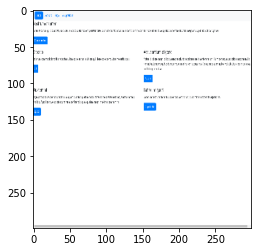

In [12]:
dataset = dataset.map(lambda x, y: (x, tf.concat([y, tf.repeat(0, max_length - tf.size(y))], -1)))

for image, seq in dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Sequence: ", tokenizer.sequences_to_texts([seq.numpy()]))
    plt.imshow(image.numpy())

In [13]:
train_size = int(DATASET_SIZE * 0.7)
val_size = int(DATASET_SIZE * 0.1)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

In [14]:
BATCH_SIZE = 8
BUFFER_SIZE = 150
embedding_dim = 16
encoder_units = 128
decoder_units = 224
discriminator_units = 128
num_steps = train_size // BATCH_SIZE
num_val_steps = val_size // BATCH_SIZE
vocab_size = len(tokenizer.word_index) + 1

train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset_wrong = train_dataset.batch(BATCH_SIZE * 2)
train_dataset_wrong = train_dataset_wrong.map(lambda img, seq: (img, tf.roll(seq, shift=BATCH_SIZE, axis=0)),
                                             num_parallel_calls=AUTOTUNE)
train_dataset_wrong = train_dataset_wrong.unbatch()
train_dataset_wrong = train_dataset_wrong.batch(BATCH_SIZE, drop_remainder=True)
train_dataset_wrong = train_dataset_wrong.map(lambda img, seq: (img, tf.roll(seq, shift=BATCH_SIZE // 2, axis=0)),
                                             num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset_wrong = train_dataset_wrong.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Model Definition
----

In [15]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3,)))
        self.model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
        self.model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2))
        self.model.add(tf.keras.layers.Dropout(0.2))
        self.model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))

        self.model.add(tf.keras.layers.Dense(256, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.2))
        
#         image_model = tf.keras.applications.InceptionV3(include_top=False, weights=None)
#         new_input = image_model.input
#         hidden_layer = image_model.layers[-1].output
#         print(hidden_layer)

#         self.incept = tf.keras.Model(new_input, hidden_layer)
        self.out = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.model(x)
        
        x = self.out(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        
        x = tf.nn.relu(x)
        
        return x

In [16]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
class RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(RNN_Encoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.gru = tf.keras.models.Sequential()
#         self.gru.add(tf.keras.layers.GRU(self.units,
#                                    return_sequences=True,
#                                    dropout=0.2,
#                                    recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units, activation='relu')))
        
    def call(self, x):
        x = self.embedding(x)
        
        x = self.gru(x)
        
        return x
    
    def get_embedding_weights(self):
        return self.embedding.get_weights()
        
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
class CNN_RNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, max_length):
        super(CNN_RNN_Encoder, self).__init__()
        self.rnn = RNN_Encoder(embedding_dim, units, vocab_size, max_length)
        self.cnn = CNN_Encoder(embedding_dim)
        self.features = None
        
    def call(self, seq, img=None):
        if img is None and self.features is None:
            print("Error, img and features None")
            return
        elif img is not None:
            self.features = self.cnn(img)
             
        seq = self.rnn(seq)
        
        return self.features, seq
    
    def set_features(self, img):
        self.features = self.cnn(img)
        
    def get_features(self):
        return self.features
    
    def get_embedding_weights(self):
        return self.rnn.get_embedding_weights()
    
    def reset_state(self, batch_size):
        return self.rnn.reset_state(batch_size)

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, max_length):
        super(RNN_Decoder, self).__init__()
        self.units = units
#         self.gru1 = tf.keras.layers.GRU(self.units,
#                                    return_sequences=True,
#                                    dropout=0.2,
#                                    recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        self.rep = tf.keras.layers.RepeatVector(max_length)
        
    def call(self, features, seq, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        feat = self.rep(context_vector)
        
        x = tf.keras.layers.concatenate([feat, seq])
        
        x, state = self.gru2(x)
        
        x = self.fc(x)
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [20]:
class RNN_Encoder_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Encoder_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.models.Sequential()
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.gru.add(tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform'))
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, features, hidden):
        x = self.embedding(x)
    
        x = tf.concat([tf.expand_dims(features, 1), x], axis=-1)
        
        output, state = self.gru(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)
        
        return x, state
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
class RNN_Discriminator(tf.keras.Model):
    def __init__(self, units, max_length):
        super(RNN_Discriminator, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
#         self.gru1 = tf.keras.layers.GRU(self.units,
#                                    return_sequences=True,
#                                    dropout=0.2,
#                                    recurrent_initializer='glorot_uniform')
        self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=False,
                                   dropout=0.2,
                                   recurrent_initializer='glorot_uniform')
        self.rep = tf.keras.layers.RepeatVector(max_length)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, features):
        x = self.embedding(x)
        
        feat = self.rep(tf.keras.layers.Flatten()(features))
        
        x = tf.keras.layers.concatenate([feat, x])
        
        x = self.gru2(x)
        
        x = self.fc1(x)

        x = self.fc2(x)
        
        return x
    
    def set_embedding_weights(self, weights):
        self.embedding.set_weights(weights)

In [22]:
encoder = CNN_RNN_Encoder(embedding_dim, encoder_units, vocab_size, max_length)
decoder = RNN_Decoder(decoder_units, vocab_size, max_length)
discriminator = RNN_Discriminator(discriminator_units, max_length)

Model Training
----

**Pre Training Generator**

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [24]:
checkpoint_path = "./checkpoints/cnnrnn_rnn_s2w_att"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_plot = []

In [27]:
@tf.function
def pad_tensor_sequence(seq):
    return tf.pad(seq, [[0, 0], [0, max_length - seq.shape[1]]], "CONSTANT")

In [28]:
@tf.function
def train_step(img_tensor, target, val=False):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']] * target.shape[0], 1)
    dec_input = pad_tensor_sequence(dec_input)
    
    if val:
        encoder.set_features(img_tensor)

        for i in range(1, target.shape[1]):
            features, seq = encoder(dec_input)
            # passing the features through the decoder
            predictions, hidden, _ = decoder(features, seq, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.slice(dec_input, [0, 0], [-1, i])
            dec_input = tf.concat([dec_input, tf.expand_dims(target[:, i], 1)], 1)
            dec_input = pad_tensor_sequence(dec_input)

        total_loss = (loss / int(target.shape[1]))
        return loss, total_loss

    with tf.GradientTape() as tape:
        encoder.set_features(img_tensor)

        for i in range(1, target.shape[1]):
            features, seq = encoder(dec_input)
            # passing the features through the decoder
            predictions, hidden, _ = decoder(features, seq, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.slice(dec_input, [0, 0], [-1, i])
            dec_input = tf.concat([dec_input, tf.expand_dims(target[:, i], 1)], 1)
            dec_input = pad_tensor_sequence(dec_input)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            print ('Time taken for Batches {} sec'.format(time.time() - start))
            
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        _, t_loss = train_step(img_tensor, target, True)
        total_val_loss += t_loss
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_plot.append(total_val_loss / num_val_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, total_val_loss/num_val_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [29]:
@tf.function
def evaluate_batch(image):
    
    hidden = decoder.reset_state(batch_size=1)

    encoder.set_features(img)
    encoder.set_features(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']] * BATCH_SIZE, 1)
    dec_input = pad_tensor_sequence(dec_input)
    
    result = None

    for i in range(max_length):
        features, seq = encoder(dec_input)
        predictions, hidden, _ = decoder(features, seq, hidden)

        predictions = tf.cast(tf.random.categorical(predictions, 1), dtype="int32")
        
        pad_mask = tf.logical_not(tf.reduce_any(tf.equal(dec_input, tokenizer.word_index['<END>']), axis=1))
                
        dec_input = tf.slice(dec_input, [0, 0], [-1, i])
        dec_input = tf.concat([dec_input, tf.expand_dims(predictions[:, 0], 1)], 1)
        dec_input = pad_tensor_sequence(dec_input)
        
        end_mask = tf.reduce_any(tf.equal(dec_input, tokenizer.word_index['<END>']), axis=1)
        
        mask = tf.logical_and(end_mask, pad_mask)
        reached_end = tf.boolean_mask(dec_input, mask)

        if result is None and reached_end.shape[0] > 0:
            result = reached_end
        elif reached_end.shape[0] > 0:
            result = tf.concat([result, reached_end], 0)
        
    if result is None:
        result = dec_input
    else:
        end_mask = tf.logical_not(tf.reduce_any(tf.equal(dec_input, tokenizer.word_index['<END>']), axis=1))
        reached_end = tf.boolean_mask(dec_input, end_mask)
        result = tf.concat([result, reached_end], 0)

    return result

**Pre Training Discriminator**

In [38]:
disc_optimizer = tf.keras.optimizers.Adam()
disc_loss_object = tf.keras.losses.BinaryCrossentropy()

def disc_loss_function(target, pred):
    print(is_true)
    print(pred)
    if is_true:
        y = tf.constant([[1.]] * BATCH_SIZE)
        loss = disc_loss_object(y, pred)
    else:
        y = tf.constant([[0.]] * BATCH_SIZE)
        loss = tf.math.scalar_mul(0.5, disc_loss_object(y, pred))

    return loss

In [39]:
disc_pre_size = int(train_size * 0.2)
num_disc_steps = disc_pre_size // BATCH_SIZE

disc_base = train_dataset.take(disc_pre_size)

disc_img = disc_base.map(lambda img, _: img)
disc_real = disc_base.map(lambda _, real: real)
disc_fake = train_dataset_wrong.take(disc_pre_size).map(lambda _, fake: fake)

disc_pre_dataset = tf.data.Dataset.zip((disc_img, disc_real, disc_fake))

In [40]:
disc_checkpoint_path = "./checkpoints/cnnrnn_rnn_s2w_att/disc"
disc_ckpt = tf.train.Checkpoint(discriminator = discriminator,
                           disc_optimizer = disc_optimizer)
disc_ckpt_manager = tf.train.CheckpointManager(disc_ckpt, disc_checkpoint_path, max_to_keep=5)

In [41]:
disc_start_epoch = 0
if disc_ckpt_manager.latest_checkpoint:
    disc_start_epoch = int(disc_ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    disc_ckpt.restore(disc_ckpt_manager.latest_checkpoint)

In [42]:
@tf.function
def disc_train_step(img, seq, is_true):
    loss = 0

    features = encoder.get_features()
    
#     print(tf.keras.backend.flatten(features))

    with tf.GradientTape() as tape:
#         print(real)
#         print(pred)
#         print(fake)
        pred = discriminator(seq, features)
        
        loss = disc_loss_function(is_true, pred)
        
    trainable_variables = discriminator.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    disc_optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [43]:
disc_loss_plot = []

In [44]:
DISC_EPOCHS = 20

discriminator.set_embedding_weights(encoder.get_embedding_weights())

for epoch in range(0, DISC_EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img, real, fake)) in enumerate(disc_pre_dataset):
        pred = evaluate_batch(img)
        
        loss = disc_train_step(target, img, seq)
        total_loss += loss

        if batch % 5 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, loss.numpy()))
            print ('Time taken for Batches {} sec'.format(time.time() - start))
        
    # storing the epoch end loss value to plot later
    disc_loss_plot.append(total_loss / num_disc_steps)

    if epoch % 5 == 0:
        disc_ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_disc_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

True
tf.Tensor(
[[0.49139753]
 [0.49139753]
 [0.49139753]
 [0.49139753]
 [0.49139753]
 [0.49139753]
 [0.49139753]
 [0.49139753]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.741308]
 [0.741308]
 [0.741308]
 [0.741308]
 [0.741308]
 [0.741308]
 [0.741308]
 [0.741308]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.76193964]
 [0.76193964]
 [0.76193964]
 [0.76193964]
 [0.76193964]
 [0.76193964]
 [0.76193964]
 [0.76193964]], shape=(8, 1), dtype=float32)
Epoch 1 Batch 0 Loss 0.7014
Time taken for Batches 13.095447301864624 sec
True
tf.Tensor(
[[0.7063559]
 [0.7063559]
 [0.7063559]
 [0.7063559]
 [0.7063559]
 [0.7063559]
 [0.7063559]
 [0.7063559]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.70969087]
 [0.70969087]
 [0.70969087]
 [0.70969087]
 [0.70969087]
 [0.70969087]
 [0.70969087]
 [0.70969087]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.6605306]
 [0.6605306]
 [0.6605306]
 [0.6605306]
 [0.6605306]
 [0.6605306]
 [0.6605306]
 [0.6605306]], shape=(8, 1), dtype=float32)


True
tf.Tensor(
[[0.49764436]
 [0.49764436]
 [0.49764436]
 [0.49764436]
 [0.49764436]
 [0.49764436]
 [0.49764436]
 [0.49764436]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5192957]
 [0.5192957]
 [0.5192957]
 [0.5192957]
 [0.5192957]
 [0.5192957]
 [0.5192957]
 [0.5192957]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5201939]
 [0.5201939]
 [0.5201939]
 [0.5201939]
 [0.5201939]
 [0.5201939]
 [0.5201939]
 [0.5201939]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.5022289]
 [0.5022289]
 [0.5022289]
 [0.5022289]
 [0.5022289]
 [0.5022289]
 [0.5022289]
 [0.5022289]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5218313]
 [0.5218313]
 [0.5218313]
 [0.5218313]
 [0.5218313]
 [0.5218313]
 [0.5218313]
 [0.5218313]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5207912]
 [0.5207912]
 [0.5207912]
 [0.5207912]
 [0.5207912]
 [0.5207912]
 [0.5207912]
 [0.5207912]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.5010555]
 [0.5010555]
 [0.5010555]
 [0.5010555]
 [0.5010555]
 

True
tf.Tensor(
[[0.49013984]
 [0.49013984]
 [0.49013984]
 [0.49013984]
 [0.49013984]
 [0.49013984]
 [0.49013984]
 [0.49013984]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5098622]
 [0.5098622]
 [0.5098621]
 [0.5098622]
 [0.5098622]
 [0.5098622]
 [0.5098622]
 [0.5098622]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5093851]
 [0.5093851]
 [0.5093851]
 [0.5093851]
 [0.5093851]
 [0.5093851]
 [0.5093851]
 [0.5093851]], shape=(8, 1), dtype=float32)
Epoch 1 Batch 35 Loss 0.4752
Time taken for Batches 72.97855877876282 sec
True
tf.Tensor(
[[0.49066332]
 [0.49066332]
 [0.49066332]
 [0.49066332]
 [0.49066332]
 [0.49066332]
 [0.49066332]
 [0.49066332]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5102987]
 [0.5102987]
 [0.5102987]
 [0.5102987]
 [0.5102987]
 [0.5102987]
 [0.5102987]
 [0.5102987]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5097333]
 [0.5097333]
 [0.5097333]
 [0.5097333]
 [0.5097333]
 [0.5097333]
 [0.5097333]
 [0.5097333]], shape=(8, 1), dtype=float32)


True
tf.Tensor(
[[0.49037892]
 [0.49037892]
 [0.49037892]
 [0.49037892]
 [0.49037892]
 [0.49037892]
 [0.49037892]
 [0.49037892]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5097526]
 [0.5097526]
 [0.5097526]
 [0.5097526]
 [0.5097526]
 [0.5097526]
 [0.5097526]
 [0.5097526]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5091028]
 [0.5091028]
 [0.5091028]
 [0.5091028]
 [0.5091028]
 [0.5091028]
 [0.5091028]
 [0.5091028]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49040183]
 [0.49040183]
 [0.49040183]
 [0.49040183]
 [0.49040183]
 [0.49040183]
 [0.49040183]
 [0.49040183]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5097697]
 [0.5097697]
 [0.5097697]
 [0.5097697]
 [0.5097697]
 [0.5097697]
 [0.5097697]
 [0.5097697]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5091238]
 [0.5091238]
 [0.5091238]
 [0.5091238]
 [0.5091238]
 [0.5091238]
 [0.5091238]
 [0.5091238]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49043664]
 [0.49043664]
 [0.49043664]
 [0.49043664]
 [

True
tf.Tensor(
[[0.49055046]
 [0.49055046]
 [0.49055046]
 [0.49055046]
 [0.49055046]
 [0.49055046]
 [0.49055046]
 [0.49055046]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50970876]
 [0.50970876]
 [0.50970876]
 [0.50970876]
 [0.50970876]
 [0.50970876]
 [0.50970876]
 [0.50970876]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5090552]
 [0.5090552]
 [0.5090552]
 [0.5090552]
 [0.5090552]
 [0.5090552]
 [0.5090552]
 [0.5090552]], shape=(8, 1), dtype=float32)
Epoch 1 Batch 70 Loss 0.4748
Time taken for Batches 132.26224851608276 sec
True
tf.Tensor(
[[0.4905559]
 [0.4905559]
 [0.4905559]
 [0.4905559]
 [0.4905559]
 [0.4905559]
 [0.4905559]
 [0.4905559]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5097026]
 [0.5097026]
 [0.5097026]
 [0.5097026]
 [0.5097026]
 [0.5097026]
 [0.5097026]
 [0.5097026]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5090497]
 [0.5090497]
 [0.5090497]
 [0.5090497]
 [0.5090497]
 [0.5090497]
 [0.5090497]
 [0.5090497]], shape=(8, 1), dtype=float32)

True
tf.Tensor(
[[0.4906592]
 [0.4906592]
 [0.4906592]
 [0.4906592]
 [0.4906592]
 [0.4906592]
 [0.4906592]
 [0.4906592]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50961155]
 [0.50961155]
 [0.50961155]
 [0.50961155]
 [0.50961155]
 [0.50961155]
 [0.50961155]
 [0.50961155]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50896263]
 [0.50896263]
 [0.50896263]
 [0.50896263]
 [0.50896263]
 [0.50896263]
 [0.50896263]
 [0.50896263]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49066517]
 [0.49066517]
 [0.49066517]
 [0.49066517]
 [0.49066517]
 [0.49066517]
 [0.49066517]
 [0.49066517]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5096055]
 [0.5096055]
 [0.5096055]
 [0.5096055]
 [0.5096055]
 [0.5096055]
 [0.5096055]
 [0.5096055]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50895673]
 [0.50895673]
 [0.50895673]
 [0.50895673]
 [0.50895673]
 [0.50895673]
 [0.50895673]
 [0.50895673]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49067107]
 [0.49067107]
 [0.49067107]


True
tf.Tensor(
[[0.49076644]
 [0.49076644]
 [0.49076644]
 [0.49076644]
 [0.49076644]
 [0.49076644]
 [0.49076644]
 [0.49076644]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5095065]
 [0.5095065]
 [0.5095065]
 [0.5095065]
 [0.5095065]
 [0.5095065]
 [0.5095065]
 [0.5095065]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088631]
 [0.5088631]
 [0.5088631]
 [0.5088631]
 [0.5088631]
 [0.5088631]
 [0.5088631]
 [0.5088631]], shape=(8, 1), dtype=float32)
Epoch 1 Batch 105 Loss 0.4745
Time taken for Batches 192.58251476287842 sec
True
tf.Tensor(
[[0.49077237]
 [0.49077237]
 [0.49077237]
 [0.49077237]
 [0.49077237]
 [0.49077237]
 [0.49077237]
 [0.49077237]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5095009]
 [0.5095009]
 [0.5095009]
 [0.5095009]
 [0.5095009]
 [0.5095009]
 [0.5095009]
 [0.5095009]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088577]
 [0.5088577]
 [0.5088577]
 [0.5088577]
 [0.5088577]
 [0.5088577]
 [0.5088577]
 [0.5088577]], shape=(8, 1), dtype=float32

True
tf.Tensor(
[[0.49086177]
 [0.49086177]
 [0.49086177]
 [0.49086177]
 [0.49086177]
 [0.49086177]
 [0.49086177]
 [0.49086177]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5094119]
 [0.5094119]
 [0.5094119]
 [0.5094119]
 [0.5094119]
 [0.5094119]
 [0.5094119]
 [0.5094119]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50877374]
 [0.50877374]
 [0.50877374]
 [0.50877374]
 [0.50877374]
 [0.50877374]
 [0.50877374]
 [0.50877374]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4908672]
 [0.4908672]
 [0.4908672]
 [0.4908672]
 [0.4908672]
 [0.4908672]
 [0.4908672]
 [0.4908672]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5094065]
 [0.5094065]
 [0.5094065]
 [0.5094065]
 [0.5094065]
 [0.5094065]
 [0.5094065]
 [0.5094065]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5087688]
 [0.5087688]
 [0.5087688]
 [0.5087688]
 [0.5087688]
 [0.5087688]
 [0.5087688]
 [0.5087688]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4908726]
 [0.4908726]
 [0.4908726]
 [0.4908726]
 [0.49

True
tf.Tensor(
[[0.49095556]
 [0.49095556]
 [0.49095556]
 [0.49095556]
 [0.49095556]
 [0.49095556]
 [0.49095556]
 [0.49095556]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5093177]
 [0.5093177]
 [0.5093177]
 [0.5093177]
 [0.5093177]
 [0.5093177]
 [0.5093177]
 [0.5093177]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50868505]
 [0.50868505]
 [0.50868505]
 [0.50868505]
 [0.50868505]
 [0.50868505]
 [0.50868505]
 [0.50868505]], shape=(8, 1), dtype=float32)
Epoch 1 Batch 140 Loss 0.4742
Time taken for Batches 249.18988132476807 sec
True
tf.Tensor(
[[0.49096057]
 [0.49096057]
 [0.49096057]
 [0.49096057]
 [0.49096057]
 [0.49096057]
 [0.49096057]
 [0.49096057]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50931257]
 [0.50931257]
 [0.50931257]
 [0.50931257]
 [0.50931257]
 [0.50931257]
 [0.50931257]
 [0.50931257]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086802]
 [0.5086802]
 [0.5086802]
 [0.5086802]
 [0.5086802]
 [0.5086802]
 [0.5086802]
 [0.5086802]], shape=(8, 1

True
tf.Tensor(
[[0.49103776]
 [0.49103776]
 [0.49103776]
 [0.49103776]
 [0.49103776]
 [0.49103776]
 [0.49103776]
 [0.49103776]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50923467]
 [0.50923467]
 [0.50923467]
 [0.50923467]
 [0.50923467]
 [0.50923467]
 [0.50923467]
 [0.50923467]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086071]
 [0.5086071]
 [0.5086071]
 [0.5086071]
 [0.5086071]
 [0.5086071]
 [0.5086071]
 [0.5086071]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49104246]
 [0.49104246]
 [0.49104246]
 [0.49104246]
 [0.49104246]
 [0.49104246]
 [0.49104246]
 [0.49104246]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50923]
 [0.50923]
 [0.50923]
 [0.50923]
 [0.50923]
 [0.50923]
 [0.50923]
 [0.50923]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50860274]
 [0.50860274]
 [0.50860274]
 [0.50860274]
 [0.50860274]
 [0.50860274]
 [0.50860274]
 [0.50860274]], shape=(8, 1), dtype=float32)
Epoch 2 Batch 5 Loss 0.4741
Time taken for Batches 20.228068590164185 sec


True
tf.Tensor(
[[0.49111846]
 [0.49111846]
 [0.49111846]
 [0.49111846]
 [0.49111846]
 [0.49111846]
 [0.49111846]
 [0.49111846]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5091527]
 [0.5091527]
 [0.5091527]
 [0.5091527]
 [0.5091527]
 [0.5091527]
 [0.5091527]
 [0.5091527]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5085303]
 [0.5085303]
 [0.5085303]
 [0.5085303]
 [0.5085303]
 [0.5085303]
 [0.5085303]
 [0.5085303]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49112284]
 [0.49112284]
 [0.49112284]
 [0.49112284]
 [0.49112284]
 [0.49112284]
 [0.49112284]
 [0.49112284]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50914836]
 [0.50914836]
 [0.50914836]
 [0.50914836]
 [0.50914836]
 [0.50914836]
 [0.50914836]
 [0.50914836]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5085262]
 [0.5085262]
 [0.5085262]
 [0.5085262]
 [0.5085262]
 [0.5085262]
 [0.5085262]
 [0.5085262]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4911271]
 [0.4911271]
 [0.4911271]
 [0.4911271

True
tf.Tensor(
[[0.49119323]
 [0.49119323]
 [0.49119323]
 [0.49119323]
 [0.49119323]
 [0.49119323]
 [0.49119323]
 [0.49119323]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50907654]
 [0.50907654]
 [0.50907654]
 [0.50907654]
 [0.50907654]
 [0.50907654]
 [0.50907654]
 [0.50907654]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508459]
 [0.508459]
 [0.508459]
 [0.508459]
 [0.508459]
 [0.508459]
 [0.508459]
 [0.508459]], shape=(8, 1), dtype=float32)
Epoch 2 Batch 40 Loss 0.4739
Time taken for Batches 75.56210350990295 sec
True
tf.Tensor(
[[0.49119738]
 [0.49119738]
 [0.49119738]
 [0.49119738]
 [0.49119738]
 [0.49119738]
 [0.49119738]
 [0.49119738]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5090725]
 [0.5090725]
 [0.5090725]
 [0.5090725]
 [0.5090725]
 [0.5090725]
 [0.5090725]
 [0.5090725]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5084551]
 [0.5084551]
 [0.5084551]
 [0.5084551]
 [0.5084551]
 [0.5084551]
 [0.5084551]
 [0.5084551]], shape=(8, 1), dtype=float32)


True
tf.Tensor(
[[0.491259]
 [0.491259]
 [0.491259]
 [0.491259]
 [0.491259]
 [0.491259]
 [0.491259]
 [0.491259]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5090091]
 [0.5090091]
 [0.5090091]
 [0.5090091]
 [0.5090091]
 [0.5090091]
 [0.5090091]
 [0.5090091]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5083958]
 [0.5083958]
 [0.5083958]
 [0.5083958]
 [0.5083958]
 [0.5083958]
 [0.5083958]
 [0.5083958]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49126285]
 [0.49126285]
 [0.49126285]
 [0.49126285]
 [0.49126285]
 [0.49126285]
 [0.49126285]
 [0.49126285]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5090055]
 [0.5090055]
 [0.5090055]
 [0.5090055]
 [0.5090055]
 [0.5090055]
 [0.5090055]
 [0.5090055]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5083924]
 [0.5083924]
 [0.5083924]
 [0.5083924]
 [0.5083924]
 [0.5083924]
 [0.5083924]
 [0.5083924]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49126676]
 [0.49126676]
 [0.49126676]
 [0.49126676]
 [0.49126676]
 [0.

True
tf.Tensor(
[[0.49132466]
 [0.49132466]
 [0.49132466]
 [0.49132466]
 [0.49132466]
 [0.49132466]
 [0.49132466]
 [0.49132466]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50894225]
 [0.50894225]
 [0.50894225]
 [0.50894225]
 [0.50894225]
 [0.50894225]
 [0.50894225]
 [0.50894225]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50833315]
 [0.50833315]
 [0.50833315]
 [0.50833315]
 [0.50833315]
 [0.50833315]
 [0.50833315]
 [0.50833315]], shape=(8, 1), dtype=float32)
Epoch 2 Batch 75 Loss 0.4737
Time taken for Batches 136.31293606758118 sec
True
tf.Tensor(
[[0.49132812]
 [0.49132812]
 [0.49132812]
 [0.49132812]
 [0.49132812]
 [0.49132812]
 [0.49132812]
 [0.49132812]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50893855]
 [0.50893855]
 [0.50893855]
 [0.50893855]
 [0.50893855]
 [0.50893855]
 [0.50893855]
 [0.50893855]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5083297]
 [0.5083297]
 [0.5083297]
 [0.5083297]
 [0.5083297]
 [0.5083297]
 [0.5083297]
 [0.5083297]], shap

True
tf.Tensor(
[[0.49138296]
 [0.49138296]
 [0.49138296]
 [0.49138296]
 [0.49138296]
 [0.49138296]
 [0.49138296]
 [0.49138296]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088823]
 [0.5088823]
 [0.5088823]
 [0.5088823]
 [0.5088823]
 [0.5088823]
 [0.5088823]
 [0.5088823]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5082771]
 [0.5082771]
 [0.5082771]
 [0.5082771]
 [0.5082771]
 [0.5082771]
 [0.5082771]
 [0.5082771]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49138635]
 [0.49138635]
 [0.49138635]
 [0.49138635]
 [0.49138635]
 [0.49138635]
 [0.49138635]
 [0.49138635]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088788]
 [0.5088788]
 [0.5088788]
 [0.5088788]
 [0.5088788]
 [0.5088788]
 [0.5088788]
 [0.5088788]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50827396]
 [0.50827396]
 [0.50827396]
 [0.50827396]
 [0.50827396]
 [0.50827396]
 [0.50827396]
 [0.50827396]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4913897]
 [0.4913897]
 [0.4913897]
 [0.4913897

True
tf.Tensor(
[[0.49144164]
 [0.49144164]
 [0.49144164]
 [0.49144164]
 [0.49144164]
 [0.49144164]
 [0.49144164]
 [0.49144164]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088216]
 [0.5088216]
 [0.5088216]
 [0.5088216]
 [0.5088216]
 [0.5088216]
 [0.5088216]
 [0.5088216]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5082204]
 [0.5082204]
 [0.5082204]
 [0.5082204]
 [0.5082204]
 [0.5082204]
 [0.5082204]
 [0.5082204]], shape=(8, 1), dtype=float32)
Epoch 2 Batch 110 Loss 0.4736
Time taken for Batches 197.78281116485596 sec
True
tf.Tensor(
[[0.4914448]
 [0.4914448]
 [0.4914448]
 [0.4914448]
 [0.4914448]
 [0.4914448]
 [0.4914448]
 [0.4914448]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5088184]
 [0.5088184]
 [0.5088184]
 [0.5088184]
 [0.5088184]
 [0.5088184]
 [0.5088184]
 [0.5088184]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50821733]
 [0.50821733]
 [0.50821733]
 [0.50821733]
 [0.50821733]
 [0.50821733]
 [0.50821733]
 [0.50821733]], shape=(8, 1), dtype=float32

True
tf.Tensor(
[[0.49149475]
 [0.49149475]
 [0.49149475]
 [0.49149475]
 [0.49149475]
 [0.49149475]
 [0.49149475]
 [0.49149475]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508767]
 [0.508767]
 [0.508767]
 [0.508767]
 [0.508767]
 [0.508767]
 [0.508767]
 [0.508767]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5081693]
 [0.5081693]
 [0.5081693]
 [0.5081693]
 [0.5081693]
 [0.5081693]
 [0.5081693]
 [0.5081693]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49149784]
 [0.49149784]
 [0.49149784]
 [0.49149784]
 [0.49149784]
 [0.49149784]
 [0.49149784]
 [0.49149784]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5087639]
 [0.5087639]
 [0.5087639]
 [0.5087639]
 [0.5087639]
 [0.5087639]
 [0.5087639]
 [0.5087639]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50816643]
 [0.50816643]
 [0.50816643]
 [0.50816643]
 [0.50816643]
 [0.50816643]
 [0.50816643]
 [0.50816643]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49150094]
 [0.49150094]
 [0.49150094]
 [0.49150094]
 [

True
tf.Tensor(
[[0.49154854]
 [0.49154854]
 [0.49154854]
 [0.49154854]
 [0.49154854]
 [0.49154854]
 [0.49154854]
 [0.49154854]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50871116]
 [0.50871116]
 [0.50871116]
 [0.50871116]
 [0.50871116]
 [0.50871116]
 [0.50871116]
 [0.50871116]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50811714]
 [0.50811714]
 [0.50811714]
 [0.50811714]
 [0.50811714]
 [0.50811714]
 [0.50811714]
 [0.50811714]], shape=(8, 1), dtype=float32)
Epoch 2 Batch 145 Loss 0.4734
Time taken for Batches 252.13449954986572 sec
True
tf.Tensor(
[[0.49155152]
 [0.49155152]
 [0.49155152]
 [0.49155152]
 [0.49155152]
 [0.49155152]
 [0.49155152]
 [0.49155152]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50870806]
 [0.50870806]
 [0.50870806]
 [0.50870806]
 [0.50870806]
 [0.50870806]
 [0.50870806]
 [0.50870806]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50811434]
 [0.50811434]
 [0.50811434]
 [0.50811434]
 [0.50811434]
 [0.50811434]
 [0.50811434]
 [0.5081143

True
tf.Tensor(
[[0.4915978]
 [0.4915978]
 [0.4915978]
 [0.4915978]
 [0.4915978]
 [0.4915978]
 [0.4915978]
 [0.4915978]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086604]
 [0.5086604]
 [0.5086604]
 [0.5086604]
 [0.5086604]
 [0.5086604]
 [0.5086604]
 [0.5086604]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5080697]
 [0.5080697]
 [0.5080697]
 [0.5080697]
 [0.5080697]
 [0.5080697]
 [0.5080697]
 [0.5080697]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49160054]
 [0.49160054]
 [0.49160054]
 [0.49160054]
 [0.49160054]
 [0.49160054]
 [0.49160054]
 [0.49160054]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086574]
 [0.5086574]
 [0.5086574]
 [0.5086574]
 [0.5086574]
 [0.5086574]
 [0.5086574]
 [0.5086574]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5080669]
 [0.5080669]
 [0.5080669]
 [0.5080669]
 [0.5080669]
 [0.5080669]
 [0.5080669]
 [0.5080669]], shape=(8, 1), dtype=float32)
Epoch 3 Batch 10 Loss 0.4734
Time taken for Batches 28.34869360923767 sec
True
tf.

True
tf.Tensor(
[[0.49164793]
 [0.49164793]
 [0.49164793]
 [0.49164793]
 [0.49164793]
 [0.49164793]
 [0.49164793]
 [0.49164793]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086083]
 [0.5086083]
 [0.5086083]
 [0.5086083]
 [0.5086083]
 [0.5086083]
 [0.5086083]
 [0.5086083]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508021]
 [0.508021]
 [0.508021]
 [0.508021]
 [0.508021]
 [0.508021]
 [0.508021]
 [0.508021]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4916507]
 [0.4916507]
 [0.4916507]
 [0.4916507]
 [0.4916507]
 [0.4916507]
 [0.4916507]
 [0.4916507]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5086055]
 [0.5086055]
 [0.5086055]
 [0.5086055]
 [0.5086055]
 [0.5086055]
 [0.5086055]
 [0.5086055]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5080184]
 [0.5080184]
 [0.5080184]
 [0.5080184]
 [0.5080184]
 [0.5080184]
 [0.5080184]
 [0.5080184]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4916534]
 [0.4916534]
 [0.4916534]
 [0.4916534]
 [0.4916534]
 [0.49165

True
tf.Tensor(
[[0.49169657]
 [0.49169657]
 [0.49169657]
 [0.49169657]
 [0.49169657]
 [0.49169657]
 [0.49169657]
 [0.49169657]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50855786]
 [0.50855786]
 [0.50855786]
 [0.50855786]
 [0.50855786]
 [0.50855786]
 [0.50855786]
 [0.50855786]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079739]
 [0.5079739]
 [0.5079739]
 [0.5079739]
 [0.5079739]
 [0.5079739]
 [0.5079739]
 [0.5079739]], shape=(8, 1), dtype=float32)
Epoch 3 Batch 45 Loss 0.4732
Time taken for Batches 87.05827975273132 sec
True
tf.Tensor(
[[0.49169916]
 [0.49169916]
 [0.49169916]
 [0.49169916]
 [0.49169916]
 [0.49169916]
 [0.49169916]
 [0.49169916]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508555]
 [0.508555]
 [0.508555]
 [0.508555]
 [0.508555]
 [0.508555]
 [0.508555]
 [0.508555]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50797135]
 [0.50797135]
 [0.50797135]
 [0.50797135]
 [0.50797135]
 [0.50797135]
 [0.50797135]
 [0.50797135]], shape=(8, 1), dtype=f

True
tf.Tensor(
[[0.49174112]
 [0.49174112]
 [0.49174112]
 [0.49174112]
 [0.49174112]
 [0.49174112]
 [0.49174112]
 [0.49174112]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5085116]
 [0.5085116]
 [0.5085116]
 [0.5085116]
 [0.5085116]
 [0.5085116]
 [0.5085116]
 [0.5085116]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079308]
 [0.5079308]
 [0.5079308]
 [0.5079308]
 [0.5079308]
 [0.5079308]
 [0.5079308]
 [0.5079308]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49174377]
 [0.49174377]
 [0.49174377]
 [0.49174377]
 [0.49174377]
 [0.49174377]
 [0.49174377]
 [0.49174377]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50850904]
 [0.50850904]
 [0.50850904]
 [0.50850904]
 [0.50850904]
 [0.50850904]
 [0.50850904]
 [0.50850904]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079284]
 [0.5079284]
 [0.5079284]
 [0.5079284]
 [0.5079284]
 [0.5079284]
 [0.5079284]
 [0.5079284]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4917463]
 [0.4917463]
 [0.4917463]
 [0.4917463

True
tf.Tensor(
[[0.4917868]
 [0.4917868]
 [0.4917868]
 [0.4917868]
 [0.4917868]
 [0.4917868]
 [0.4917868]
 [0.4917868]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50846386]
 [0.50846386]
 [0.50846386]
 [0.50846386]
 [0.50846386]
 [0.50846386]
 [0.50846386]
 [0.50846386]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078862]
 [0.5078862]
 [0.5078862]
 [0.5078862]
 [0.5078862]
 [0.5078862]
 [0.5078862]
 [0.5078862]], shape=(8, 1), dtype=float32)
Epoch 3 Batch 80 Loss 0.4731
Time taken for Batches 147.11935234069824 sec
True
tf.Tensor(
[[0.49178934]
 [0.49178934]
 [0.49178934]
 [0.49178934]
 [0.49178934]
 [0.49178934]
 [0.49178934]
 [0.49178934]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50846124]
 [0.50846124]
 [0.50846124]
 [0.50846124]
 [0.50846124]
 [0.50846124]
 [0.50846124]
 [0.50846124]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078838]
 [0.5078838]
 [0.5078838]
 [0.5078838]
 [0.5078838]
 [0.5078838]
 [0.5078838]
 [0.5078838]], shape=(8, 1), dtype=

True
tf.Tensor(
[[0.49182907]
 [0.49182907]
 [0.49182907]
 [0.49182907]
 [0.49182907]
 [0.49182907]
 [0.49182907]
 [0.49182907]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5084203]
 [0.5084203]
 [0.5084203]
 [0.5084203]
 [0.5084203]
 [0.5084203]
 [0.5084203]
 [0.5084203]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078455]
 [0.5078455]
 [0.5078455]
 [0.5078455]
 [0.5078455]
 [0.5078455]
 [0.5078455]
 [0.5078455]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49183154]
 [0.49183154]
 [0.49183154]
 [0.49183154]
 [0.49183154]
 [0.49183154]
 [0.49183154]
 [0.49183154]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5084177]
 [0.5084177]
 [0.5084177]
 [0.5084177]
 [0.5084177]
 [0.5084177]
 [0.5084177]
 [0.5084177]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078432]
 [0.5078432]
 [0.5078432]
 [0.5078432]
 [0.5078432]
 [0.5078432]
 [0.5078432]
 [0.5078432]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49183396]
 [0.49183396]
 [0.49183396]
 [0.49183396]
 [

True
tf.Tensor(
[[0.49187255]
 [0.49187255]
 [0.49187255]
 [0.49187255]
 [0.49187255]
 [0.49187255]
 [0.49187255]
 [0.49187255]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50837505]
 [0.50837505]
 [0.50837505]
 [0.50837505]
 [0.50837505]
 [0.50837505]
 [0.50837505]
 [0.50837505]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50780344]
 [0.50780344]
 [0.50780344]
 [0.50780344]
 [0.50780344]
 [0.50780344]
 [0.50780344]
 [0.50780344]], shape=(8, 1), dtype=float32)
Epoch 3 Batch 115 Loss 0.4730
Time taken for Batches 205.94259810447693 sec
True
tf.Tensor(
[[0.49187493]
 [0.49187493]
 [0.49187493]
 [0.49187493]
 [0.49187493]
 [0.49187493]
 [0.49187493]
 [0.49187493]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5083726]
 [0.5083726]
 [0.5083726]
 [0.5083726]
 [0.5083726]
 [0.5083726]
 [0.5083726]
 [0.5083726]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078011]
 [0.5078011]
 [0.5078011]
 [0.5078011]
 [0.5078011]
 [0.5078011]
 [0.5078011]
 [0.5078011]], shape=(8, 1

True
tf.Tensor(
[[0.49191263]
 [0.49191263]
 [0.49191263]
 [0.49191263]
 [0.49191263]
 [0.49191263]
 [0.49191263]
 [0.49191263]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50833344]
 [0.50833344]
 [0.50833344]
 [0.50833344]
 [0.50833344]
 [0.50833344]
 [0.50833344]
 [0.50833344]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077646]
 [0.5077646]
 [0.5077646]
 [0.5077646]
 [0.5077646]
 [0.5077646]
 [0.5077646]
 [0.5077646]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49191502]
 [0.49191502]
 [0.49191502]
 [0.49191502]
 [0.49191502]
 [0.49191502]
 [0.49191502]
 [0.49191502]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50833106]
 [0.50833106]
 [0.50833106]
 [0.50833106]
 [0.50833106]
 [0.50833106]
 [0.50833106]
 [0.50833106]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077624]
 [0.5077624]
 [0.5077624]
 [0.5077624]
 [0.5077624]
 [0.5077624]
 [0.5077624]
 [0.5077624]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49191743]
 [0.49191743]
 [0.49191743]


True
tf.Tensor(
[[0.49195424]
 [0.49195424]
 [0.49195424]
 [0.49195424]
 [0.49195424]
 [0.49195424]
 [0.49195424]
 [0.49195424]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50829047]
 [0.50829047]
 [0.50829047]
 [0.50829047]
 [0.50829047]
 [0.50829047]
 [0.50829047]
 [0.50829047]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50772446]
 [0.50772446]
 [0.50772446]
 [0.50772446]
 [0.50772446]
 [0.50772446]
 [0.50772446]
 [0.50772446]], shape=(8, 1), dtype=float32)
Epoch 3 Batch 150 Loss 0.4729
Time taken for Batches 257.8697261810303 sec
True
tf.Tensor(
[[0.4919565]
 [0.4919565]
 [0.4919565]
 [0.4919565]
 [0.4919565]
 [0.4919565]
 [0.4919565]
 [0.4919565]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50828797]
 [0.50828797]
 [0.50828797]
 [0.50828797]
 [0.50828797]
 [0.50828797]
 [0.50828797]
 [0.50828797]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50772214]
 [0.50772214]
 [0.50772214]
 [0.50772214]
 [0.50772214]
 [0.50772214]
 [0.50772214]
 [0.50772214]], shap

True
tf.Tensor(
[[0.49199262]
 [0.49199262]
 [0.49199262]
 [0.49199262]
 [0.49199262]
 [0.49199262]
 [0.49199262]
 [0.49199262]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50825065]
 [0.50825065]
 [0.50825065]
 [0.50825065]
 [0.50825065]
 [0.50825065]
 [0.50825065]
 [0.50825065]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076874]
 [0.5076874]
 [0.5076874]
 [0.5076874]
 [0.5076874]
 [0.5076874]
 [0.5076874]
 [0.5076874]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49199486]
 [0.49199486]
 [0.49199486]
 [0.49199486]
 [0.49199486]
 [0.49199486]
 [0.49199486]
 [0.49199486]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5082483]
 [0.5082483]
 [0.5082483]
 [0.5082483]
 [0.5082483]
 [0.5082483]
 [0.5082483]
 [0.5082483]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076852]
 [0.5076852]
 [0.5076852]
 [0.5076852]
 [0.5076852]
 [0.5076852]
 [0.5076852]
 [0.5076852]], shape=(8, 1), dtype=float32)
Epoch 4 Batch 15 Loss 0.4728
Time taken for Batches 36.25128912925

True
tf.Tensor(
[[0.49203026]
 [0.49203026]
 [0.49203026]
 [0.49203026]
 [0.49203026]
 [0.49203026]
 [0.49203026]
 [0.49203026]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5082116]
 [0.5082116]
 [0.5082116]
 [0.5082116]
 [0.5082116]
 [0.5082116]
 [0.5082116]
 [0.5082116]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076509]
 [0.5076509]
 [0.5076509]
 [0.5076509]
 [0.5076509]
 [0.5076509]
 [0.5076509]
 [0.5076509]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49203238]
 [0.49203238]
 [0.49203238]
 [0.49203238]
 [0.49203238]
 [0.49203238]
 [0.49203238]
 [0.49203238]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5082093]
 [0.5082093]
 [0.5082093]
 [0.5082093]
 [0.5082093]
 [0.5082093]
 [0.5082093]
 [0.5082093]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50764877]
 [0.50764877]
 [0.50764877]
 [0.50764877]
 [0.50764877]
 [0.50764877]
 [0.50764877]
 [0.50764877]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49203464]
 [0.49203464]
 [0.49203464]
 [0.4920

True
tf.Tensor(
[[0.4920695]
 [0.4920695]
 [0.4920695]
 [0.4920695]
 [0.4920695]
 [0.4920695]
 [0.4920695]
 [0.4920695]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50817114]
 [0.50817114]
 [0.50817114]
 [0.50817114]
 [0.50817114]
 [0.50817114]
 [0.50817114]
 [0.50817114]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50761324]
 [0.50761324]
 [0.50761324]
 [0.50761324]
 [0.50761324]
 [0.50761324]
 [0.50761324]
 [0.50761324]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4920717]
 [0.4920717]
 [0.4920717]
 [0.4920717]
 [0.4920717]
 [0.4920717]
 [0.4920717]
 [0.4920717]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5081688]
 [0.5081688]
 [0.5081688]
 [0.5081688]
 [0.5081688]
 [0.5081688]
 [0.5081688]
 [0.5081688]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076111]
 [0.5076111]
 [0.5076111]
 [0.5076111]
 [0.5076111]
 [0.5076111]
 [0.5076111]
 [0.5076111]], shape=(8, 1), dtype=float32)
Epoch 4 Batch 50 Loss 0.4727
Time taken for Batches 95.49909329414368 sec


True
tf.Tensor(
[[0.492106]
 [0.492106]
 [0.492106]
 [0.492106]
 [0.492106]
 [0.492106]
 [0.492106]
 [0.492106]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5081336]
 [0.5081336]
 [0.5081336]
 [0.5081336]
 [0.5081336]
 [0.5081336]
 [0.5081336]
 [0.5081336]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075782]
 [0.5075782]
 [0.5075782]
 [0.5075782]
 [0.5075782]
 [0.5075782]
 [0.5075782]
 [0.5075782]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49210808]
 [0.49210808]
 [0.49210808]
 [0.49210808]
 [0.49210808]
 [0.49210808]
 [0.49210808]
 [0.49210808]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50813144]
 [0.50813144]
 [0.50813144]
 [0.50813144]
 [0.50813144]
 [0.50813144]
 [0.50813144]
 [0.50813144]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50757617]
 [0.50757617]
 [0.50757617]
 [0.50757617]
 [0.50757617]
 [0.50757617]
 [0.50757617]
 [0.50757617]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4921101]
 [0.4921101]
 [0.4921101]
 [0.4921101]
 [0.49

True
tf.Tensor(
[[0.49214387]
 [0.49214387]
 [0.49214387]
 [0.49214387]
 [0.49214387]
 [0.49214387]
 [0.49214387]
 [0.49214387]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50809455]
 [0.50809455]
 [0.50809455]
 [0.50809455]
 [0.50809455]
 [0.50809455]
 [0.50809455]
 [0.50809455]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075418]
 [0.5075418]
 [0.5075418]
 [0.5075418]
 [0.5075418]
 [0.5075418]
 [0.5075418]
 [0.5075418]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49214596]
 [0.49214596]
 [0.49214596]
 [0.49214596]
 [0.49214596]
 [0.49214596]
 [0.49214596]
 [0.49214596]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50809234]
 [0.50809234]
 [0.50809234]
 [0.50809234]
 [0.50809234]
 [0.50809234]
 [0.50809234]
 [0.50809234]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075398]
 [0.5075398]
 [0.5075398]
 [0.5075398]
 [0.5075398]
 [0.5075398]
 [0.5075398]
 [0.5075398]], shape=(8, 1), dtype=float32)
Epoch 4 Batch 85 Loss 0.4726
Time taken for Batches 156.46

True
tf.Tensor(
[[0.49217904]
 [0.49217904]
 [0.49217904]
 [0.49217904]
 [0.49217904]
 [0.49217904]
 [0.49217904]
 [0.49217904]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508058]
 [0.508058]
 [0.508058]
 [0.508058]
 [0.508058]
 [0.508058]
 [0.508058]
 [0.508058]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50750774]
 [0.50750774]
 [0.50750774]
 [0.50750774]
 [0.50750774]
 [0.50750774]
 [0.50750774]
 [0.50750774]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49218106]
 [0.49218106]
 [0.49218106]
 [0.49218106]
 [0.49218106]
 [0.49218106]
 [0.49218106]
 [0.49218106]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.508056]
 [0.508056]
 [0.508056]
 [0.508056]
 [0.508056]
 [0.508056]
 [0.508056]
 [0.508056]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075058]
 [0.5075058]
 [0.5075058]
 [0.5075058]
 [0.5075058]
 [0.5075058]
 [0.5075058]
 [0.5075058]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49218327]
 [0.49218327]
 [0.49218327]
 [0.49218327]
 [0.492183

True
tf.Tensor(
[[0.49221388]
 [0.49221388]
 [0.49221388]
 [0.49221388]
 [0.49221388]
 [0.49221388]
 [0.49221388]
 [0.49221388]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5080221]
 [0.5080221]
 [0.5080221]
 [0.5080221]
 [0.5080221]
 [0.5080221]
 [0.5080221]
 [0.5080221]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50747436]
 [0.50747436]
 [0.50747436]
 [0.50747436]
 [0.50747436]
 [0.50747436]
 [0.50747436]
 [0.50747436]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49221596]
 [0.49221596]
 [0.49221596]
 [0.49221596]
 [0.49221596]
 [0.49221596]
 [0.49221596]
 [0.49221596]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50802016]
 [0.50802016]
 [0.50802016]
 [0.50802016]
 [0.50802016]
 [0.50802016]
 [0.50802016]
 [0.50802016]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074724]
 [0.5074724]
 [0.5074724]
 [0.5074724]
 [0.5074724]
 [0.5074724]
 [0.5074724]
 [0.5074724]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49221802]
 [0.49221802]
 [0.49221802]


True
tf.Tensor(
[[0.49225044]
 [0.49225044]
 [0.49225044]
 [0.49225044]
 [0.49225044]
 [0.49225044]
 [0.49225044]
 [0.49225044]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079849]
 [0.5079849]
 [0.5079849]
 [0.5079849]
 [0.5079849]
 [0.5079849]
 [0.5079849]
 [0.5079849]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074395]
 [0.5074395]
 [0.5074395]
 [0.5074395]
 [0.5074395]
 [0.5074395]
 [0.5074395]
 [0.5074395]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49225235]
 [0.49225235]
 [0.49225235]
 [0.49225235]
 [0.49225235]
 [0.49225235]
 [0.49225235]
 [0.49225235]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079828]
 [0.5079828]
 [0.5079828]
 [0.5079828]
 [0.5079828]
 [0.5079828]
 [0.5079828]
 [0.5079828]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074376]
 [0.5074376]
 [0.5074376]
 [0.5074376]
 [0.5074376]
 [0.5074376]
 [0.5074376]
 [0.5074376]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49225432]
 [0.49225432]
 [0.49225432]
 [0.49225432]
 [

True
tf.Tensor(
[[0.49228632]
 [0.49228632]
 [0.49228632]
 [0.49228632]
 [0.49228632]
 [0.49228632]
 [0.49228632]
 [0.49228632]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079479]
 [0.5079479]
 [0.5079479]
 [0.5079479]
 [0.5079479]
 [0.5079479]
 [0.5079479]
 [0.5079479]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50740516]
 [0.50740516]
 [0.50740516]
 [0.50740516]
 [0.50740516]
 [0.50740516]
 [0.50740516]
 [0.50740516]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49228823]
 [0.49228823]
 [0.49228823]
 [0.49228823]
 [0.49228823]
 [0.49228823]
 [0.49228823]
 [0.49228823]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079458]
 [0.5079458]
 [0.5079458]
 [0.5079458]
 [0.5079458]
 [0.5079458]
 [0.5079458]
 [0.5079458]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074032]
 [0.5074032]
 [0.5074032]
 [0.5074032]
 [0.5074032]
 [0.5074032]
 [0.5074032]
 [0.5074032]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49229014]
 [0.49229014]
 [0.49229014]
 [0.4922

True
tf.Tensor(
[[0.49232173]
 [0.49232173]
 [0.49232173]
 [0.49232173]
 [0.49232173]
 [0.49232173]
 [0.49232173]
 [0.49232173]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079114]
 [0.5079114]
 [0.5079114]
 [0.5079114]
 [0.5079114]
 [0.5079114]
 [0.5079114]
 [0.5079114]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073712]
 [0.5073712]
 [0.5073712]
 [0.5073712]
 [0.5073712]
 [0.5073712]
 [0.5073712]
 [0.5073712]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49232376]
 [0.49232376]
 [0.49232376]
 [0.49232376]
 [0.49232376]
 [0.49232376]
 [0.49232376]
 [0.49232376]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5079094]
 [0.5079094]
 [0.5079094]
 [0.5079094]
 [0.5079094]
 [0.5079094]
 [0.5079094]
 [0.5079094]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073692]
 [0.5073692]
 [0.5073692]
 [0.5073692]
 [0.5073692]
 [0.5073692]
 [0.5073692]
 [0.5073692]], shape=(8, 1), dtype=float32)
Epoch 5 Batch 20 Loss 0.4724
Time taken for Batches 45.885865211486816 sec

True
tf.Tensor(
[[0.4923567]
 [0.4923567]
 [0.4923567]
 [0.4923567]
 [0.4923567]
 [0.4923567]
 [0.4923567]
 [0.4923567]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078755]
 [0.5078755]
 [0.5078755]
 [0.5078755]
 [0.5078755]
 [0.5078755]
 [0.5078755]
 [0.5078755]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073376]
 [0.5073376]
 [0.5073376]
 [0.5073376]
 [0.5073376]
 [0.5073376]
 [0.5073376]
 [0.5073376]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49235877]
 [0.49235877]
 [0.49235877]
 [0.49235877]
 [0.49235877]
 [0.49235877]
 [0.49235877]
 [0.49235877]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50787354]
 [0.50787354]
 [0.50787354]
 [0.50787354]
 [0.50787354]
 [0.50787354]
 [0.50787354]
 [0.50787354]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073359]
 [0.5073359]
 [0.5073359]
 [0.5073359]
 [0.5073359]
 [0.5073359]
 [0.5073359]
 [0.5073359]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49236068]
 [0.49236068]
 [0.49236068]
 [0.49236068]
 [

True
tf.Tensor(
[[0.4923915]
 [0.4923915]
 [0.4923915]
 [0.4923915]
 [0.4923915]
 [0.4923915]
 [0.4923915]
 [0.4923915]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50784004]
 [0.50784004]
 [0.50784004]
 [0.50784004]
 [0.50784004]
 [0.50784004]
 [0.50784004]
 [0.50784004]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073046]
 [0.5073046]
 [0.5073046]
 [0.5073046]
 [0.5073046]
 [0.5073046]
 [0.5073046]
 [0.5073046]], shape=(8, 1), dtype=float32)
Epoch 5 Batch 55 Loss 0.4723
Time taken for Batches 106.56554317474365 sec
True
tf.Tensor(
[[0.49239334]
 [0.49239334]
 [0.49239334]
 [0.49239334]
 [0.49239334]
 [0.49239334]
 [0.49239334]
 [0.49239334]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078381]
 [0.5078381]
 [0.5078381]
 [0.5078381]
 [0.5078381]
 [0.5078381]
 [0.5078381]
 [0.5078381]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073028]
 [0.5073028]
 [0.5073028]
 [0.5073028]
 [0.5073028]
 [0.5073028]
 [0.5073028]
 [0.5073028]], shape=(8, 1), dtype=float32)

True
tf.Tensor(
[[0.49242362]
 [0.49242362]
 [0.49242362]
 [0.49242362]
 [0.49242362]
 [0.49242362]
 [0.49242362]
 [0.49242362]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078067]
 [0.5078067]
 [0.5078067]
 [0.5078067]
 [0.5078067]
 [0.5078067]
 [0.5078067]
 [0.5078067]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50727355]
 [0.50727355]
 [0.50727355]
 [0.50727355]
 [0.50727355]
 [0.50727355]
 [0.50727355]
 [0.50727355]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4924256]
 [0.4924256]
 [0.4924256]
 [0.4924256]
 [0.4924256]
 [0.4924256]
 [0.4924256]
 [0.4924256]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5078048]
 [0.5078048]
 [0.5078048]
 [0.5078048]
 [0.5078048]
 [0.5078048]
 [0.5078048]
 [0.5078048]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072718]
 [0.5072718]
 [0.5072718]
 [0.5072718]
 [0.5072718]
 [0.5072718]
 [0.5072718]
 [0.5072718]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49242756]
 [0.49242756]
 [0.49242756]
 [0.49242756]
 [

True
tf.Tensor(
[[0.49245763]
 [0.49245763]
 [0.49245763]
 [0.49245763]
 [0.49245763]
 [0.49245763]
 [0.49245763]
 [0.49245763]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077721]
 [0.5077721]
 [0.5077721]
 [0.5077721]
 [0.5077721]
 [0.5077721]
 [0.5077721]
 [0.5077721]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50724137]
 [0.50724137]
 [0.50724137]
 [0.50724137]
 [0.50724137]
 [0.50724137]
 [0.50724137]
 [0.50724137]], shape=(8, 1), dtype=float32)
Epoch 5 Batch 90 Loss 0.4722
Time taken for Batches 169.0030014514923 sec
True
tf.Tensor(
[[0.49245948]
 [0.49245948]
 [0.49245948]
 [0.49245948]
 [0.49245948]
 [0.49245948]
 [0.49245948]
 [0.49245948]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077702]
 [0.5077702]
 [0.5077702]
 [0.5077702]
 [0.5077702]
 [0.5077702]
 [0.5077702]
 [0.5077702]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072396]
 [0.5072396]
 [0.5072396]
 [0.5072396]
 [0.5072396]
 [0.5072396]
 [0.5072396]
 [0.5072396]], shape=(8, 1), dtype=f

True
tf.Tensor(
[[0.4924892]
 [0.4924892]
 [0.4924892]
 [0.4924892]
 [0.4924892]
 [0.4924892]
 [0.4924892]
 [0.4924892]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077396]
 [0.5077396]
 [0.5077396]
 [0.5077396]
 [0.5077396]
 [0.5077396]
 [0.5077396]
 [0.5077396]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072111]
 [0.5072111]
 [0.5072111]
 [0.5072111]
 [0.5072111]
 [0.5072111]
 [0.5072111]
 [0.5072111]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.492491]
 [0.492491]
 [0.492491]
 [0.492491]
 [0.492491]
 [0.492491]
 [0.492491]
 [0.492491]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077377]
 [0.5077377]
 [0.5077377]
 [0.5077377]
 [0.5077377]
 [0.5077377]
 [0.5077377]
 [0.5077377]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072093]
 [0.5072093]
 [0.5072093]
 [0.5072093]
 [0.5072093]
 [0.5072093]
 [0.5072093]
 [0.5072093]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4924929]
 [0.4924929]
 [0.4924929]
 [0.4924929]
 [0.4924929]
 [0.4924929]
 [0.

True
tf.Tensor(
[[0.49251992]
 [0.49251992]
 [0.49251992]
 [0.49251992]
 [0.49251992]
 [0.49251992]
 [0.49251992]
 [0.49251992]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5077061]
 [0.5077061]
 [0.5077061]
 [0.5077061]
 [0.5077061]
 [0.5077061]
 [0.5077061]
 [0.5077061]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50717914]
 [0.50717914]
 [0.50717914]
 [0.50717914]
 [0.50717914]
 [0.50717914]
 [0.50717914]
 [0.50717914]], shape=(8, 1), dtype=float32)
Epoch 5 Batch 125 Loss 0.4721
Time taken for Batches 228.10426878929138 sec
True
tf.Tensor(
[[0.4925176]
 [0.4925176]
 [0.4925176]
 [0.4925176]
 [0.4925176]
 [0.4925176]
 [0.4925176]
 [0.4925176]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50770485]
 [0.50770485]
 [0.50770485]
 [0.50770485]
 [0.50770485]
 [0.50770485]
 [0.50770485]
 [0.50770485]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071779]
 [0.5071779]
 [0.5071779]
 [0.5071779]
 [0.5071779]
 [0.5071779]
 [0.5071779]
 [0.5071779]], shape=(8, 1), dtype

True
tf.Tensor(
[[0.49255374]
 [0.49255374]
 [0.49255374]
 [0.49255374]
 [0.49255374]
 [0.49255374]
 [0.49255374]
 [0.49255374]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076746]
 [0.5076746]
 [0.5076746]
 [0.5076746]
 [0.5076746]
 [0.5076746]
 [0.5076746]
 [0.5076746]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071504]
 [0.5071504]
 [0.5071504]
 [0.5071504]
 [0.5071504]
 [0.5071504]
 [0.5071504]
 [0.5071504]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49255526]
 [0.49255526]
 [0.49255526]
 [0.49255526]
 [0.49255526]
 [0.49255526]
 [0.49255526]
 [0.49255526]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076723]
 [0.5076723]
 [0.5076723]
 [0.5076723]
 [0.5076723]
 [0.5076723]
 [0.5076723]
 [0.5076723]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071482]
 [0.5071482]
 [0.5071482]
 [0.5071482]
 [0.5071482]
 [0.5071482]
 [0.5071482]
 [0.5071482]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49255663]
 [0.49255663]
 [0.49255663]
 [0.49255663]
 [

True
tf.Tensor(
[[0.49258372]
 [0.49258372]
 [0.49258372]
 [0.49258372]
 [0.49258372]
 [0.49258372]
 [0.49258372]
 [0.49258372]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076427]
 [0.5076427]
 [0.5076427]
 [0.5076427]
 [0.5076427]
 [0.5076427]
 [0.5076427]
 [0.5076427]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50712085]
 [0.50712085]
 [0.50712085]
 [0.50712085]
 [0.50712085]
 [0.50712085]
 [0.50712085]
 [0.50712085]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49258557]
 [0.49258557]
 [0.49258557]
 [0.49258557]
 [0.49258557]
 [0.49258557]
 [0.49258557]
 [0.49258557]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5076409]
 [0.5076409]
 [0.5076409]
 [0.5076409]
 [0.5076409]
 [0.5076409]
 [0.5076409]
 [0.5076409]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071192]
 [0.5071192]
 [0.5071192]
 [0.5071192]
 [0.5071192]
 [0.5071192]
 [0.5071192]
 [0.5071192]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49258736]
 [0.49258736]
 [0.49258736]
 [0.4925

True
tf.Tensor(
[[0.49261576]
 [0.49261576]
 [0.49261576]
 [0.49261576]
 [0.49261576]
 [0.49261576]
 [0.49261576]
 [0.49261576]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50760984]
 [0.50760984]
 [0.50760984]
 [0.50760984]
 [0.50760984]
 [0.50760984]
 [0.50760984]
 [0.50760984]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5070902]
 [0.5070902]
 [0.5070902]
 [0.5070902]
 [0.5070902]
 [0.5070902]
 [0.5070902]
 [0.5070902]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49261743]
 [0.49261743]
 [0.49261743]
 [0.49261743]
 [0.49261743]
 [0.49261743]
 [0.49261743]
 [0.49261743]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50760806]
 [0.50760806]
 [0.50760806]
 [0.50760806]
 [0.50760806]
 [0.50760806]
 [0.50760806]
 [0.50760806]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50708854]
 [0.50708854]
 [0.50708854]
 [0.50708854]
 [0.50708854]
 [0.50708854]
 [0.50708854]
 [0.50708854]], shape=(8, 1), dtype=float32)
Epoch 6 Batch 25 Loss 0.4720
Time taken for Batche

True
tf.Tensor(
[[0.49264562]
 [0.49264562]
 [0.49264562]
 [0.49264562]
 [0.49264562]
 [0.49264562]
 [0.49264562]
 [0.49264562]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50757927]
 [0.50757927]
 [0.50757927]
 [0.50757927]
 [0.50757927]
 [0.50757927]
 [0.50757927]
 [0.50757927]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50706166]
 [0.50706166]
 [0.50706166]
 [0.50706166]
 [0.50706166]
 [0.50706166]
 [0.50706166]
 [0.50706166]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49264735]
 [0.49264735]
 [0.49264735]
 [0.49264735]
 [0.49264735]
 [0.49264735]
 [0.49264735]
 [0.49264735]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075774]
 [0.5075774]
 [0.5075774]
 [0.5075774]
 [0.5075774]
 [0.5075774]
 [0.5075774]
 [0.5075774]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50705993]
 [0.50705993]
 [0.50705993]
 [0.50705993]
 [0.50705993]
 [0.50705993]
 [0.50705993]
 [0.50705993]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.492649]
 [0.492649]
 [0.492649

True
tf.Tensor(
[[0.49267513]
 [0.49267513]
 [0.49267513]
 [0.49267513]
 [0.49267513]
 [0.49267513]
 [0.49267513]
 [0.49267513]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075489]
 [0.5075489]
 [0.5075489]
 [0.5075489]
 [0.5075489]
 [0.5075489]
 [0.5075489]
 [0.5075489]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5070334]
 [0.5070334]
 [0.5070334]
 [0.5070334]
 [0.5070334]
 [0.5070334]
 [0.5070334]
 [0.5070334]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49267685]
 [0.49267685]
 [0.49267685]
 [0.49267685]
 [0.49267685]
 [0.49267685]
 [0.49267685]
 [0.49267685]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075472]
 [0.5075472]
 [0.5075472]
 [0.5075472]
 [0.5075472]
 [0.5075472]
 [0.5075472]
 [0.5075472]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50703186]
 [0.50703186]
 [0.50703186]
 [0.50703186]
 [0.50703186]
 [0.50703186]
 [0.50703186]
 [0.50703186]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4926786]
 [0.4926786]
 [0.4926786]
 [0.4926786

True
tf.Tensor(
[[0.4927059]
 [0.4927059]
 [0.4927059]
 [0.4927059]
 [0.4927059]
 [0.4927059]
 [0.4927059]
 [0.4927059]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50751704]
 [0.50751704]
 [0.50751704]
 [0.50751704]
 [0.50751704]
 [0.50751704]
 [0.50751704]
 [0.50751704]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50700384]
 [0.50700384]
 [0.50700384]
 [0.50700384]
 [0.50700384]
 [0.50700384]
 [0.50700384]
 [0.50700384]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49270767]
 [0.49270767]
 [0.49270767]
 [0.49270767]
 [0.49270767]
 [0.49270767]
 [0.49270767]
 [0.49270767]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5075153]
 [0.5075153]
 [0.5075153]
 [0.5075153]
 [0.5075153]
 [0.5075153]
 [0.5075153]
 [0.5075153]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50700223]
 [0.50700223]
 [0.50700223]
 [0.50700223]
 [0.50700223]
 [0.50700223]
 [0.50700223]
 [0.50700223]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4927094]
 [0.4927094]
 [0.4927094]
 [0

True
tf.Tensor(
[[0.49273643]
 [0.49273643]
 [0.49273643]
 [0.49273643]
 [0.49273643]
 [0.49273643]
 [0.49273643]
 [0.49273643]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074858]
 [0.5074858]
 [0.5074858]
 [0.5074858]
 [0.5074858]
 [0.5074858]
 [0.5074858]
 [0.5074858]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50697464]
 [0.50697464]
 [0.50697464]
 [0.50697464]
 [0.50697464]
 [0.50697464]
 [0.50697464]
 [0.50697464]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49273828]
 [0.49273828]
 [0.49273828]
 [0.49273828]
 [0.49273828]
 [0.49273828]
 [0.49273828]
 [0.49273828]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074841]
 [0.5074841]
 [0.5074841]
 [0.5074841]
 [0.5074841]
 [0.5074841]
 [0.5074841]
 [0.5074841]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069731]
 [0.5069731]
 [0.5069731]
 [0.5069731]
 [0.5069731]
 [0.5069731]
 [0.5069731]
 [0.5069731]], shape=(8, 1), dtype=float32)
Epoch 6 Batch 95 Loss 0.4718
Time taken for Batches 184.6904408931

True
tf.Tensor(
[[0.492765]
 [0.492765]
 [0.492765]
 [0.492765]
 [0.492765]
 [0.492765]
 [0.492765]
 [0.492765]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5074564]
 [0.5074564]
 [0.5074564]
 [0.5074564]
 [0.5074564]
 [0.5074564]
 [0.5074564]
 [0.5074564]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50694734]
 [0.50694734]
 [0.50694734]
 [0.50694734]
 [0.50694734]
 [0.50694734]
 [0.50694734]
 [0.50694734]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4927667]
 [0.4927667]
 [0.4927667]
 [0.4927667]
 [0.4927667]
 [0.4927667]
 [0.4927667]
 [0.4927667]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50745463]
 [0.50745463]
 [0.50745463]
 [0.50745463]
 [0.50745463]
 [0.50745463]
 [0.50745463]
 [0.50745463]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50694567]
 [0.50694567]
 [0.50694567]
 [0.50694567]
 [0.50694567]
 [0.50694567]
 [0.50694567]
 [0.50694567]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4927682]
 [0.4927682]
 [0.4927682]
 [0.4927682]
 [0.49

True
tf.Tensor(
[[0.4927924]
 [0.4927924]
 [0.4927924]
 [0.4927924]
 [0.4927924]
 [0.4927924]
 [0.4927924]
 [0.4927924]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50743]
 [0.50743]
 [0.50743]
 [0.50743]
 [0.50743]
 [0.50743]
 [0.50743]
 [0.50743]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069248]
 [0.5069248]
 [0.5069248]
 [0.5069248]
 [0.5069248]
 [0.5069248]
 [0.5069248]
 [0.5069248]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.492803]
 [0.492803]
 [0.492803]
 [0.492803]
 [0.492803]
 [0.492803]
 [0.492803]
 [0.492803]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50743043]
 [0.50743043]
 [0.50743043]
 [0.50743043]
 [0.50743043]
 [0.50743043]
 [0.50743043]
 [0.50743043]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50692254]
 [0.50692254]
 [0.50692254]
 [0.50692254]
 [0.50692254]
 [0.50692254]
 [0.50692254]
 [0.50692254]], shape=(8, 1), dtype=float32)
Epoch 6 Batch 130 Loss 0.4717
Time taken for Batches 248.47124004364014 sec
True
tf.Tensor(
[[0.49

True
tf.Tensor(
[[0.4928239]
 [0.4928239]
 [0.4928239]
 [0.4928239]
 [0.4928239]
 [0.4928239]
 [0.4928239]
 [0.4928239]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073949]
 [0.5073949]
 [0.5073949]
 [0.5073949]
 [0.5073949]
 [0.5073949]
 [0.5073949]
 [0.5073949]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50689006]
 [0.50689006]
 [0.50689006]
 [0.50689006]
 [0.50689006]
 [0.50689006]
 [0.50689006]
 [0.50689006]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49282554]
 [0.49282554]
 [0.49282554]
 [0.49282554]
 [0.49282554]
 [0.49282554]
 [0.49282554]
 [0.49282554]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50739336]
 [0.50739336]
 [0.50739336]
 [0.50739336]
 [0.50739336]
 [0.50739336]
 [0.50739336]
 [0.50739336]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068886]
 [0.5068886]
 [0.5068886]
 [0.5068886]
 [0.5068886]
 [0.5068886]
 [0.5068886]
 [0.5068886]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4928274]
 [0.4928274]
 [0.4928274]
 [0.4928274

True
tf.Tensor(
[[0.49285194]
 [0.49285194]
 [0.49285194]
 [0.49285194]
 [0.49285194]
 [0.49285194]
 [0.49285194]
 [0.49285194]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073671]
 [0.5073671]
 [0.5073671]
 [0.5073671]
 [0.5073671]
 [0.5073671]
 [0.5073671]
 [0.5073671]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068641]
 [0.5068641]
 [0.5068641]
 [0.5068641]
 [0.5068641]
 [0.5068641]
 [0.5068641]
 [0.5068641]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49285355]
 [0.49285355]
 [0.49285355]
 [0.49285355]
 [0.49285355]
 [0.49285355]
 [0.49285355]
 [0.49285355]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073654]
 [0.5073654]
 [0.5073654]
 [0.5073654]
 [0.5073654]
 [0.5073654]
 [0.5073654]
 [0.5073654]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068625]
 [0.5068625]
 [0.5068625]
 [0.5068625]
 [0.5068625]
 [0.5068625]
 [0.5068625]
 [0.5068625]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49285513]
 [0.49285513]
 [0.49285513]
 [0.49285513]
 [

True
tf.Tensor(
[[0.49288067]
 [0.49288067]
 [0.49288067]
 [0.49288067]
 [0.49288067]
 [0.49288067]
 [0.49288067]
 [0.49288067]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073372]
 [0.5073372]
 [0.5073372]
 [0.5073372]
 [0.5073372]
 [0.5073372]
 [0.5073372]
 [0.5073372]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50683624]
 [0.50683624]
 [0.50683624]
 [0.50683624]
 [0.50683624]
 [0.50683624]
 [0.50683624]
 [0.50683624]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49288228]
 [0.49288228]
 [0.49288228]
 [0.49288228]
 [0.49288228]
 [0.49288228]
 [0.49288228]
 [0.49288228]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50733554]
 [0.50733554]
 [0.50733554]
 [0.50733554]
 [0.50733554]
 [0.50733554]
 [0.50733554]
 [0.50733554]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068348]
 [0.5068348]
 [0.5068348]
 [0.5068348]
 [0.5068348]
 [0.5068348]
 [0.5068348]
 [0.5068348]], shape=(8, 1), dtype=float32)
Epoch 7 Batch 30 Loss 0.4716
Time taken for Batches 64.284

True
tf.Tensor(
[[0.4929077]
 [0.4929077]
 [0.4929077]
 [0.4929077]
 [0.4929077]
 [0.4929077]
 [0.4929077]
 [0.4929077]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50730944]
 [0.50730944]
 [0.50730944]
 [0.50730944]
 [0.50730944]
 [0.50730944]
 [0.50730944]
 [0.50730944]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50681037]
 [0.50681037]
 [0.50681037]
 [0.50681037]
 [0.50681037]
 [0.50681037]
 [0.50681037]
 [0.50681037]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49290916]
 [0.49290916]
 [0.49290916]
 [0.49290916]
 [0.49290916]
 [0.49290916]
 [0.49290916]
 [0.49290916]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5073077]
 [0.5073077]
 [0.5073077]
 [0.5073077]
 [0.5073077]
 [0.5073077]
 [0.5073077]
 [0.5073077]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068088]
 [0.5068088]
 [0.5068088]
 [0.5068088]
 [0.5068088]
 [0.5068088]
 [0.5068088]
 [0.5068088]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49291077]
 [0.49291077]
 [0.49291077]
 [0.4929

True
tf.Tensor(
[[0.49293604]
 [0.49293604]
 [0.49293604]
 [0.49293604]
 [0.49293604]
 [0.49293604]
 [0.49293604]
 [0.49293604]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50728035]
 [0.50728035]
 [0.50728035]
 [0.50728035]
 [0.50728035]
 [0.50728035]
 [0.50728035]
 [0.50728035]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50678325]
 [0.50678325]
 [0.50678325]
 [0.50678325]
 [0.50678325]
 [0.50678325]
 [0.50678325]
 [0.50678325]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4929376]
 [0.4929376]
 [0.4929376]
 [0.4929376]
 [0.4929376]
 [0.4929376]
 [0.4929376]
 [0.4929376]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072788]
 [0.5072788]
 [0.5072788]
 [0.5072788]
 [0.5072788]
 [0.5072788]
 [0.5072788]
 [0.5072788]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50678176]
 [0.50678176]
 [0.50678176]
 [0.50678176]
 [0.50678176]
 [0.50678176]
 [0.50678176]
 [0.50678176]], shape=(8, 1), dtype=float32)
Epoch 7 Batch 65 Loss 0.4716
Time taken for Batches 125.67

True
tf.Tensor(
[[0.49296385]
 [0.49296385]
 [0.49296385]
 [0.49296385]
 [0.49296385]
 [0.49296385]
 [0.49296385]
 [0.49296385]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072512]
 [0.5072512]
 [0.5072512]
 [0.5072512]
 [0.5072512]
 [0.5072512]
 [0.5072512]
 [0.5072512]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5067562]
 [0.5067562]
 [0.5067562]
 [0.5067562]
 [0.5067562]
 [0.5067562]
 [0.5067562]
 [0.5067562]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49296534]
 [0.49296534]
 [0.49296534]
 [0.49296534]
 [0.49296534]
 [0.49296534]
 [0.49296534]
 [0.49296534]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072496]
 [0.5072496]
 [0.5072496]
 [0.5072496]
 [0.5072496]
 [0.5072496]
 [0.5072496]
 [0.5072496]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50675476]
 [0.50675476]
 [0.50675476]
 [0.50675476]
 [0.50675476]
 [0.50675476]
 [0.50675476]
 [0.50675476]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49296698]
 [0.49296698]
 [0.49296698]
 [0.4929

True
tf.Tensor(
[[0.49299166]
 [0.49299166]
 [0.49299166]
 [0.49299166]
 [0.49299166]
 [0.49299166]
 [0.49299166]
 [0.49299166]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5072227]
 [0.5072227]
 [0.5072227]
 [0.5072227]
 [0.5072227]
 [0.5072227]
 [0.5072227]
 [0.5072227]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50672954]
 [0.50672954]
 [0.50672954]
 [0.50672954]
 [0.50672954]
 [0.50672954]
 [0.50672954]
 [0.50672954]], shape=(8, 1), dtype=float32)
Epoch 7 Batch 100 Loss 0.4715
Time taken for Batches 188.16539072990417 sec
True
tf.Tensor(
[[0.49299318]
 [0.49299318]
 [0.49299318]
 [0.49299318]
 [0.49299318]
 [0.49299318]
 [0.49299318]
 [0.49299318]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50722104]
 [0.50722104]
 [0.50722104]
 [0.50722104]
 [0.50722104]
 [0.50722104]
 [0.50722104]
 [0.50722104]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50672805]
 [0.50672805]
 [0.50672805]
 [0.50672805]
 [0.50672805]
 [0.50672805]
 [0.50672805]
 [0.50672805]], sha

True
tf.Tensor(
[[0.49301738]
 [0.49301738]
 [0.49301738]
 [0.49301738]
 [0.49301738]
 [0.49301738]
 [0.49301738]
 [0.49301738]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50719565]
 [0.50719565]
 [0.50719565]
 [0.50719565]
 [0.50719565]
 [0.50719565]
 [0.50719565]
 [0.50719565]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50670445]
 [0.50670445]
 [0.50670445]
 [0.50670445]
 [0.50670445]
 [0.50670445]
 [0.50670445]
 [0.50670445]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.493019]
 [0.493019]
 [0.493019]
 [0.493019]
 [0.493019]
 [0.493019]
 [0.493019]
 [0.493019]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071942]
 [0.5071942]
 [0.5071942]
 [0.5071942]
 [0.5071942]
 [0.5071942]
 [0.5071942]
 [0.5071942]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.506703]
 [0.506703]
 [0.506703]
 [0.506703]
 [0.506703]
 [0.506703]
 [0.506703]
 [0.506703]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4930205]
 [0.4930205]
 [0.4930205]
 [0.4930205]
 [0.4930205]
 

True
tf.Tensor(
[[0.49304473]
 [0.49304473]
 [0.49304473]
 [0.49304473]
 [0.49304473]
 [0.49304473]
 [0.49304473]
 [0.49304473]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071675]
 [0.5071675]
 [0.5071675]
 [0.5071675]
 [0.5071675]
 [0.5071675]
 [0.5071675]
 [0.5071675]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066782]
 [0.5066782]
 [0.5066782]
 [0.5066782]
 [0.5066782]
 [0.5066782]
 [0.5066782]
 [0.5066782]], shape=(8, 1), dtype=float32)
Epoch 7 Batch 135 Loss 0.4714
Time taken for Batches 246.41986179351807 sec
True
tf.Tensor(
[[0.49304625]
 [0.49304625]
 [0.49304625]
 [0.49304625]
 [0.49304625]
 [0.49304625]
 [0.49304625]
 [0.49304625]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50716597]
 [0.50716597]
 [0.50716597]
 [0.50716597]
 [0.50716597]
 [0.50716597]
 [0.50716597]
 [0.50716597]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066768]
 [0.5066768]
 [0.5066768]
 [0.5066768]
 [0.5066768]
 [0.5066768]
 [0.5066768]
 [0.5066768]], shape=(8, 1), dtype

True
tf.Tensor(
[[0.49307036]
 [0.49307036]
 [0.49307036]
 [0.49307036]
 [0.49307036]
 [0.49307036]
 [0.49307036]
 [0.49307036]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.507141]
 [0.507141]
 [0.507141]
 [0.507141]
 [0.507141]
 [0.507141]
 [0.507141]
 [0.507141]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066535]
 [0.5066535]
 [0.5066535]
 [0.5066535]
 [0.5066535]
 [0.5066535]
 [0.5066535]
 [0.5066535]], shape=(8, 1), dtype=float32)
Epoch 7 Loss 2.404843
Time taken for 1 epoch 269.1274244785309 sec

True
tf.Tensor(
[[0.49307185]
 [0.49307185]
 [0.49307185]
 [0.49307185]
 [0.49307185]
 [0.49307185]
 [0.49307185]
 [0.49307185]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5071394]
 [0.5071394]
 [0.5071394]
 [0.5071394]
 [0.5071394]
 [0.5071394]
 [0.5071394]
 [0.5071394]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50665206]
 [0.50665206]
 [0.50665206]
 [0.50665206]
 [0.50665206]
 [0.50665206]
 [0.50665206]
 [0.50665206]], shape=(8, 1), dtype=float32)
Epoch 

True
tf.Tensor(
[[0.49309576]
 [0.49309576]
 [0.49309576]
 [0.49309576]
 [0.49309576]
 [0.49309576]
 [0.49309576]
 [0.49309576]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50711477]
 [0.50711477]
 [0.50711477]
 [0.50711477]
 [0.50711477]
 [0.50711477]
 [0.50711477]
 [0.50711477]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50662905]
 [0.50662905]
 [0.50662905]
 [0.50662905]
 [0.50662905]
 [0.50662905]
 [0.50662905]
 [0.50662905]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49309725]
 [0.49309725]
 [0.49309725]
 [0.49309725]
 [0.49309725]
 [0.49309725]
 [0.49309725]
 [0.49309725]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50711316]
 [0.50711316]
 [0.50711316]
 [0.50711316]
 [0.50711316]
 [0.50711316]
 [0.50711316]
 [0.50711316]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066276]
 [0.5066276]
 [0.5066276]
 [0.5066276]
 [0.5066276]
 [0.5066276]
 [0.5066276]
 [0.5066276]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4930987]
 [0.4930987]
 [0.4930

True
tf.Tensor(
[[0.49312252]
 [0.49312252]
 [0.49312252]
 [0.49312252]
 [0.49312252]
 [0.49312252]
 [0.49312252]
 [0.49312252]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.507087]
 [0.507087]
 [0.507087]
 [0.507087]
 [0.507087]
 [0.507087]
 [0.507087]
 [0.507087]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50660324]
 [0.50660324]
 [0.50660324]
 [0.50660324]
 [0.50660324]
 [0.50660324]
 [0.50660324]
 [0.50660324]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49312398]
 [0.49312398]
 [0.49312398]
 [0.49312398]
 [0.49312398]
 [0.49312398]
 [0.49312398]
 [0.49312398]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5070855]
 [0.5070855]
 [0.5070855]
 [0.5070855]
 [0.5070855]
 [0.5070855]
 [0.5070855]
 [0.5070855]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066018]
 [0.5066018]
 [0.5066018]
 [0.5066018]
 [0.5066018]
 [0.5066018]
 [0.5066018]
 [0.5066018]], shape=(8, 1), dtype=float32)
Epoch 8 Batch 35 Loss 0.4713
Time taken for Batches 74.40420746803284 sec


True
tf.Tensor(
[[0.49314764]
 [0.49314764]
 [0.49314764]
 [0.49314764]
 [0.49314764]
 [0.49314764]
 [0.49314764]
 [0.49314764]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.507061]
 [0.507061]
 [0.507061]
 [0.507061]
 [0.507061]
 [0.507061]
 [0.507061]
 [0.507061]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065789]
 [0.5065789]
 [0.5065789]
 [0.5065789]
 [0.5065789]
 [0.5065789]
 [0.5065789]
 [0.5065789]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4931491]
 [0.4931491]
 [0.4931491]
 [0.4931491]
 [0.4931491]
 [0.4931491]
 [0.4931491]
 [0.4931491]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5070594]
 [0.5070594]
 [0.5070594]
 [0.5070594]
 [0.5070594]
 [0.5070594]
 [0.5070594]
 [0.5070594]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065775]
 [0.5065775]
 [0.5065775]
 [0.5065775]
 [0.5065775]
 [0.5065775]
 [0.5065775]
 [0.5065775]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49315047]
 [0.49315047]
 [0.49315047]
 [0.49315047]
 [0.49315047]
 [0.

True
tf.Tensor(
[[0.49317396]
 [0.49317396]
 [0.49317396]
 [0.49317396]
 [0.49317396]
 [0.49317396]
 [0.49317396]
 [0.49317396]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50703335]
 [0.50703335]
 [0.50703335]
 [0.50703335]
 [0.50703335]
 [0.50703335]
 [0.50703335]
 [0.50703335]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065532]
 [0.5065532]
 [0.5065532]
 [0.5065532]
 [0.5065532]
 [0.5065532]
 [0.5065532]
 [0.5065532]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49317548]
 [0.49317548]
 [0.49317548]
 [0.49317548]
 [0.49317548]
 [0.49317548]
 [0.49317548]
 [0.49317548]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5070318]
 [0.5070318]
 [0.5070318]
 [0.5070318]
 [0.5070318]
 [0.5070318]
 [0.5070318]
 [0.5070318]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065518]
 [0.5065518]
 [0.5065518]
 [0.5065518]
 [0.5065518]
 [0.5065518]
 [0.5065518]
 [0.5065518]], shape=(8, 1), dtype=float32)
Epoch 8 Batch 70 Loss 0.4712
Time taken for Batches 136.8830165863

True
tf.Tensor(
[[0.49319884]
 [0.49319884]
 [0.49319884]
 [0.49319884]
 [0.49319884]
 [0.49319884]
 [0.49319884]
 [0.49319884]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50700754]
 [0.50700754]
 [0.50700754]
 [0.50700754]
 [0.50700754]
 [0.50700754]
 [0.50700754]
 [0.50700754]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50652915]
 [0.50652915]
 [0.50652915]
 [0.50652915]
 [0.50652915]
 [0.50652915]
 [0.50652915]
 [0.50652915]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49320036]
 [0.49320036]
 [0.49320036]
 [0.49320036]
 [0.49320036]
 [0.49320036]
 [0.49320036]
 [0.49320036]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50700605]
 [0.50700605]
 [0.50700605]
 [0.50700605]
 [0.50700605]
 [0.50700605]
 [0.50700605]
 [0.50700605]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065278]
 [0.5065278]
 [0.5065278]
 [0.5065278]
 [0.5065278]
 [0.5065278]
 [0.5065278]
 [0.5065278]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49320185]
 [0.49320185]
 [0.49

True
tf.Tensor(
[[0.49311268]
 [0.49311268]
 [0.49311268]
 [0.49311268]
 [0.49311268]
 [0.49311268]
 [0.49311268]
 [0.49311268]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069654]
 [0.5069654]
 [0.5069654]
 [0.5069654]
 [0.5069654]
 [0.5069654]
 [0.5069654]
 [0.5069654]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.506517]
 [0.506517]
 [0.506517]
 [0.506517]
 [0.506517]
 [0.506517]
 [0.506517]
 [0.506517]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49325064]
 [0.49325064]
 [0.49325064]
 [0.49325064]
 [0.49325064]
 [0.49325064]
 [0.49325064]
 [0.49325064]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50701076]
 [0.50701076]
 [0.50701076]
 [0.50701076]
 [0.50701076]
 [0.50701076]
 [0.50701076]
 [0.50701076]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50652796]
 [0.50652796]
 [0.50652796]
 [0.50652796]
 [0.50652796]
 [0.50652796]
 [0.50652796]
 [0.50652796]], shape=(8, 1), dtype=float32)
Epoch 8 Batch 105 Loss 0.4712
Time taken for Batches 198.704630851

True
tf.Tensor(
[[0.4932525]
 [0.4932525]
 [0.4932525]
 [0.4932525]
 [0.4932525]
 [0.4932525]
 [0.4932525]
 [0.4932525]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069564]
 [0.5069564]
 [0.5069564]
 [0.5069564]
 [0.5069564]
 [0.5069564]
 [0.5069564]
 [0.5069564]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064809]
 [0.5064809]
 [0.5064809]
 [0.5064809]
 [0.5064809]
 [0.5064809]
 [0.5064809]
 [0.5064809]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49325162]
 [0.49325162]
 [0.49325162]
 [0.49325162]
 [0.49325162]
 [0.49325162]
 [0.49325162]
 [0.49325162]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.506953]
 [0.506953]
 [0.506953]
 [0.506953]
 [0.506953]
 [0.506953]
 [0.506953]
 [0.506953]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50647783]
 [0.50647783]
 [0.50647783]
 [0.50647783]
 [0.50647783]
 [0.50647783]
 [0.50647783]
 [0.50647783]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49325174]
 [0.49325174]
 [0.49325174]
 [0.49325174]
 [0.493251

True
tf.Tensor(
[[0.4932761]
 [0.4932761]
 [0.4932761]
 [0.4932761]
 [0.4932761]
 [0.4932761]
 [0.4932761]
 [0.4932761]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069274]
 [0.5069274]
 [0.5069274]
 [0.5069274]
 [0.5069274]
 [0.5069274]
 [0.5069274]
 [0.5069274]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064547]
 [0.5064547]
 [0.5064547]
 [0.5064547]
 [0.5064547]
 [0.5064547]
 [0.5064547]
 [0.5064547]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4932776]
 [0.4932776]
 [0.4932776]
 [0.4932776]
 [0.4932776]
 [0.4932776]
 [0.4932776]
 [0.4932776]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50692606]
 [0.50692606]
 [0.50692606]
 [0.50692606]
 [0.50692606]
 [0.50692606]
 [0.50692606]
 [0.50692606]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064532]
 [0.5064532]
 [0.5064532]
 [0.5064532]
 [0.5064532]
 [0.5064532]
 [0.5064532]
 [0.5064532]], shape=(8, 1), dtype=float32)
Epoch 8 Batch 140 Loss 0.4711
Time taken for Batches 259.53464555740356 sec
True
t

True
tf.Tensor(
[[0.4933006]
 [0.4933006]
 [0.4933006]
 [0.4933006]
 [0.4933006]
 [0.4933006]
 [0.4933006]
 [0.4933006]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5069018]
 [0.5069018]
 [0.5069018]
 [0.5069018]
 [0.5069018]
 [0.5069018]
 [0.5069018]
 [0.5069018]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064307]
 [0.5064307]
 [0.5064307]
 [0.5064307]
 [0.5064307]
 [0.5064307]
 [0.5064307]
 [0.5064307]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4933021]
 [0.4933021]
 [0.4933021]
 [0.4933021]
 [0.4933021]
 [0.4933021]
 [0.4933021]
 [0.4933021]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50690025]
 [0.50690025]
 [0.50690025]
 [0.50690025]
 [0.50690025]
 [0.50690025]
 [0.50690025]
 [0.50690025]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064292]
 [0.5064292]
 [0.5064292]
 [0.5064292]
 [0.5064292]
 [0.5064292]
 [0.5064292]
 [0.5064292]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49330348]
 [0.49330348]
 [0.49330348]
 [0.49330348]
 [0.493303

True
tf.Tensor(
[[0.4933267]
 [0.4933267]
 [0.4933267]
 [0.4933267]
 [0.4933267]
 [0.4933267]
 [0.4933267]
 [0.4933267]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50687474]
 [0.50687474]
 [0.50687474]
 [0.50687474]
 [0.50687474]
 [0.50687474]
 [0.50687474]
 [0.50687474]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064055]
 [0.5064055]
 [0.5064055]
 [0.5064055]
 [0.5064055]
 [0.5064055]
 [0.5064055]
 [0.5064055]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49332803]
 [0.49332803]
 [0.49332803]
 [0.49332803]
 [0.49332803]
 [0.49332803]
 [0.49332803]
 [0.49332803]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50687325]
 [0.50687325]
 [0.50687325]
 [0.50687325]
 [0.50687325]
 [0.50687325]
 [0.50687325]
 [0.50687325]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50640404]
 [0.50640404]
 [0.50640404]
 [0.50640404]
 [0.50640404]
 [0.50640404]
 [0.50640404]
 [0.50640404]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49332947]
 [0.49332947]
 [0.49332947]


True
tf.Tensor(
[[0.4933525]
 [0.4933525]
 [0.4933525]
 [0.4933525]
 [0.4933525]
 [0.4933525]
 [0.4933525]
 [0.4933525]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5068477]
 [0.5068477]
 [0.5068477]
 [0.5068477]
 [0.5068477]
 [0.5068477]
 [0.5068477]
 [0.5068477]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063802]
 [0.5063802]
 [0.5063802]
 [0.5063802]
 [0.5063802]
 [0.5063802]
 [0.5063802]
 [0.5063802]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49335396]
 [0.49335396]
 [0.49335396]
 [0.49335396]
 [0.49335396]
 [0.49335396]
 [0.49335396]
 [0.49335396]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50684613]
 [0.50684613]
 [0.50684613]
 [0.50684613]
 [0.50684613]
 [0.50684613]
 [0.50684613]
 [0.50684613]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063788]
 [0.5063788]
 [0.5063788]
 [0.5063788]
 [0.5063788]
 [0.5063788]
 [0.5063788]
 [0.5063788]], shape=(8, 1), dtype=float32)
Epoch 9 Batch 40 Loss 0.4710
Time taken for Batches 83.45257568359375 sec


True
tf.Tensor(
[[0.49337694]
 [0.49337694]
 [0.49337694]
 [0.49337694]
 [0.49337694]
 [0.49337694]
 [0.49337694]
 [0.49337694]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50682217]
 [0.50682217]
 [0.50682217]
 [0.50682217]
 [0.50682217]
 [0.50682217]
 [0.50682217]
 [0.50682217]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063565]
 [0.5063565]
 [0.5063565]
 [0.5063565]
 [0.5063565]
 [0.5063565]
 [0.5063565]
 [0.5063565]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49337834]
 [0.49337834]
 [0.49337834]
 [0.49337834]
 [0.49337834]
 [0.49337834]
 [0.49337834]
 [0.49337834]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50682074]
 [0.50682074]
 [0.50682074]
 [0.50682074]
 [0.50682074]
 [0.50682074]
 [0.50682074]
 [0.50682074]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063551]
 [0.5063551]
 [0.5063551]
 [0.5063551]
 [0.5063551]
 [0.5063551]
 [0.5063551]
 [0.5063551]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49337986]
 [0.49337986]
 [0.49337986]


True
tf.Tensor(
[[0.49340144]
 [0.49340144]
 [0.49340144]
 [0.49340144]
 [0.49340144]
 [0.49340144]
 [0.49340144]
 [0.49340144]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5067968]
 [0.5067968]
 [0.5067968]
 [0.5067968]
 [0.5067968]
 [0.5067968]
 [0.5067968]
 [0.5067968]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063328]
 [0.5063328]
 [0.5063328]
 [0.5063328]
 [0.5063328]
 [0.5063328]
 [0.5063328]
 [0.5063328]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49340296]
 [0.49340296]
 [0.49340296]
 [0.49340296]
 [0.49340296]
 [0.49340296]
 [0.49340296]
 [0.49340296]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50679535]
 [0.50679535]
 [0.50679535]
 [0.50679535]
 [0.50679535]
 [0.50679535]
 [0.50679535]
 [0.50679535]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50633144]
 [0.50633144]
 [0.50633144]
 [0.50633144]
 [0.50633144]
 [0.50633144]
 [0.50633144]
 [0.50633144]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49340433]
 [0.49340433]
 [0.49340433]


True
tf.Tensor(
[[0.49342594]
 [0.49342594]
 [0.49342594]
 [0.49342594]
 [0.49342594]
 [0.49342594]
 [0.49342594]
 [0.49342594]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50677145]
 [0.50677145]
 [0.50677145]
 [0.50677145]
 [0.50677145]
 [0.50677145]
 [0.50677145]
 [0.50677145]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063092]
 [0.5063092]
 [0.5063092]
 [0.5063092]
 [0.5063092]
 [0.5063092]
 [0.5063092]
 [0.5063092]], shape=(8, 1), dtype=float32)
Epoch 9 Batch 90 Loss 0.4709
Time taken for Batches 175.47633337974548 sec
True
tf.Tensor(
[[0.4934274]
 [0.4934274]
 [0.4934274]
 [0.4934274]
 [0.4934274]
 [0.4934274]
 [0.4934274]
 [0.4934274]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5067699]
 [0.5067699]
 [0.5067699]
 [0.5067699]
 [0.5067699]
 [0.5067699]
 [0.5067699]
 [0.5067699]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063078]
 [0.5063078]
 [0.5063078]
 [0.5063078]
 [0.5063078]
 [0.5063078]
 [0.5063078]
 [0.5063078]], shape=(8, 1), dtype=float32)

True
tf.Tensor(
[[0.4934516]
 [0.4934516]
 [0.4934516]
 [0.4934516]
 [0.4934516]
 [0.4934516]
 [0.4934516]
 [0.4934516]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5067445]
 [0.5067445]
 [0.5067445]
 [0.5067445]
 [0.5067445]
 [0.5067445]
 [0.5067445]
 [0.5067445]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062841]
 [0.5062841]
 [0.5062841]
 [0.5062841]
 [0.5062841]
 [0.5062841]
 [0.5062841]
 [0.5062841]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.493453]
 [0.493453]
 [0.493453]
 [0.493453]
 [0.493453]
 [0.493453]
 [0.493453]
 [0.493453]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50674295]
 [0.50674295]
 [0.50674295]
 [0.50674295]
 [0.50674295]
 [0.50674295]
 [0.50674295]
 [0.50674295]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062827]
 [0.5062827]
 [0.5062827]
 [0.5062827]
 [0.5062827]
 [0.5062827]
 [0.5062827]
 [0.5062827]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49345437]
 [0.49345437]
 [0.49345437]
 [0.49345437]
 [0.49345437]
 [0.

True
tf.Tensor(
[[0.49347737]
 [0.49347737]
 [0.49347737]
 [0.49347737]
 [0.49347737]
 [0.49347737]
 [0.49347737]
 [0.49347737]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50671774]
 [0.50671774]
 [0.50671774]
 [0.50671774]
 [0.50671774]
 [0.50671774]
 [0.50671774]
 [0.50671774]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50625926]
 [0.50625926]
 [0.50625926]
 [0.50625926]
 [0.50625926]
 [0.50625926]
 [0.50625926]
 [0.50625926]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4934789]
 [0.4934789]
 [0.4934789]
 [0.4934789]
 [0.4934789]
 [0.4934789]
 [0.4934789]
 [0.4934789]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5067163]
 [0.5067163]
 [0.5067163]
 [0.5067163]
 [0.5067163]
 [0.5067163]
 [0.5067163]
 [0.5067163]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062578]
 [0.5062578]
 [0.5062578]
 [0.5062578]
 [0.5062578]
 [0.5062578]
 [0.5062578]
 [0.5062578]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4934802]
 [0.4934802]
 [0.4934802]
 [0.4934802

True
tf.Tensor(
[[0.49350303]
 [0.49350303]
 [0.49350303]
 [0.49350303]
 [0.49350303]
 [0.49350303]
 [0.49350303]
 [0.49350303]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066908]
 [0.5066908]
 [0.5066908]
 [0.5066908]
 [0.5066908]
 [0.5066908]
 [0.5066908]
 [0.5066908]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062341]
 [0.5062341]
 [0.5062341]
 [0.5062341]
 [0.5062341]
 [0.5062341]
 [0.5062341]
 [0.5062341]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49350443]
 [0.49350443]
 [0.49350443]
 [0.49350443]
 [0.49350443]
 [0.49350443]
 [0.49350443]
 [0.49350443]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50668937]
 [0.50668937]
 [0.50668937]
 [0.50668937]
 [0.50668937]
 [0.50668937]
 [0.50668937]
 [0.50668937]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062327]
 [0.5062327]
 [0.5062327]
 [0.5062327]
 [0.5062327]
 [0.5062327]
 [0.5062327]
 [0.5062327]], shape=(8, 1), dtype=float32)
Epoch 9 Batch 145 Loss 0.4708
Time taken for Batches 263.403175115

True
tf.Tensor(
[[0.4934925]
 [0.4934925]
 [0.4934925]
 [0.4934925]
 [0.4934925]
 [0.4934925]
 [0.4934925]
 [0.4934925]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066349]
 [0.5066349]
 [0.5066349]
 [0.5066349]
 [0.5066349]
 [0.5066349]
 [0.5066349]
 [0.5066349]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4935013]
 [0.4935013]
 [0.4935013]
 [0.4935013]
 [0.4935013]
 [0.4935013]
 [0.4935013]
 [0.4935013]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50663906]
 [0.50663906]
 [0.50663906]
 [0.50663906]
 [0.50663906]
 [0.50663906]
 [0.50663906]
 [0.50663906]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061863]
 [0.5061863]
 [0.5061863]
 [0.5061863]
 [0.5061863]
 [0.5061863]
 [0.5061863]
 [0.5061863]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4935089]
 [0.4935089]
 [0.4935089]
 [0.4935089]
 [0.4935089]
 

True
tf.Tensor(
[[0.4935552]
 [0.4935552]
 [0.4935552]
 [0.4935552]
 [0.4935552]
 [0.4935552]
 [0.4935552]
 [0.4935552]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066411]
 [0.5066411]
 [0.5066411]
 [0.5066411]
 [0.5066411]
 [0.5066411]
 [0.5066411]
 [0.5066411]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50618786]
 [0.50618786]
 [0.50618786]
 [0.50618786]
 [0.50618786]
 [0.50618786]
 [0.50618786]
 [0.50618786]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49355635]
 [0.49355635]
 [0.49355635]
 [0.49355635]
 [0.49355635]
 [0.49355635]
 [0.49355635]
 [0.49355635]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066391]
 [0.5066391]
 [0.5066391]
 [0.5066391]
 [0.5066391]
 [0.5066391]
 [0.5066391]
 [0.5066391]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50618577]
 [0.50618577]
 [0.50618577]
 [0.50618577]
 [0.50618577]
 [0.50618577]
 [0.50618577]
 [0.50618577]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49355704]
 [0.49355704]
 [0.49355704]
 [0.4935

True
tf.Tensor(
[[0.49357703]
 [0.49357703]
 [0.49357703]
 [0.49357703]
 [0.49357703]
 [0.49357703]
 [0.49357703]
 [0.49357703]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066137]
 [0.5066137]
 [0.5066137]
 [0.5066137]
 [0.5066137]
 [0.5066137]
 [0.5066137]
 [0.5066137]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50616217]
 [0.50616217]
 [0.50616217]
 [0.50616217]
 [0.50616217]
 [0.50616217]
 [0.50616217]
 [0.50616217]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4935784]
 [0.4935784]
 [0.4935784]
 [0.4935784]
 [0.4935784]
 [0.4935784]
 [0.4935784]
 [0.4935784]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5066121]
 [0.5066121]
 [0.5066121]
 [0.5066121]
 [0.5066121]
 [0.5066121]
 [0.5066121]
 [0.5066121]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061608]
 [0.5061608]
 [0.5061608]
 [0.5061608]
 [0.5061608]
 [0.5061608]
 [0.5061608]
 [0.5061608]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49357992]
 [0.49357992]
 [0.49357992]
 [0.49357992]
 [

True
tf.Tensor(
[[0.49360085]
 [0.49360085]
 [0.49360085]
 [0.49360085]
 [0.49360085]
 [0.49360085]
 [0.49360085]
 [0.49360085]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065867]
 [0.5065867]
 [0.5065867]
 [0.5065867]
 [0.5065867]
 [0.5065867]
 [0.5065867]
 [0.5065867]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061378]
 [0.5061378]
 [0.5061378]
 [0.5061378]
 [0.5061378]
 [0.5061378]
 [0.5061378]
 [0.5061378]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49360484]
 [0.49360484]
 [0.49360484]
 [0.49360484]
 [0.49360484]
 [0.49360484]
 [0.49360484]
 [0.49360484]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065871]
 [0.5065871]
 [0.5065871]
 [0.5065871]
 [0.5065871]
 [0.5065871]
 [0.5065871]
 [0.5065871]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50613797]
 [0.50613797]
 [0.50613797]
 [0.50613797]
 [0.50613797]
 [0.50613797]
 [0.50613797]
 [0.50613797]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49360746]
 [0.49360746]
 [0.49360746]
 [0.4936

True
tf.Tensor(
[[0.49362814]
 [0.49362814]
 [0.49362814]
 [0.49362814]
 [0.49362814]
 [0.49362814]
 [0.49362814]
 [0.49362814]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065605]
 [0.5065605]
 [0.5065605]
 [0.5065605]
 [0.5065605]
 [0.5065605]
 [0.5065605]
 [0.5065605]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50611275]
 [0.50611275]
 [0.50611275]
 [0.50611275]
 [0.50611275]
 [0.50611275]
 [0.50611275]
 [0.50611275]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49362954]
 [0.49362954]
 [0.49362954]
 [0.49362954]
 [0.49362954]
 [0.49362954]
 [0.49362954]
 [0.49362954]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065591]
 [0.5065591]
 [0.5065591]
 [0.5065591]
 [0.5065591]
 [0.5065591]
 [0.5065591]
 [0.5065591]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50611126]
 [0.50611126]
 [0.50611126]
 [0.50611126]
 [0.50611126]
 [0.50611126]
 [0.50611126]
 [0.50611126]], shape=(8, 1), dtype=float32)
Epoch 10 Batch 80 Loss 0.4706
Time taken for Batches 145.1

True
tf.Tensor(
[[0.4936522]
 [0.4936522]
 [0.4936522]
 [0.4936522]
 [0.4936522]
 [0.4936522]
 [0.4936522]
 [0.4936522]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50653553]
 [0.50653553]
 [0.50653553]
 [0.50653553]
 [0.50653553]
 [0.50653553]
 [0.50653553]
 [0.50653553]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50608945]
 [0.50608945]
 [0.50608945]
 [0.50608945]
 [0.50608945]
 [0.50608945]
 [0.50608945]
 [0.50608945]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4936536]
 [0.4936536]
 [0.4936536]
 [0.4936536]
 [0.4936536]
 [0.4936536]
 [0.4936536]
 [0.4936536]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50653404]
 [0.50653404]
 [0.50653404]
 [0.50653404]
 [0.50653404]
 [0.50653404]
 [0.50653404]
 [0.50653404]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.506088]
 [0.506088]
 [0.506088]
 [0.506088]
 [0.506088]
 [0.506088]
 [0.506088]
 [0.506088]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49365494]
 [0.49365494]
 [0.49365494]
 [0.49365494]
 [

True
tf.Tensor(
[[0.49367765]
 [0.49367765]
 [0.49367765]
 [0.49367765]
 [0.49367765]
 [0.49367765]
 [0.49367765]
 [0.49367765]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5065092]
 [0.5065092]
 [0.5065092]
 [0.5065092]
 [0.5065092]
 [0.5065092]
 [0.5065092]
 [0.5065092]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50606483]
 [0.50606483]
 [0.50606483]
 [0.50606483]
 [0.50606483]
 [0.50606483]
 [0.50606483]
 [0.50606483]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49367905]
 [0.49367905]
 [0.49367905]
 [0.49367905]
 [0.49367905]
 [0.49367905]
 [0.49367905]
 [0.49367905]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50650764]
 [0.50650764]
 [0.50650764]
 [0.50650764]
 [0.50650764]
 [0.50650764]
 [0.50650764]
 [0.50650764]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060634]
 [0.5060634]
 [0.5060634]
 [0.5060634]
 [0.5060634]
 [0.5060634]
 [0.5060634]
 [0.5060634]], shape=(8, 1), dtype=float32)
Epoch 10 Batch 115 Loss 0.4706
Time taken for Batches 203.

True
tf.Tensor(
[[0.49370298]
 [0.49370298]
 [0.49370298]
 [0.49370298]
 [0.49370298]
 [0.49370298]
 [0.49370298]
 [0.49370298]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064828]
 [0.5064828]
 [0.5064828]
 [0.5064828]
 [0.5064828]
 [0.5064828]
 [0.5064828]
 [0.5064828]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060403]
 [0.5060403]
 [0.5060403]
 [0.5060403]
 [0.5060403]
 [0.5060403]
 [0.5060403]
 [0.5060403]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49370438]
 [0.49370438]
 [0.49370438]
 [0.49370438]
 [0.49370438]
 [0.49370438]
 [0.49370438]
 [0.49370438]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50648123]
 [0.50648123]
 [0.50648123]
 [0.50648123]
 [0.50648123]
 [0.50648123]
 [0.50648123]
 [0.50648123]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060388]
 [0.5060388]
 [0.5060388]
 [0.5060388]
 [0.5060388]
 [0.5060388]
 [0.5060388]
 [0.5060388]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49370578]
 [0.49370578]
 [0.49370578]
 [0.4937

True
tf.Tensor(
[[0.4937267]
 [0.4937267]
 [0.4937267]
 [0.4937267]
 [0.4937267]
 [0.4937267]
 [0.4937267]
 [0.4937267]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064577]
 [0.5064577]
 [0.5064577]
 [0.5064577]
 [0.5064577]
 [0.5064577]
 [0.5064577]
 [0.5064577]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060169]
 [0.5060169]
 [0.5060169]
 [0.5060169]
 [0.5060169]
 [0.5060169]
 [0.5060169]
 [0.5060169]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4937282]
 [0.4937282]
 [0.4937282]
 [0.4937282]
 [0.4937282]
 [0.4937282]
 [0.4937282]
 [0.4937282]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064563]
 [0.5064563]
 [0.5064563]
 [0.5064563]
 [0.5064563]
 [0.5064563]
 [0.5064563]
 [0.5064563]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060156]
 [0.5060156]
 [0.5060156]
 [0.5060156]
 [0.5060156]
 [0.5060156]
 [0.5060156]
 [0.5060156]], shape=(8, 1), dtype=float32)
Epoch 10 Batch 150 Loss 0.4705
Time taken for Batches 254.28340220451355 sec
True
tf.Tenso

True
tf.Tensor(
[[0.49375063]
 [0.49375063]
 [0.49375063]
 [0.49375063]
 [0.49375063]
 [0.49375063]
 [0.49375063]
 [0.49375063]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50643307]
 [0.50643307]
 [0.50643307]
 [0.50643307]
 [0.50643307]
 [0.50643307]
 [0.50643307]
 [0.50643307]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059939]
 [0.5059939]
 [0.5059939]
 [0.5059939]
 [0.5059939]
 [0.5059939]
 [0.5059939]
 [0.5059939]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4937521]
 [0.4937521]
 [0.4937521]
 [0.4937521]
 [0.4937521]
 [0.4937521]
 [0.4937521]
 [0.4937521]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064315]
 [0.5064315]
 [0.5064315]
 [0.5064315]
 [0.5064315]
 [0.5064315]
 [0.5064315]
 [0.5064315]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50599253]
 [0.50599253]
 [0.50599253]
 [0.50599253]
 [0.50599253]
 [0.50599253]
 [0.50599253]
 [0.50599253]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49375343]
 [0.49375343]
 [0.49375343]
 [0.4937

True
tf.Tensor(
[[0.4937744]
 [0.4937744]
 [0.4937744]
 [0.4937744]
 [0.4937744]
 [0.4937744]
 [0.4937744]
 [0.4937744]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50640815]
 [0.50640815]
 [0.50640815]
 [0.50640815]
 [0.50640815]
 [0.50640815]
 [0.50640815]
 [0.50640815]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059708]
 [0.5059708]
 [0.5059708]
 [0.5059708]
 [0.5059708]
 [0.5059708]
 [0.5059708]
 [0.5059708]], shape=(8, 1), dtype=float32)
Epoch 11 Batch 30 Loss 0.4704
Time taken for Batches 58.58439898490906 sec
True
tf.Tensor(
[[0.49377587]
 [0.49377587]
 [0.49377587]
 [0.49377587]
 [0.49377587]
 [0.49377587]
 [0.49377587]
 [0.49377587]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5064067]
 [0.5064067]
 [0.5064067]
 [0.5064067]
 [0.5064067]
 [0.5064067]
 [0.5064067]
 [0.5064067]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50596946]
 [0.50596946]
 [0.50596946]
 [0.50596946]
 [0.50596946]
 [0.50596946]
 [0.50596946]
 [0.50596946]], shape=(8, 1), dtype=

True
tf.Tensor(
[[0.49379826]
 [0.49379826]
 [0.49379826]
 [0.49379826]
 [0.49379826]
 [0.49379826]
 [0.49379826]
 [0.49379826]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50638354]
 [0.50638354]
 [0.50638354]
 [0.50638354]
 [0.50638354]
 [0.50638354]
 [0.50638354]
 [0.50638354]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059478]
 [0.5059478]
 [0.5059478]
 [0.5059478]
 [0.5059478]
 [0.5059478]
 [0.5059478]
 [0.5059478]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4937997]
 [0.4937997]
 [0.4937997]
 [0.4937997]
 [0.4937997]
 [0.4937997]
 [0.4937997]
 [0.4937997]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50638205]
 [0.50638205]
 [0.50638205]
 [0.50638205]
 [0.50638205]
 [0.50638205]
 [0.50638205]
 [0.50638205]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059465]
 [0.5059465]
 [0.5059465]
 [0.5059465]
 [0.5059465]
 [0.5059465]
 [0.5059465]
 [0.5059465]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4938011]
 [0.4938011]
 [0.4938011]
 [0.4938011

True
tf.Tensor(
[[0.4938234]
 [0.4938234]
 [0.4938234]
 [0.4938234]
 [0.4938234]
 [0.4938234]
 [0.4938234]
 [0.4938234]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50635743]
 [0.50635743]
 [0.50635743]
 [0.50635743]
 [0.50635743]
 [0.50635743]
 [0.50635743]
 [0.50635743]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059235]
 [0.5059235]
 [0.5059235]
 [0.5059235]
 [0.5059235]
 [0.5059235]
 [0.5059235]
 [0.5059235]], shape=(8, 1), dtype=float32)
Epoch 11 Batch 65 Loss 0.4704
Time taken for Batches 114.97933912277222 sec
True
tf.Tensor(
[[0.49382487]
 [0.49382487]
 [0.49382487]
 [0.49382487]
 [0.49382487]
 [0.49382487]
 [0.49382487]
 [0.49382487]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50635606]
 [0.50635606]
 [0.50635606]
 [0.50635606]
 [0.50635606]
 [0.50635606]
 [0.50635606]
 [0.50635606]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059222]
 [0.5059222]
 [0.5059222]
 [0.5059222]
 [0.5059222]
 [0.5059222]
 [0.5059222]
 [0.5059222]], shape=(8, 1), dtype

True
tf.Tensor(
[[0.49384668]
 [0.49384668]
 [0.49384668]
 [0.49384668]
 [0.49384668]
 [0.49384668]
 [0.49384668]
 [0.49384668]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063322]
 [0.5063322]
 [0.5063322]
 [0.5063322]
 [0.5063322]
 [0.5063322]
 [0.5063322]
 [0.5063322]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058995]
 [0.5058995]
 [0.5058995]
 [0.5058995]
 [0.5058995]
 [0.5058995]
 [0.5058995]
 [0.5058995]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4938468]
 [0.4938468]
 [0.4938468]
 [0.4938468]
 [0.4938468]
 [0.4938468]
 [0.4938468]
 [0.4938468]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50633]
 [0.50633]
 [0.50633]
 [0.50633]
 [0.50633]
 [0.50633]
 [0.50633]
 [0.50633]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50589764]
 [0.50589764]
 [0.50589764]
 [0.50589764]
 [0.50589764]
 [0.50589764]
 [0.50589764]
 [0.50589764]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49384755]
 [0.49384755]
 [0.49384755]
 [0.49384755]
 [0.49384755]
 [0.

True
tf.Tensor(
[[0.49387214]
 [0.49387214]
 [0.49387214]
 [0.49387214]
 [0.49387214]
 [0.49387214]
 [0.49387214]
 [0.49387214]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50630677]
 [0.50630677]
 [0.50630677]
 [0.50630677]
 [0.50630677]
 [0.50630677]
 [0.50630677]
 [0.50630677]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058763]
 [0.5058763]
 [0.5058763]
 [0.5058763]
 [0.5058763]
 [0.5058763]
 [0.5058763]
 [0.5058763]], shape=(8, 1), dtype=float32)
Epoch 11 Batch 100 Loss 0.4703
Time taken for Batches 171.34941053390503 sec
True
tf.Tensor(
[[0.49387354]
 [0.49387354]
 [0.49387354]
 [0.49387354]
 [0.49387354]
 [0.49387354]
 [0.49387354]
 [0.49387354]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5063053]
 [0.5063053]
 [0.5063053]
 [0.5063053]
 [0.5063053]
 [0.5063053]
 [0.5063053]
 [0.5063053]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505875]
 [0.505875]
 [0.505875]
 [0.505875]
 [0.505875]
 [0.505875]
 [0.505875]
 [0.505875]], shape=(8, 1), dtype=float3

True
tf.Tensor(
[[0.49389577]
 [0.49389577]
 [0.49389577]
 [0.49389577]
 [0.49389577]
 [0.49389577]
 [0.49389577]
 [0.49389577]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50628227]
 [0.50628227]
 [0.50628227]
 [0.50628227]
 [0.50628227]
 [0.50628227]
 [0.50628227]
 [0.50628227]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058535]
 [0.5058535]
 [0.5058535]
 [0.5058535]
 [0.5058535]
 [0.5058535]
 [0.5058535]
 [0.5058535]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49389714]
 [0.49389714]
 [0.49389714]
 [0.49389714]
 [0.49389714]
 [0.49389714]
 [0.49389714]
 [0.49389714]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062808]
 [0.5062808]
 [0.5062808]
 [0.5062808]
 [0.5062808]
 [0.5062808]
 [0.5062808]
 [0.5062808]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50585216]
 [0.50585216]
 [0.50585216]
 [0.50585216]
 [0.50585216]
 [0.50585216]
 [0.50585216]
 [0.50585216]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49389854]
 [0.49389854]
 [0.49389854]


True
tf.Tensor(
[[0.49392065]
 [0.49392065]
 [0.49392065]
 [0.49392065]
 [0.49392065]
 [0.49392065]
 [0.49392065]
 [0.49392065]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062563]
 [0.5062563]
 [0.5062563]
 [0.5062563]
 [0.5062563]
 [0.5062563]
 [0.5062563]
 [0.5062563]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50582933]
 [0.50582933]
 [0.50582933]
 [0.50582933]
 [0.50582933]
 [0.50582933]
 [0.50582933]
 [0.50582933]], shape=(8, 1), dtype=float32)
Epoch 11 Batch 135 Loss 0.4702
Time taken for Batches 226.05731654167175 sec
True
tf.Tensor(
[[0.4939221]
 [0.4939221]
 [0.4939221]
 [0.4939221]
 [0.4939221]
 [0.4939221]
 [0.4939221]
 [0.4939221]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062549]
 [0.5062549]
 [0.5062549]
 [0.5062549]
 [0.5062549]
 [0.5062549]
 [0.5062549]
 [0.5062549]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50582796]
 [0.50582796]
 [0.50582796]
 [0.50582796]
 [0.50582796]
 [0.50582796]
 [0.50582796]
 [0.50582796]], shape=(8, 1), dtyp

True
tf.Tensor(
[[0.49394414]
 [0.49394414]
 [0.49394414]
 [0.49394414]
 [0.49394414]
 [0.49394414]
 [0.49394414]
 [0.49394414]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50623184]
 [0.50623184]
 [0.50623184]
 [0.50623184]
 [0.50623184]
 [0.50623184]
 [0.50623184]
 [0.50623184]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50580657]
 [0.50580657]
 [0.50580657]
 [0.50580657]
 [0.50580657]
 [0.50580657]
 [0.50580657]
 [0.50580657]], shape=(8, 1), dtype=float32)
Epoch 11 Loss 2.398734
Time taken for 1 epoch 249.80581784248352 sec

True
tf.Tensor(
[[0.49394554]
 [0.49394554]
 [0.49394554]
 [0.49394554]
 [0.49394554]
 [0.49394554]
 [0.49394554]
 [0.49394554]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062304]
 [0.5062304]
 [0.5062304]
 [0.5062304]
 [0.5062304]
 [0.5062304]
 [0.5062304]
 [0.5062304]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058052]
 [0.5058052]
 [0.5058052]
 [0.5058052]
 [0.5058052]
 [0.5058052]
 [0.5058052]
 [0.5058052]], shape=(8, 1), dty

True
tf.Tensor(
[[0.49396765]
 [0.49396765]
 [0.49396765]
 [0.49396765]
 [0.49396765]
 [0.49396765]
 [0.49396765]
 [0.49396765]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50620735]
 [0.50620735]
 [0.50620735]
 [0.50620735]
 [0.50620735]
 [0.50620735]
 [0.50620735]
 [0.50620735]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50578374]
 [0.50578374]
 [0.50578374]
 [0.50578374]
 [0.50578374]
 [0.50578374]
 [0.50578374]
 [0.50578374]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49396893]
 [0.49396893]
 [0.49396893]
 [0.49396893]
 [0.49396893]
 [0.49396893]
 [0.49396893]
 [0.49396893]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5062059]
 [0.5062059]
 [0.5062059]
 [0.5062059]
 [0.5062059]
 [0.5062059]
 [0.5062059]
 [0.5062059]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50578237]
 [0.50578237]
 [0.50578237]
 [0.50578237]
 [0.50578237]
 [0.50578237]
 [0.50578237]
 [0.50578237]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49397033]
 [0.49397033]
 [0.49

True
tf.Tensor(
[[0.49399242]
 [0.49399242]
 [0.49399242]
 [0.49399242]
 [0.49399242]
 [0.49399242]
 [0.49399242]
 [0.49399242]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]
 [0.5061818]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057597]
 [0.5057597]
 [0.5057597]
 [0.5057597]
 [0.5057597]
 [0.5057597]
 [0.5057597]
 [0.5057597]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4939935]
 [0.4939935]
 [0.4939935]
 [0.4939935]
 [0.4939935]
 [0.4939935]
 [0.4939935]
 [0.4939935]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061803]
 [0.5061803]
 [0.5061803]
 [0.5061803]
 [0.5061803]
 [0.5061803]
 [0.5061803]
 [0.5061803]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057582]
 [0.5057582]
 [0.5057582]
 [0.5057582]
 [0.5057582]
 [0.5057582]
 [0.5057582]
 [0.5057582]], shape=(8, 1), dtype=float32)
Epoch 12 Batch 35 Loss 0.4701
Time taken for Batches 66.44085121154785 sec
True
tf

True
tf.Tensor(
[[0.49401757]
 [0.49401757]
 [0.49401757]
 [0.49401757]
 [0.49401757]
 [0.49401757]
 [0.49401757]
 [0.49401757]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061567]
 [0.5061567]
 [0.5061567]
 [0.5061567]
 [0.5061567]
 [0.5061567]
 [0.5061567]
 [0.5061567]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057367]
 [0.5057367]
 [0.5057367]
 [0.5057367]
 [0.5057367]
 [0.5057367]
 [0.5057367]
 [0.5057367]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49401936]
 [0.49401936]
 [0.49401936]
 [0.49401936]
 [0.49401936]
 [0.49401936]
 [0.49401936]
 [0.49401936]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061557]
 [0.5061557]
 [0.5061557]
 [0.5061557]
 [0.5061557]
 [0.5061557]
 [0.5061557]
 [0.5061557]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057355]
 [0.5057355]
 [0.5057355]
 [0.5057355]
 [0.5057355]
 [0.5057355]
 [0.5057355]
 [0.5057355]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49401942]
 [0.49401942]
 [0.49401942]
 [0.49401942]
 [

True
tf.Tensor(
[[0.49404237]
 [0.49404237]
 [0.49404237]
 [0.49404237]
 [0.49404237]
 [0.49404237]
 [0.49404237]
 [0.49404237]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061308]
 [0.5061308]
 [0.5061308]
 [0.5061308]
 [0.5061308]
 [0.5061308]
 [0.5061308]
 [0.5061308]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057126]
 [0.5057126]
 [0.5057126]
 [0.5057126]
 [0.5057126]
 [0.5057126]
 [0.5057126]
 [0.5057126]], shape=(8, 1), dtype=float32)
Epoch 12 Batch 70 Loss 0.4701
Time taken for Batches 123.60310792922974 sec
True
tf.Tensor(
[[0.4940441]
 [0.4940441]
 [0.4940441]
 [0.4940441]
 [0.4940441]
 [0.4940441]
 [0.4940441]
 [0.4940441]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061296]
 [0.5061296]
 [0.5061296]
 [0.5061296]
 [0.5061296]
 [0.5061296]
 [0.5061296]
 [0.5061296]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057113]
 [0.5057113]
 [0.5057113]
 [0.5057113]
 [0.5057113]
 [0.5057113]
 [0.5057113]
 [0.5057113]], shape=(8, 1), dtype=float32)
True
t

True
tf.Tensor(
[[0.49406546]
 [0.49406546]
 [0.49406546]
 [0.49406546]
 [0.49406546]
 [0.49406546]
 [0.49406546]
 [0.49406546]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50610614]
 [0.50610614]
 [0.50610614]
 [0.50610614]
 [0.50610614]
 [0.50610614]
 [0.50610614]
 [0.50610614]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50568944]
 [0.50568944]
 [0.50568944]
 [0.50568944]
 [0.50568944]
 [0.50568944]
 [0.50568944]
 [0.50568944]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4940668]
 [0.4940668]
 [0.4940668]
 [0.4940668]
 [0.4940668]
 [0.4940668]
 [0.4940668]
 [0.4940668]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5061047]
 [0.5061047]
 [0.5061047]
 [0.5061047]
 [0.5061047]
 [0.5061047]
 [0.5061047]
 [0.5061047]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056881]
 [0.5056881]
 [0.5056881]
 [0.5056881]
 [0.5056881]
 [0.5056881]
 [0.5056881]
 [0.5056881]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4940682]
 [0.4940682]
 [0.4940682]
 [0.4940682

True
tf.Tensor(
[[0.4940783]
 [0.4940783]
 [0.4940783]
 [0.4940783]
 [0.4940783]
 [0.4940783]
 [0.4940783]
 [0.4940783]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50608176]
 [0.50608176]
 [0.50608176]
 [0.50608176]
 [0.50608176]
 [0.50608176]
 [0.50608176]
 [0.50608176]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056656]
 [0.5056656]
 [0.5056656]
 [0.5056656]
 [0.5056656]
 [0.5056656]
 [0.5056656]
 [0.5056656]], shape=(8, 1), dtype=float32)
Epoch 12 Batch 105 Loss 0.4700
Time taken for Batches 181.6067340373993 sec
True
tf.Tensor(
[[0.49407488]
 [0.49407488]
 [0.49407488]
 [0.49407488]
 [0.49407488]
 [0.49407488]
 [0.49407488]
 [0.49407488]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50608116]
 [0.50608116]
 [0.50608116]
 [0.50608116]
 [0.50608116]
 [0.50608116]
 [0.50608116]
 [0.50608116]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50566906]
 [0.50566906]
 [0.50566906]
 [0.50566906]
 [0.50566906]
 [0.50566906]
 [0.50566906]
 [0.50566906]], shape=(8, 1

True
tf.Tensor(
[[0.49411407]
 [0.49411407]
 [0.49411407]
 [0.49411407]
 [0.49411407]
 [0.49411407]
 [0.49411407]
 [0.49411407]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50605696]
 [0.50605696]
 [0.50605696]
 [0.50605696]
 [0.50605696]
 [0.50605696]
 [0.50605696]
 [0.50605696]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056436]
 [0.5056436]
 [0.5056436]
 [0.5056436]
 [0.5056436]
 [0.5056436]
 [0.5056436]
 [0.5056436]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49411517]
 [0.49411517]
 [0.49411517]
 [0.49411517]
 [0.49411517]
 [0.49411517]
 [0.49411517]
 [0.49411517]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50605536]
 [0.50605536]
 [0.50605536]
 [0.50605536]
 [0.50605536]
 [0.50605536]
 [0.50605536]
 [0.50605536]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50564206]
 [0.50564206]
 [0.50564206]
 [0.50564206]
 [0.50564206]
 [0.50564206]
 [0.50564206]
 [0.50564206]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49411628]
 [0.49411628]
 [0.49

True
tf.Tensor(
[[0.49413797]
 [0.49413797]
 [0.49413797]
 [0.49413797]
 [0.49413797]
 [0.49413797]
 [0.49413797]
 [0.49413797]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060309]
 [0.5060309]
 [0.5060309]
 [0.5060309]
 [0.5060309]
 [0.5060309]
 [0.5060309]
 [0.5060309]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50561935]
 [0.50561935]
 [0.50561935]
 [0.50561935]
 [0.50561935]
 [0.50561935]
 [0.50561935]
 [0.50561935]], shape=(8, 1), dtype=float32)
Epoch 12 Batch 140 Loss 0.4699
Time taken for Batches 234.8805956840515 sec
True
tf.Tensor(
[[0.4941393]
 [0.4941393]
 [0.4941393]
 [0.4941393]
 [0.4941393]
 [0.4941393]
 [0.4941393]
 [0.4941393]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060294]
 [0.5060294]
 [0.5060294]
 [0.5060294]
 [0.5060294]
 [0.5060294]
 [0.5060294]
 [0.5060294]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505618]
 [0.505618]
 [0.505618]
 [0.505618]
 [0.505618]
 [0.505618]
 [0.505618]
 [0.505618]], shape=(8, 1), dtype=float32)
True
t

True
tf.Tensor(
[[0.49416122]
 [0.49416122]
 [0.49416122]
 [0.49416122]
 [0.49416122]
 [0.49416122]
 [0.49416122]
 [0.49416122]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060069]
 [0.5060069]
 [0.5060069]
 [0.5060069]
 [0.5060069]
 [0.5060069]
 [0.5060069]
 [0.5060069]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50559705]
 [0.50559705]
 [0.50559705]
 [0.50559705]
 [0.50559705]
 [0.50559705]
 [0.50559705]
 [0.50559705]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4941625]
 [0.4941625]
 [0.4941625]
 [0.4941625]
 [0.4941625]
 [0.4941625]
 [0.4941625]
 [0.4941625]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5060055]
 [0.5060055]
 [0.5060055]
 [0.5060055]
 [0.5060055]
 [0.5060055]
 [0.5060055]
 [0.5060055]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055956]
 [0.5055956]
 [0.5055956]
 [0.5055956]
 [0.5055956]
 [0.5055956]
 [0.5055956]
 [0.5055956]], shape=(8, 1), dtype=float32)
Epoch 13 Batch 5 Loss 0.4699
Time taken for Batches 18.849051475524902 sec

True
tf.Tensor(
[[0.4941841]
 [0.4941841]
 [0.4941841]
 [0.4941841]
 [0.4941841]
 [0.4941841]
 [0.4941841]
 [0.4941841]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059828]
 [0.5059828]
 [0.5059828]
 [0.5059828]
 [0.5059828]
 [0.5059828]
 [0.5059828]
 [0.5059828]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055744]
 [0.5055744]
 [0.5055744]
 [0.5055744]
 [0.5055744]
 [0.5055744]
 [0.5055744]
 [0.5055744]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49418545]
 [0.49418545]
 [0.49418545]
 [0.49418545]
 [0.49418545]
 [0.49418545]
 [0.49418545]
 [0.49418545]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059814]
 [0.5059814]
 [0.5059814]
 [0.5059814]
 [0.5059814]
 [0.5059814]
 [0.5059814]
 [0.5059814]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50557315]
 [0.50557315]
 [0.50557315]
 [0.50557315]
 [0.50557315]
 [0.50557315]
 [0.50557315]
 [0.50557315]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49418682]
 [0.49418682]
 [0.49418682]
 [0.49418682]
 [

True
tf.Tensor(
[[0.49420738]
 [0.49420738]
 [0.49420738]
 [0.49420738]
 [0.49420738]
 [0.49420738]
 [0.49420738]
 [0.49420738]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50595903]
 [0.50595903]
 [0.50595903]
 [0.50595903]
 [0.50595903]
 [0.50595903]
 [0.50595903]
 [0.50595903]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50555235]
 [0.50555235]
 [0.50555235]
 [0.50555235]
 [0.50555235]
 [0.50555235]
 [0.50555235]
 [0.50555235]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49420872]
 [0.49420872]
 [0.49420872]
 [0.49420872]
 [0.49420872]
 [0.49420872]
 [0.49420872]
 [0.49420872]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50595754]
 [0.50595754]
 [0.50595754]
 [0.50595754]
 [0.50595754]
 [0.50595754]
 [0.50595754]
 [0.50595754]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055511]
 [0.5055511]
 [0.5055511]
 [0.5055511]
 [0.5055511]
 [0.5055511]
 [0.5055511]
 [0.5055511]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49421012]
 [0.49421012]
 [0.49

True
tf.Tensor(
[[0.49423167]
 [0.49423167]
 [0.49423167]
 [0.49423167]
 [0.49423167]
 [0.49423167]
 [0.49423167]
 [0.49423167]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059337]
 [0.5059337]
 [0.5059337]
 [0.5059337]
 [0.5059337]
 [0.5059337]
 [0.5059337]
 [0.5059337]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50552875]
 [0.50552875]
 [0.50552875]
 [0.50552875]
 [0.50552875]
 [0.50552875]
 [0.50552875]
 [0.50552875]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49423307]
 [0.49423307]
 [0.49423307]
 [0.49423307]
 [0.49423307]
 [0.49423307]
 [0.49423307]
 [0.49423307]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50593233]
 [0.50593233]
 [0.50593233]
 [0.50593233]
 [0.50593233]
 [0.50593233]
 [0.50593233]
 [0.50593233]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055275]
 [0.5055275]
 [0.5055275]
 [0.5055275]
 [0.5055275]
 [0.5055275]
 [0.5055275]
 [0.5055275]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4942344]
 [0.4942344]
 [0.4942344]
 [0

True
tf.Tensor(
[[0.49425602]
 [0.49425602]
 [0.49425602]
 [0.49425602]
 [0.49425602]
 [0.49425602]
 [0.49425602]
 [0.49425602]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059084]
 [0.5059084]
 [0.5059084]
 [0.5059084]
 [0.5059084]
 [0.5059084]
 [0.5059084]
 [0.5059084]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50550526]
 [0.50550526]
 [0.50550526]
 [0.50550526]
 [0.50550526]
 [0.50550526]
 [0.50550526]
 [0.50550526]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4942573]
 [0.4942573]
 [0.4942573]
 [0.4942573]
 [0.4942573]
 [0.4942573]
 [0.4942573]
 [0.4942573]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5059071]
 [0.5059071]
 [0.5059071]
 [0.5059071]
 [0.5059071]
 [0.5059071]
 [0.5059071]
 [0.5059071]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505504]
 [0.505504]
 [0.505504]
 [0.505504]
 [0.505504]
 [0.505504]
 [0.505504]
 [0.505504]], shape=(8, 1), dtype=float32)
Epoch 13 Batch 75 Loss 0.4698
Time taken for Batches 130.82338976860046 sec
True
t

True
tf.Tensor(
[[0.49427903]
 [0.49427903]
 [0.49427903]
 [0.49427903]
 [0.49427903]
 [0.49427903]
 [0.49427903]
 [0.49427903]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058848]
 [0.5058848]
 [0.5058848]
 [0.5058848]
 [0.5058848]
 [0.5058848]
 [0.5058848]
 [0.5058848]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054832]
 [0.5054832]
 [0.5054832]
 [0.5054832]
 [0.5054832]
 [0.5054832]
 [0.5054832]
 [0.5054832]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49428037]
 [0.49428037]
 [0.49428037]
 [0.49428037]
 [0.49428037]
 [0.49428037]
 [0.49428037]
 [0.49428037]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50588346]
 [0.50588346]
 [0.50588346]
 [0.50588346]
 [0.50588346]
 [0.50588346]
 [0.50588346]
 [0.50588346]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50548196]
 [0.50548196]
 [0.50548196]
 [0.50548196]
 [0.50548196]
 [0.50548196]
 [0.50548196]
 [0.50548196]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49428177]
 [0.49428177]
 [0.49428177]


True
tf.Tensor(
[[0.49430332]
 [0.49430332]
 [0.49430332]
 [0.49430332]
 [0.49430332]
 [0.49430332]
 [0.49430332]
 [0.49430332]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058598]
 [0.5058598]
 [0.5058598]
 [0.5058598]
 [0.5058598]
 [0.5058598]
 [0.5058598]
 [0.5058598]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50545985]
 [0.50545985]
 [0.50545985]
 [0.50545985]
 [0.50545985]
 [0.50545985]
 [0.50545985]
 [0.50545985]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4943046]
 [0.4943046]
 [0.4943046]
 [0.4943046]
 [0.4943046]
 [0.4943046]
 [0.4943046]
 [0.4943046]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058583]
 [0.5058583]
 [0.5058583]
 [0.5058583]
 [0.5058583]
 [0.5058583]
 [0.5058583]
 [0.5058583]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50545853]
 [0.50545853]
 [0.50545853]
 [0.50545853]
 [0.50545853]
 [0.50545853]
 [0.50545853]
 [0.50545853]], shape=(8, 1), dtype=float32)
Epoch 13 Batch 110 Loss 0.4697
Time taken for Batches 186.99463558

True
tf.Tensor(
[[0.4943206]
 [0.4943206]
 [0.4943206]
 [0.4943206]
 [0.4943206]
 [0.4943206]
 [0.4943206]
 [0.4943206]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5058368]
 [0.5058368]
 [0.5058368]
 [0.5058368]
 [0.5058368]
 [0.5058368]
 [0.5058368]
 [0.5058368]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50543797]
 [0.50543797]
 [0.50543797]
 [0.50543797]
 [0.50543797]
 [0.50543797]
 [0.50543797]
 [0.50543797]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4943195]
 [0.4943195]
 [0.4943195]
 [0.4943195]
 [0.4943195]
 [0.4943195]
 [0.4943195]
 [0.4943195]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505836]
 [0.505836]
 [0.505836]
 [0.505836]
 [0.505836]
 [0.505836]
 [0.505836]
 [0.505836]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054386]
 [0.5054386]
 [0.5054386]
 [0.5054386]
 [0.5054386]
 [0.5054386]
 [0.5054386]
 [0.5054386]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49432603]
 [0.49432603]
 [0.49432603]
 [0.49432603]
 [0.49432603]
 [0.

True
tf.Tensor(
[[0.494352]
 [0.494352]
 [0.494352]
 [0.494352]
 [0.494352]
 [0.494352]
 [0.494352]
 [0.494352]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50581384]
 [0.50581384]
 [0.50581384]
 [0.50581384]
 [0.50581384]
 [0.50581384]
 [0.50581384]
 [0.50581384]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054171]
 [0.5054171]
 [0.5054171]
 [0.5054171]
 [0.5054171]
 [0.5054171]
 [0.5054171]
 [0.5054171]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4943534]
 [0.4943534]
 [0.4943534]
 [0.4943534]
 [0.4943534]
 [0.4943534]
 [0.4943534]
 [0.4943534]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50581133]
 [0.50581133]
 [0.50581133]
 [0.50581133]
 [0.50581133]
 [0.50581133]
 [0.50581133]
 [0.50581133]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054142]
 [0.5054142]
 [0.5054142]
 [0.5054142]
 [0.5054142]
 [0.5054142]
 [0.5054142]
 [0.5054142]], shape=(8, 1), dtype=float32)
Epoch 13 Batch 145 Loss 0.4696
Time taken for Batches 238.75907635688782 sec
True


True
tf.Tensor(
[[0.4943727]
 [0.4943727]
 [0.4943727]
 [0.4943727]
 [0.4943727]
 [0.4943727]
 [0.4943727]
 [0.4943727]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057876]
 [0.5057876]
 [0.5057876]
 [0.5057876]
 [0.5057876]
 [0.5057876]
 [0.5057876]
 [0.5057876]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053927]
 [0.5053927]
 [0.5053927]
 [0.5053927]
 [0.5053927]
 [0.5053927]
 [0.5053927]
 [0.5053927]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49437404]
 [0.49437404]
 [0.49437404]
 [0.49437404]
 [0.49437404]
 [0.49437404]
 [0.49437404]
 [0.49437404]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057863]
 [0.5057863]
 [0.5057863]
 [0.5057863]
 [0.5057863]
 [0.5057863]
 [0.5057863]
 [0.5057863]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053914]
 [0.5053914]
 [0.5053914]
 [0.5053914]
 [0.5053914]
 [0.5053914]
 [0.5053914]
 [0.5053914]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49437544]
 [0.49437544]
 [0.49437544]
 [0.49437544]
 [0.494375

True
tf.Tensor(
[[0.49439678]
 [0.49439678]
 [0.49439678]
 [0.49439678]
 [0.49439678]
 [0.49439678]
 [0.49439678]
 [0.49439678]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505763]
 [0.505763]
 [0.505763]
 [0.505763]
 [0.505763]
 [0.505763]
 [0.505763]
 [0.505763]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053697]
 [0.5053697]
 [0.5053697]
 [0.5053697]
 [0.5053697]
 [0.5053697]
 [0.5053697]
 [0.5053697]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49439818]
 [0.49439818]
 [0.49439818]
 [0.49439818]
 [0.49439818]
 [0.49439818]
 [0.49439818]
 [0.49439818]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057616]
 [0.5057616]
 [0.5057616]
 [0.5057616]
 [0.5057616]
 [0.5057616]
 [0.5057616]
 [0.5057616]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053685]
 [0.5053685]
 [0.5053685]
 [0.5053685]
 [0.5053685]
 [0.5053685]
 [0.5053685]
 [0.5053685]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49439946]
 [0.49439946]
 [0.49439946]
 [0.49439946]
 [0.494399

True
tf.Tensor(
[[0.4944208]
 [0.4944208]
 [0.4944208]
 [0.4944208]
 [0.4944208]
 [0.4944208]
 [0.4944208]
 [0.4944208]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50573844]
 [0.50573844]
 [0.50573844]
 [0.50573844]
 [0.50573844]
 [0.50573844]
 [0.50573844]
 [0.50573844]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50534683]
 [0.50534683]
 [0.50534683]
 [0.50534683]
 [0.50534683]
 [0.50534683]
 [0.50534683]
 [0.50534683]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49442208]
 [0.49442208]
 [0.49442208]
 [0.49442208]
 [0.49442208]
 [0.49442208]
 [0.49442208]
 [0.49442208]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505737]
 [0.505737]
 [0.505737]
 [0.505737]
 [0.505737]
 [0.505737]
 [0.505737]
 [0.505737]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053455]
 [0.5053455]
 [0.5053455]
 [0.5053455]
 [0.5053455]
 [0.5053455]
 [0.5053455]
 [0.5053455]], shape=(8, 1), dtype=float32)
Epoch 14 Batch 45 Loss 0.4696
Time taken for Batches 82.9721155166626 sec


True
tf.Tensor(
[[0.4944446]
 [0.4944446]
 [0.4944446]
 [0.4944446]
 [0.4944446]
 [0.4944446]
 [0.4944446]
 [0.4944446]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5057138]
 [0.5057138]
 [0.5057138]
 [0.5057138]
 [0.5057138]
 [0.5057138]
 [0.5057138]
 [0.5057138]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50532395]
 [0.50532395]
 [0.50532395]
 [0.50532395]
 [0.50532395]
 [0.50532395]
 [0.50532395]
 [0.50532395]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4944459]
 [0.4944459]
 [0.4944459]
 [0.4944459]
 [0.4944459]
 [0.4944459]
 [0.4944459]
 [0.4944459]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50571245]
 [0.50571245]
 [0.50571245]
 [0.50571245]
 [0.50571245]
 [0.50571245]
 [0.50571245]
 [0.50571245]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50532264]
 [0.50532264]
 [0.50532264]
 [0.50532264]
 [0.50532264]
 [0.50532264]
 [0.50532264]
 [0.50532264]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49444723]
 [0.49444723]
 [0.49444723]
 [0.4944

True
tf.Tensor(
[[0.49446818]
 [0.49446818]
 [0.49446818]
 [0.49446818]
 [0.49446818]
 [0.49446818]
 [0.49446818]
 [0.49446818]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50568914]
 [0.50568914]
 [0.50568914]
 [0.50568914]
 [0.50568914]
 [0.50568914]
 [0.50568914]
 [0.50568914]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50530094]
 [0.50530094]
 [0.50530094]
 [0.50530094]
 [0.50530094]
 [0.50530094]
 [0.50530094]
 [0.50530094]], shape=(8, 1), dtype=float32)
Epoch 14 Batch 80 Loss 0.4695
Time taken for Batches 138.80742049217224 sec
True
tf.Tensor(
[[0.49446952]
 [0.49446952]
 [0.49446952]
 [0.49446952]
 [0.49446952]
 [0.49446952]
 [0.49446952]
 [0.49446952]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056878]
 [0.5056878]
 [0.5056878]
 [0.5056878]
 [0.5056878]
 [0.5056878]
 [0.5056878]
 [0.5056878]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052997]
 [0.5052997]
 [0.5052997]
 [0.5052997]
 [0.5052997]
 [0.5052997]
 [0.5052997]
 [0.5052997]], shape=(8, 1

True
tf.Tensor(
[[0.49449074]
 [0.49449074]
 [0.49449074]
 [0.49449074]
 [0.49449074]
 [0.49449074]
 [0.49449074]
 [0.49449074]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056662]
 [0.5056662]
 [0.5056662]
 [0.5056662]
 [0.5056662]
 [0.5056662]
 [0.5056662]
 [0.5056662]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052796]
 [0.5052796]
 [0.5052796]
 [0.5052796]
 [0.5052796]
 [0.5052796]
 [0.5052796]
 [0.5052796]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49449202]
 [0.49449202]
 [0.49449202]
 [0.49449202]
 [0.49449202]
 [0.49449202]
 [0.49449202]
 [0.49449202]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056648]
 [0.5056648]
 [0.5056648]
 [0.5056648]
 [0.5056648]
 [0.5056648]
 [0.5056648]
 [0.5056648]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50527835]
 [0.50527835]
 [0.50527835]
 [0.50527835]
 [0.50527835]
 [0.50527835]
 [0.50527835]
 [0.50527835]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4944933]
 [0.4944933]
 [0.4944933]
 [0.4944933

True
tf.Tensor(
[[0.49450764]
 [0.49450764]
 [0.49450764]
 [0.49450764]
 [0.49450764]
 [0.49450764]
 [0.49450764]
 [0.49450764]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056373]
 [0.5056373]
 [0.5056373]
 [0.5056373]
 [0.5056373]
 [0.5056373]
 [0.5056373]
 [0.5056373]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50525093]
 [0.50525093]
 [0.50525093]
 [0.50525093]
 [0.50525093]
 [0.50525093]
 [0.50525093]
 [0.50525093]], shape=(8, 1), dtype=float32)
Epoch 14 Batch 115 Loss 0.4694
Time taken for Batches 194.4262936115265 sec
True
tf.Tensor(
[[0.4945052]
 [0.4945052]
 [0.4945052]
 [0.4945052]
 [0.4945052]
 [0.4945052]
 [0.4945052]
 [0.4945052]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50563437]
 [0.50563437]
 [0.50563437]
 [0.50563437]
 [0.50563437]
 [0.50563437]
 [0.50563437]
 [0.50563437]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50524956]
 [0.50524956]
 [0.50524956]
 [0.50524956]
 [0.50524956]
 [0.50524956]
 [0.50524956]
 [0.50524956]], shape=(8, 1

True
tf.Tensor(
[[0.4945355]
 [0.4945355]
 [0.4945355]
 [0.4945355]
 [0.4945355]
 [0.4945355]
 [0.4945355]
 [0.4945355]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5056184]
 [0.5056184]
 [0.5056184]
 [0.5056184]
 [0.5056184]
 [0.5056184]
 [0.5056184]
 [0.5056184]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505235]
 [0.505235]
 [0.505235]
 [0.505235]
 [0.505235]
 [0.505235]
 [0.505235]
 [0.505235]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49453685]
 [0.49453685]
 [0.49453685]
 [0.49453685]
 [0.49453685]
 [0.49453685]
 [0.49453685]
 [0.49453685]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50561696]
 [0.50561696]
 [0.50561696]
 [0.50561696]
 [0.50561696]
 [0.50561696]
 [0.50561696]
 [0.50561696]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052336]
 [0.5052336]
 [0.5052336]
 [0.5052336]
 [0.5052336]
 [0.5052336]
 [0.5052336]
 [0.5052336]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4945375]
 [0.4945375]
 [0.4945375]
 [0.4945375]
 [0.4945375]
 

True
tf.Tensor(
[[0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055951]
 [0.5055951]
 [0.5055951]
 [0.5055951]
 [0.5055951]
 [0.5055951]
 [0.5055951]
 [0.5055951]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052129]
 [0.5052129]
 [0.5052129]
 [0.5052129]
 [0.5052129]
 [0.5052129]
 [0.5052129]
 [0.5052129]], shape=(8, 1), dtype=float32)
Epoch 14 Batch 150 Loss 0.4694
Time taken for Batches 244.0979745388031 sec
True
tf.Tensor(
[[0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]
 [0.49456012]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50559294]
 [0.50559294]
 [0.50559294]
 [0.50559294]
 [0.50559294]
 [0.50559294]
 [0.50559294]
 [0.50559294]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50521123]
 [0.50521123]
 [0.50521123]
 [0.50521123]
 [0.50521123]
 [0.50521123]
 [0.50521123]
 [0.50521123]], shape=(8, 1

True
tf.Tensor(
[[0.49458194]
 [0.49458194]
 [0.49458194]
 [0.49458194]
 [0.49458194]
 [0.49458194]
 [0.49458194]
 [0.49458194]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505572]
 [0.505572]
 [0.505572]
 [0.505572]
 [0.505572]
 [0.505572]
 [0.505572]
 [0.505572]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505192]
 [0.505192]
 [0.505192]
 [0.505192]
 [0.505192]
 [0.505192]
 [0.505192]
 [0.505192]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49458334]
 [0.49458334]
 [0.49458334]
 [0.49458334]
 [0.49458334]
 [0.49458334]
 [0.49458334]
 [0.49458334]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055708]
 [0.5055708]
 [0.5055708]
 [0.5055708]
 [0.5055708]
 [0.5055708]
 [0.5055708]
 [0.5055708]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051908]
 [0.5051908]
 [0.5051908]
 [0.5051908]
 [0.5051908]
 [0.5051908]
 [0.5051908]
 [0.5051908]], shape=(8, 1), dtype=float32)
Epoch 15 Batch 15 Loss 0.4693
Time taken for Batches 34.25895357131958 sec
True
tf.Tensor(

True
tf.Tensor(
[[0.49451068]
 [0.49451068]
 [0.49451068]
 [0.49451068]
 [0.49451068]
 [0.49451068]
 [0.49451068]
 [0.49451068]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50552607]
 [0.50552607]
 [0.50552607]
 [0.50552607]
 [0.50552607]
 [0.50552607]
 [0.50552607]
 [0.50552607]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50516653]
 [0.50516653]
 [0.50516653]
 [0.50516653]
 [0.50516653]
 [0.50516653]
 [0.50516653]
 [0.50516653]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49459687]
 [0.49459687]
 [0.49459687]
 [0.49459687]
 [0.49459687]
 [0.49459687]
 [0.49459687]
 [0.49459687]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055683]
 [0.5055683]
 [0.5055683]
 [0.5055683]
 [0.5055683]
 [0.5055683]
 [0.5055683]
 [0.5055683]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051964]
 [0.5051964]
 [0.5051964]
 [0.5051964]
 [0.5051964]
 [0.5051964]
 [0.5051964]
 [0.5051964]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4946304]
 [0.4946304]
 [0.4946304]
 [0

True
tf.Tensor(
[[0.49464166]
 [0.49464166]
 [0.49464166]
 [0.49464166]
 [0.49464166]
 [0.49464166]
 [0.49464166]
 [0.49464166]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5055206]
 [0.5055206]
 [0.5055206]
 [0.5055206]
 [0.5055206]
 [0.5055206]
 [0.5055206]
 [0.5055206]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50512016]
 [0.50512016]
 [0.50512016]
 [0.50512016]
 [0.50512016]
 [0.50512016]
 [0.50512016]
 [0.50512016]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.494572]
 [0.494572]
 [0.494572]
 [0.494572]
 [0.494572]
 [0.494572]
 [0.494572]
 [0.494572]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50546217]
 [0.50546217]
 [0.50546217]
 [0.50546217]
 [0.50546217]
 [0.50546217]
 [0.50546217]
 [0.50546217]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50507414]
 [0.50507414]
 [0.50507414]
 [0.50507414]
 [0.50507414]
 [0.50507414]
 [0.50507414]
 [0.50507414]], shape=(8, 1), dtype=float32)
Epoch 15 Batch 50 Loss 0.4693
Time taken for Batches 90.2126307487

True
tf.Tensor(
[[0.49464118]
 [0.49464118]
 [0.49464118]
 [0.49464118]
 [0.49464118]
 [0.49464118]
 [0.49464118]
 [0.49464118]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505496]
 [0.505496]
 [0.505496]
 [0.505496]
 [0.505496]
 [0.505496]
 [0.505496]
 [0.505496]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051214]
 [0.5051214]
 [0.5051214]
 [0.5051214]
 [0.5051214]
 [0.5051214]
 [0.5051214]
 [0.5051214]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49464503]
 [0.49464503]
 [0.49464503]
 [0.49464503]
 [0.49464503]
 [0.49464503]
 [0.49464503]
 [0.49464503]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054976]
 [0.5054976]
 [0.5054976]
 [0.5054976]
 [0.5054976]
 [0.5054976]
 [0.5054976]
 [0.5054976]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50512326]
 [0.50512326]
 [0.50512326]
 [0.50512326]
 [0.50512326]
 [0.50512326]
 [0.50512326]
 [0.50512326]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49464947]
 [0.49464947]
 [0.49464947]
 [0.49464947]
 [

True
tf.Tensor(
[[0.49467275]
 [0.49467275]
 [0.49467275]
 [0.49467275]
 [0.49467275]
 [0.49467275]
 [0.49467275]
 [0.49467275]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50548005]
 [0.50548005]
 [0.50548005]
 [0.50548005]
 [0.50548005]
 [0.50548005]
 [0.50548005]
 [0.50548005]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051063]
 [0.5051063]
 [0.5051063]
 [0.5051063]
 [0.5051063]
 [0.5051063]
 [0.5051063]
 [0.5051063]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49467397]
 [0.49467397]
 [0.49467397]
 [0.49467397]
 [0.49467397]
 [0.49467397]
 [0.49467397]
 [0.49467397]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054787]
 [0.5054787]
 [0.5054787]
 [0.5054787]
 [0.5054787]
 [0.5054787]
 [0.5054787]
 [0.5054787]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505105]
 [0.505105]
 [0.505105]
 [0.505105]
 [0.505105]
 [0.505105]
 [0.505105]
 [0.505105]], shape=(8, 1), dtype=float32)
Epoch 15 Batch 85 Loss 0.4692
Time taken for Batches 145.79448580741882 se

True
tf.Tensor(
[[0.49469334]
 [0.49469334]
 [0.49469334]
 [0.49469334]
 [0.49469334]
 [0.49469334]
 [0.49469334]
 [0.49469334]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054574]
 [0.5054574]
 [0.5054574]
 [0.5054574]
 [0.5054574]
 [0.5054574]
 [0.5054574]
 [0.5054574]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50508493]
 [0.50508493]
 [0.50508493]
 [0.50508493]
 [0.50508493]
 [0.50508493]
 [0.50508493]
 [0.50508493]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49469298]
 [0.49469298]
 [0.49469298]
 [0.49469298]
 [0.49469298]
 [0.49469298]
 [0.49469298]
 [0.49469298]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50545627]
 [0.50545627]
 [0.50545627]
 [0.50545627]
 [0.50545627]
 [0.50545627]
 [0.50545627]
 [0.50545627]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050833]
 [0.5050833]
 [0.5050833]
 [0.5050833]
 [0.5050833]
 [0.5050833]
 [0.5050833]
 [0.5050833]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49469006]
 [0.49469006]
 [0.49469006]


True
tf.Tensor(
[[0.49471617]
 [0.49471617]
 [0.49471617]
 [0.49471617]
 [0.49471617]
 [0.49471617]
 [0.49471617]
 [0.49471617]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054337]
 [0.5054337]
 [0.5054337]
 [0.5054337]
 [0.5054337]
 [0.5054337]
 [0.5054337]
 [0.5054337]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50506306]
 [0.50506306]
 [0.50506306]
 [0.50506306]
 [0.50506306]
 [0.50506306]
 [0.50506306]
 [0.50506306]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49471784]
 [0.49471784]
 [0.49471784]
 [0.49471784]
 [0.49471784]
 [0.49471784]
 [0.49471784]
 [0.49471784]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50543225]
 [0.50543225]
 [0.50543225]
 [0.50543225]
 [0.50543225]
 [0.50543225]
 [0.50543225]
 [0.50543225]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050616]
 [0.5050616]
 [0.5050616]
 [0.5050616]
 [0.5050616]
 [0.5050616]
 [0.5050616]
 [0.5050616]], shape=(8, 1), dtype=float32)
Epoch 15 Batch 120 Loss 0.4692
Time taken for Batches 201.

True
tf.Tensor(
[[0.49473453]
 [0.49473453]
 [0.49473453]
 [0.49473453]
 [0.49473453]
 [0.49473453]
 [0.49473453]
 [0.49473453]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054113]
 [0.5054113]
 [0.5054113]
 [0.5054113]
 [0.5054113]
 [0.5054113]
 [0.5054113]
 [0.5054113]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50504214]
 [0.50504214]
 [0.50504214]
 [0.50504214]
 [0.50504214]
 [0.50504214]
 [0.50504214]
 [0.50504214]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49473512]
 [0.49473512]
 [0.49473512]
 [0.49473512]
 [0.49473512]
 [0.49473512]
 [0.49473512]
 [0.49473512]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5054107]
 [0.5054107]
 [0.5054107]
 [0.5054107]
 [0.5054107]
 [0.5054107]
 [0.5054107]
 [0.5054107]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50504243]
 [0.50504243]
 [0.50504243]
 [0.50504243]
 [0.50504243]
 [0.50504243]
 [0.50504243]
 [0.50504243]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49474096]
 [0.49474096]
 [0.49474096]


True
tf.Tensor(
[[0.4947615]
 [0.4947615]
 [0.4947615]
 [0.4947615]
 [0.4947615]
 [0.4947615]
 [0.4947615]
 [0.4947615]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505389]
 [0.505389]
 [0.505389]
 [0.505389]
 [0.505389]
 [0.505389]
 [0.505389]
 [0.505389]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050215]
 [0.5050215]
 [0.5050215]
 [0.5050215]
 [0.5050215]
 [0.5050215]
 [0.5050215]
 [0.5050215]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49476278]
 [0.49476278]
 [0.49476278]
 [0.49476278]
 [0.49476278]
 [0.49476278]
 [0.49476278]
 [0.49476278]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50538766]
 [0.50538766]
 [0.50538766]
 [0.50538766]
 [0.50538766]
 [0.50538766]
 [0.50538766]
 [0.50538766]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050202]
 [0.5050202]
 [0.5050202]
 [0.5050202]
 [0.5050202]
 [0.5050202]
 [0.5050202]
 [0.5050202]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49476394]
 [0.49476394]
 [0.49476394]
 [0.49476394]
 [0.494763

True
tf.Tensor(
[[0.49473897]
 [0.49473897]
 [0.49473897]
 [0.49473897]
 [0.49473897]
 [0.49473897]
 [0.49473897]
 [0.49473897]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053674]
 [0.5053674]
 [0.5053674]
 [0.5053674]
 [0.5053674]
 [0.5053674]
 [0.5053674]
 [0.5053674]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50499856]
 [0.50499856]
 [0.50499856]
 [0.50499856]
 [0.50499856]
 [0.50499856]
 [0.50499856]
 [0.50499856]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49473476]
 [0.49473476]
 [0.49473476]
 [0.49473476]
 [0.49473476]
 [0.49473476]
 [0.49473476]
 [0.49473476]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053593]
 [0.5053593]
 [0.5053593]
 [0.5053593]
 [0.5053593]
 [0.5053593]
 [0.5053593]
 [0.5053593]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050056]
 [0.5050056]
 [0.5050056]
 [0.5050056]
 [0.5050056]
 [0.5050056]
 [0.5050056]
 [0.5050056]], shape=(8, 1), dtype=float32)
Epoch 16 Batch 20 Loss 0.4691
Time taken for Batches 42.0508139133

True
tf.Tensor(
[[0.4948068]
 [0.4948068]
 [0.4948068]
 [0.4948068]
 [0.4948068]
 [0.4948068]
 [0.4948068]
 [0.4948068]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5053458]
 [0.5053458]
 [0.5053458]
 [0.5053458]
 [0.5053458]
 [0.5053458]
 [0.5053458]
 [0.5053458]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50498146]
 [0.50498146]
 [0.50498146]
 [0.50498146]
 [0.50498146]
 [0.50498146]
 [0.50498146]
 [0.50498146]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49480844]
 [0.49480844]
 [0.49480844]
 [0.49480844]
 [0.49480844]
 [0.49480844]
 [0.49480844]
 [0.49480844]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50534445]
 [0.50534445]
 [0.50534445]
 [0.50534445]
 [0.50534445]
 [0.50534445]
 [0.50534445]
 [0.50534445]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50498]
 [0.50498]
 [0.50498]
 [0.50498]
 [0.50498]
 [0.50498]
 [0.50498]
 [0.50498]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49480918]
 [0.49480918]
 [0.49480918]
 [0.49480918]
 [0.494809

True
tf.Tensor(
[[0.49482757]
 [0.49482757]
 [0.49482757]
 [0.49482757]
 [0.49482757]
 [0.49482757]
 [0.49482757]
 [0.49482757]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505321]
 [0.505321]
 [0.505321]
 [0.505321]
 [0.505321]
 [0.505321]
 [0.505321]
 [0.505321]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049581]
 [0.5049581]
 [0.5049581]
 [0.5049581]
 [0.5049581]
 [0.5049581]
 [0.5049581]
 [0.5049581]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49482873]
 [0.49482873]
 [0.49482873]
 [0.49482873]
 [0.49482873]
 [0.49482873]
 [0.49482873]
 [0.49482873]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50531965]
 [0.50531965]
 [0.50531965]
 [0.50531965]
 [0.50531965]
 [0.50531965]
 [0.50531965]
 [0.50531965]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049569]
 [0.5049569]
 [0.5049569]
 [0.5049569]
 [0.5049569]
 [0.5049569]
 [0.5049569]
 [0.5049569]], shape=(8, 1), dtype=float32)
Epoch 16 Batch 55 Loss 0.4690
Time taken for Batches 97.96864914894104 sec

True
tf.Tensor(
[[0.49484858]
 [0.49484858]
 [0.49484858]
 [0.49484858]
 [0.49484858]
 [0.49484858]
 [0.49484858]
 [0.49484858]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052995]
 [0.5052995]
 [0.5052995]
 [0.5052995]
 [0.5052995]
 [0.5052995]
 [0.5052995]
 [0.5052995]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50493807]
 [0.50493807]
 [0.50493807]
 [0.50493807]
 [0.50493807]
 [0.50493807]
 [0.50493807]
 [0.50493807]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4948499]
 [0.4948499]
 [0.4948499]
 [0.4948499]
 [0.4948499]
 [0.4948499]
 [0.4948499]
 [0.4948499]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052982]
 [0.5052982]
 [0.5052982]
 [0.5052982]
 [0.5052982]
 [0.5052982]
 [0.5052982]
 [0.5052982]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50493693]
 [0.50493693]
 [0.50493693]
 [0.50493693]
 [0.50493693]
 [0.50493693]
 [0.50493693]
 [0.50493693]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4948511]
 [0.4948511]
 [0.4948511]
 [0.4948511

True
tf.Tensor(
[[0.4948709]
 [0.4948709]
 [0.4948709]
 [0.4948709]
 [0.4948709]
 [0.4948709]
 [0.4948709]
 [0.4948709]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505277]
 [0.505277]
 [0.505277]
 [0.505277]
 [0.505277]
 [0.505277]
 [0.505277]
 [0.505277]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049171]
 [0.5049171]
 [0.5049171]
 [0.5049171]
 [0.5049171]
 [0.5049171]
 [0.5049171]
 [0.5049171]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49487206]
 [0.49487206]
 [0.49487206]
 [0.49487206]
 [0.49487206]
 [0.49487206]
 [0.49487206]
 [0.49487206]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50527567]
 [0.50527567]
 [0.50527567]
 [0.50527567]
 [0.50527567]
 [0.50527567]
 [0.50527567]
 [0.50527567]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50491595]
 [0.50491595]
 [0.50491595]
 [0.50491595]
 [0.50491595]
 [0.50491595]
 [0.50491595]
 [0.50491595]], shape=(8, 1), dtype=float32)
Epoch 16 Batch 90 Loss 0.4689
Time taken for Batches 153.77632594108582 se

True
tf.Tensor(
[[0.494891]
 [0.494891]
 [0.494891]
 [0.494891]
 [0.494891]
 [0.494891]
 [0.494891]
 [0.494891]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505255]
 [0.505255]
 [0.505255]
 [0.505255]
 [0.505255]
 [0.505255]
 [0.505255]
 [0.505255]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048966]
 [0.5048966]
 [0.5048966]
 [0.5048966]
 [0.5048966]
 [0.5048966]
 [0.5048966]
 [0.5048966]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49489215]
 [0.49489215]
 [0.49489215]
 [0.49489215]
 [0.49489215]
 [0.49489215]
 [0.49489215]
 [0.49489215]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052538]
 [0.5052538]
 [0.5052538]
 [0.5052538]
 [0.5052538]
 [0.5052538]
 [0.5052538]
 [0.5052538]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50489557]
 [0.50489557]
 [0.50489557]
 [0.50489557]
 [0.50489557]
 [0.50489557]
 [0.50489557]
 [0.50489557]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49489355]
 [0.49489355]
 [0.49489355]
 [0.49489355]
 [0.49489355]
 [0.

True
tf.Tensor(
[[0.4949134]
 [0.4949134]
 [0.4949134]
 [0.4949134]
 [0.4949134]
 [0.4949134]
 [0.4949134]
 [0.4949134]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052332]
 [0.5052332]
 [0.5052332]
 [0.5052332]
 [0.5052332]
 [0.5052332]
 [0.5052332]
 [0.5052332]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048763]
 [0.5048763]
 [0.5048763]
 [0.5048763]
 [0.5048763]
 [0.5048763]
 [0.5048763]
 [0.5048763]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49491328]
 [0.49491328]
 [0.49491328]
 [0.49491328]
 [0.49491328]
 [0.49491328]
 [0.49491328]
 [0.49491328]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5052321]
 [0.5052321]
 [0.5052321]
 [0.5052321]
 [0.5052321]
 [0.5052321]
 [0.5052321]
 [0.5052321]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50487435]
 [0.50487435]
 [0.50487435]
 [0.50487435]
 [0.50487435]
 [0.50487435]
 [0.50487435]
 [0.50487435]], shape=(8, 1), dtype=float32)
Epoch 16 Batch 125 Loss 0.4689
Time taken for Batches 209.06537628173828 s

True
tf.Tensor(
[[0.49493355]
 [0.49493355]
 [0.49493355]
 [0.49493355]
 [0.49493355]
 [0.49493355]
 [0.49493355]
 [0.49493355]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50521076]
 [0.50521076]
 [0.50521076]
 [0.50521076]
 [0.50521076]
 [0.50521076]
 [0.50521076]
 [0.50521076]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50485563]
 [0.50485563]
 [0.50485563]
 [0.50485563]
 [0.50485563]
 [0.50485563]
 [0.50485563]
 [0.50485563]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4949366]
 [0.4949366]
 [0.4949366]
 [0.4949366]
 [0.4949366]
 [0.4949366]
 [0.4949366]
 [0.4949366]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50520927]
 [0.50520927]
 [0.50520927]
 [0.50520927]
 [0.50520927]
 [0.50520927]
 [0.50520927]
 [0.50520927]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50485367]
 [0.50485367]
 [0.50485367]
 [0.50485367]
 [0.50485367]
 [0.50485367]
 [0.50485367]
 [0.50485367]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49493602]
 [0.49493602]
 [0.49

True
tf.Tensor(
[[0.49495605]
 [0.49495605]
 [0.49495605]
 [0.49495605]
 [0.49495605]
 [0.49495605]
 [0.49495605]
 [0.49495605]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50518996]
 [0.50518996]
 [0.50518996]
 [0.50518996]
 [0.50518996]
 [0.50518996]
 [0.50518996]
 [0.50518996]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50483614]
 [0.50483614]
 [0.50483614]
 [0.50483614]
 [0.50483614]
 [0.50483614]
 [0.50483614]
 [0.50483614]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49495733]
 [0.49495733]
 [0.49495733]
 [0.49495733]
 [0.49495733]
 [0.49495733]
 [0.49495733]
 [0.49495733]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50518876]
 [0.50518876]
 [0.50518876]
 [0.50518876]
 [0.50518876]
 [0.50518876]
 [0.50518876]
 [0.50518876]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50483507]
 [0.50483507]
 [0.50483507]
 [0.50483507]
 [0.50483507]
 [0.50483507]
 [0.50483507]
 [0.50483507]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4949586]
 [0.4949586]


True
tf.Tensor(
[[0.49497783]
 [0.49497783]
 [0.49497783]
 [0.49497783]
 [0.49497783]
 [0.49497783]
 [0.49497783]
 [0.49497783]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.505168]
 [0.505168]
 [0.505168]
 [0.505168]
 [0.505168]
 [0.505168]
 [0.505168]
 [0.505168]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50481576]
 [0.50481576]
 [0.50481576]
 [0.50481576]
 [0.50481576]
 [0.50481576]
 [0.50481576]
 [0.50481576]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49497905]
 [0.49497905]
 [0.49497905]
 [0.49497905]
 [0.49497905]
 [0.49497905]
 [0.49497905]
 [0.49497905]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50516677]
 [0.50516677]
 [0.50516677]
 [0.50516677]
 [0.50516677]
 [0.50516677]
 [0.50516677]
 [0.50516677]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50481457]
 [0.50481457]
 [0.50481457]
 [0.50481457]
 [0.50481457]
 [0.50481457]
 [0.50481457]
 [0.50481457]], shape=(8, 1), dtype=float32)
Epoch 17 Batch 25 Loss 0.4688
Time taken for Batches 50.12

True
tf.Tensor(
[[0.49499816]
 [0.49499816]
 [0.49499816]
 [0.49499816]
 [0.49499816]
 [0.49499816]
 [0.49499816]
 [0.49499816]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50514734]
 [0.50514734]
 [0.50514734]
 [0.50514734]
 [0.50514734]
 [0.50514734]
 [0.50514734]
 [0.50514734]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047965]
 [0.5047965]
 [0.5047965]
 [0.5047965]
 [0.5047965]
 [0.5047965]
 [0.5047965]
 [0.5047965]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49499938]
 [0.49499938]
 [0.49499938]
 [0.49499938]
 [0.49499938]
 [0.49499938]
 [0.49499938]
 [0.49499938]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051462]
 [0.5051462]
 [0.5051462]
 [0.5051462]
 [0.5051462]
 [0.5051462]
 [0.5051462]
 [0.5051462]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047954]
 [0.5047954]
 [0.5047954]
 [0.5047954]
 [0.5047954]
 [0.5047954]
 [0.5047954]
 [0.5047954]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49500054]
 [0.49500054]
 [0.49500054]
 [0.4950

True
tf.Tensor(
[[0.4950121]
 [0.4950121]
 [0.4950121]
 [0.4950121]
 [0.4950121]
 [0.4950121]
 [0.4950121]
 [0.4950121]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051273]
 [0.5051273]
 [0.5051273]
 [0.5051273]
 [0.5051273]
 [0.5051273]
 [0.5051273]
 [0.5051273]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50477916]
 [0.50477916]
 [0.50477916]
 [0.50477916]
 [0.50477916]
 [0.50477916]
 [0.50477916]
 [0.50477916]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4950211]
 [0.4950211]
 [0.4950211]
 [0.4950211]
 [0.4950211]
 [0.4950211]
 [0.4950211]
 [0.4950211]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50512755]
 [0.50512755]
 [0.50512755]
 [0.50512755]
 [0.50512755]
 [0.50512755]
 [0.50512755]
 [0.50512755]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504779]
 [0.504779]
 [0.504779]
 [0.504779]
 [0.504779]
 [0.504779]
 [0.504779]
 [0.504779]], shape=(8, 1), dtype=float32)
Epoch 17 Batch 60 Loss 0.4688
Time taken for Batches 105.87861633300781 sec
True
t

True
tf.Tensor(
[[0.49504104]
 [0.49504104]
 [0.49504104]
 [0.49504104]
 [0.49504104]
 [0.49504104]
 [0.49504104]
 [0.49504104]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50510406]
 [0.50510406]
 [0.50510406]
 [0.50510406]
 [0.50510406]
 [0.50510406]
 [0.50510406]
 [0.50510406]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047562]
 [0.5047562]
 [0.5047562]
 [0.5047562]
 [0.5047562]
 [0.5047562]
 [0.5047562]
 [0.5047562]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49504215]
 [0.49504215]
 [0.49504215]
 [0.49504215]
 [0.49504215]
 [0.49504215]
 [0.49504215]
 [0.49504215]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5051028]
 [0.5051028]
 [0.5051028]
 [0.5051028]
 [0.5051028]
 [0.5051028]
 [0.5051028]
 [0.5051028]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504755]
 [0.504755]
 [0.504755]
 [0.504755]
 [0.504755]
 [0.504755]
 [0.504755]
 [0.504755]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49504313]
 [0.49504313]
 [0.49504313]
 [0.49504313]
 [

True
tf.Tensor(
[[0.4950608]
 [0.4950608]
 [0.4950608]
 [0.4950608]
 [0.4950608]
 [0.4950608]
 [0.4950608]
 [0.4950608]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50508344]
 [0.50508344]
 [0.50508344]
 [0.50508344]
 [0.50508344]
 [0.50508344]
 [0.50508344]
 [0.50508344]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047371]
 [0.5047371]
 [0.5047371]
 [0.5047371]
 [0.5047371]
 [0.5047371]
 [0.5047371]
 [0.5047371]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4950619]
 [0.4950619]
 [0.4950619]
 [0.4950619]
 [0.4950619]
 [0.4950619]
 [0.4950619]
 [0.4950619]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050823]
 [0.5050823]
 [0.5050823]
 [0.5050823]
 [0.5050823]
 [0.5050823]
 [0.5050823]
 [0.5050823]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504736]
 [0.504736]
 [0.504736]
 [0.504736]
 [0.504736]
 [0.504736]
 [0.504736]
 [0.504736]], shape=(8, 1), dtype=float32)
Epoch 17 Batch 95 Loss 0.4687
Time taken for Batches 161.60913348197937 sec
True
tf.Tensor

True
tf.Tensor(
[[0.49508175]
 [0.49508175]
 [0.49508175]
 [0.49508175]
 [0.49508175]
 [0.49508175]
 [0.49508175]
 [0.49508175]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050621]
 [0.5050621]
 [0.5050621]
 [0.5050621]
 [0.5050621]
 [0.5050621]
 [0.5050621]
 [0.5050621]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047171]
 [0.5047171]
 [0.5047171]
 [0.5047171]
 [0.5047171]
 [0.5047171]
 [0.5047171]
 [0.5047171]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49508294]
 [0.49508294]
 [0.49508294]
 [0.49508294]
 [0.49508294]
 [0.49508294]
 [0.49508294]
 [0.49508294]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50506085]
 [0.50506085]
 [0.50506085]
 [0.50506085]
 [0.50506085]
 [0.50506085]
 [0.50506085]
 [0.50506085]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504716]
 [0.504716]
 [0.504716]
 [0.504716]
 [0.504716]
 [0.504716]
 [0.504716]
 [0.504716]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4950841]
 [0.4950841]
 [0.4950841]
 [0.4950841]
 [0.49

True
tf.Tensor(
[[0.4951028]
 [0.4951028]
 [0.4951028]
 [0.4951028]
 [0.4951028]
 [0.4951028]
 [0.4951028]
 [0.4951028]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050409]
 [0.5050409]
 [0.5050409]
 [0.5050409]
 [0.5050409]
 [0.5050409]
 [0.5050409]
 [0.5050409]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046973]
 [0.5046973]
 [0.5046973]
 [0.5046973]
 [0.5046973]
 [0.5046973]
 [0.5046973]
 [0.5046973]], shape=(8, 1), dtype=float32)
Epoch 17 Batch 130 Loss 0.4686
Time taken for Batches 216.95053148269653 sec
True
tf.Tensor(
[[0.49510399]
 [0.49510399]
 [0.49510399]
 [0.49510399]
 [0.49510399]
 [0.49510399]
 [0.49510399]
 [0.49510399]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050399]
 [0.5050399]
 [0.5050399]
 [0.5050399]
 [0.5050399]
 [0.5050399]
 [0.5050399]
 [0.5050399]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50469637]
 [0.50469637]
 [0.50469637]
 [0.50469637]
 [0.50469637]
 [0.50469637]
 [0.50469637]
 [0.50469637]], shape=(8, 1), dtype=float3

True
tf.Tensor(
[[0.4951223]
 [0.4951223]
 [0.4951223]
 [0.4951223]
 [0.4951223]
 [0.4951223]
 [0.4951223]
 [0.4951223]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50502086]
 [0.50502086]
 [0.50502086]
 [0.50502086]
 [0.50502086]
 [0.50502086]
 [0.50502086]
 [0.50502086]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046787]
 [0.5046787]
 [0.5046787]
 [0.5046787]
 [0.5046787]
 [0.5046787]
 [0.5046787]
 [0.5046787]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49512303]
 [0.49512303]
 [0.49512303]
 [0.49512303]
 [0.49512303]
 [0.49512303]
 [0.49512303]
 [0.49512303]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50501984]
 [0.50501984]
 [0.50501984]
 [0.50501984]
 [0.50501984]
 [0.50501984]
 [0.50501984]
 [0.50501984]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046775]
 [0.5046775]
 [0.5046775]
 [0.5046775]
 [0.5046775]
 [0.5046775]
 [0.5046775]
 [0.5046775]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49512273]
 [0.49512273]
 [0.49512273]
 [0.4951

True
tf.Tensor(
[[0.49514022]
 [0.49514022]
 [0.49514022]
 [0.49514022]
 [0.49514022]
 [0.49514022]
 [0.49514022]
 [0.49514022]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050009]
 [0.5050009]
 [0.5050009]
 [0.5050009]
 [0.5050009]
 [0.5050009]
 [0.5050009]
 [0.5050009]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50466007]
 [0.50466007]
 [0.50466007]
 [0.50466007]
 [0.50466007]
 [0.50466007]
 [0.50466007]
 [0.50466007]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49514115]
 [0.49514115]
 [0.49514115]
 [0.49514115]
 [0.49514115]
 [0.49514115]
 [0.49514115]
 [0.49514115]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050001]
 [0.5050001]
 [0.5050001]
 [0.5050001]
 [0.5050001]
 [0.5050001]
 [0.5050001]
 [0.5050001]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50465965]
 [0.50465965]
 [0.50465965]
 [0.50465965]
 [0.50465965]
 [0.50465965]
 [0.50465965]
 [0.50465965]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4951437]
 [0.4951437]
 [0.4951437]
 [0

True
tf.Tensor(
[[0.49516267]
 [0.49516267]
 [0.49516267]
 [0.49516267]
 [0.49516267]
 [0.49516267]
 [0.49516267]
 [0.49516267]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049801]
 [0.5049801]
 [0.5049801]
 [0.5049801]
 [0.5049801]
 [0.5049801]
 [0.5049801]
 [0.5049801]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046408]
 [0.5046408]
 [0.5046408]
 [0.5046408]
 [0.5046408]
 [0.5046408]
 [0.5046408]
 [0.5046408]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4951637]
 [0.4951637]
 [0.4951637]
 [0.4951637]
 [0.4951637]
 [0.4951637]
 [0.4951637]
 [0.4951637]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50497884]
 [0.50497884]
 [0.50497884]
 [0.50497884]
 [0.50497884]
 [0.50497884]
 [0.50497884]
 [0.50497884]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046396]
 [0.5046396]
 [0.5046396]
 [0.5046396]
 [0.5046396]
 [0.5046396]
 [0.5046396]
 [0.5046396]], shape=(8, 1), dtype=float32)
Epoch 18 Batch 30 Loss 0.4686
Time taken for Batches 58.02107071876526 sec

True
tf.Tensor(
[[0.49518147]
 [0.49518147]
 [0.49518147]
 [0.49518147]
 [0.49518147]
 [0.49518147]
 [0.49518147]
 [0.49518147]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50495976]
 [0.50495976]
 [0.50495976]
 [0.50495976]
 [0.50495976]
 [0.50495976]
 [0.50495976]
 [0.50495976]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50462157]
 [0.50462157]
 [0.50462157]
 [0.50462157]
 [0.50462157]
 [0.50462157]
 [0.50462157]
 [0.50462157]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49518183]
 [0.49518183]
 [0.49518183]
 [0.49518183]
 [0.49518183]
 [0.49518183]
 [0.49518183]
 [0.49518183]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049583]
 [0.5049583]
 [0.5049583]
 [0.5049583]
 [0.5049583]
 [0.5049583]
 [0.5049583]
 [0.5049583]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046203]
 [0.5046203]
 [0.5046203]
 [0.5046203]
 [0.5046203]
 [0.5046203]
 [0.5046203]
 [0.5046203]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4951828]
 [0.4951828]
 [0.4951828]
 [0

True
tf.Tensor(
[[0.49520206]
 [0.49520206]
 [0.49520206]
 [0.49520206]
 [0.49520206]
 [0.49520206]
 [0.49520206]
 [0.49520206]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50493956]
 [0.50493956]
 [0.50493956]
 [0.50493956]
 [0.50493956]
 [0.50493956]
 [0.50493956]
 [0.50493956]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504603]
 [0.504603]
 [0.504603]
 [0.504603]
 [0.504603]
 [0.504603]
 [0.504603]
 [0.504603]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.495203]
 [0.495203]
 [0.495203]
 [0.495203]
 [0.495203]
 [0.495203]
 [0.495203]
 [0.495203]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049385]
 [0.5049385]
 [0.5049385]
 [0.5049385]
 [0.5049385]
 [0.5049385]
 [0.5049385]
 [0.5049385]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046019]
 [0.5046019]
 [0.5046019]
 [0.5046019]
 [0.5046019]
 [0.5046019]
 [0.5046019]
 [0.5046019]], shape=(8, 1), dtype=float32)
Epoch 18 Batch 65 Loss 0.4685
Time taken for Batches 113.59472370147705 sec
True
tf.Tensor

True
tf.Tensor(
[[0.4952197]
 [0.4952197]
 [0.4952197]
 [0.4952197]
 [0.4952197]
 [0.4952197]
 [0.4952197]
 [0.4952197]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50491905]
 [0.50491905]
 [0.50491905]
 [0.50491905]
 [0.50491905]
 [0.50491905]
 [0.50491905]
 [0.50491905]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50458413]
 [0.50458413]
 [0.50458413]
 [0.50458413]
 [0.50458413]
 [0.50458413]
 [0.50458413]
 [0.50458413]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4952217]
 [0.4952217]
 [0.4952217]
 [0.4952217]
 [0.4952217]
 [0.4952217]
 [0.4952217]
 [0.4952217]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50491846]
 [0.50491846]
 [0.50491846]
 [0.50491846]
 [0.50491846]
 [0.50491846]
 [0.50491846]
 [0.50491846]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50458354]
 [0.50458354]
 [0.50458354]
 [0.50458354]
 [0.50458354]
 [0.50458354]
 [0.50458354]
 [0.50458354]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49522322]
 [0.49522322]
 [0.49522322]


True
tf.Tensor(
[[0.49524117]
 [0.49524117]
 [0.49524117]
 [0.49524117]
 [0.49524117]
 [0.49524117]
 [0.49524117]
 [0.49524117]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048998]
 [0.5048998]
 [0.5048998]
 [0.5048998]
 [0.5048998]
 [0.5048998]
 [0.5048998]
 [0.5048998]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045659]
 [0.5045659]
 [0.5045659]
 [0.5045659]
 [0.5045659]
 [0.5045659]
 [0.5045659]
 [0.5045659]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49524152]
 [0.49524152]
 [0.49524152]
 [0.49524152]
 [0.49524152]
 [0.49524152]
 [0.49524152]
 [0.49524152]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048987]
 [0.5048987]
 [0.5048987]
 [0.5048987]
 [0.5048987]
 [0.5048987]
 [0.5048987]
 [0.5048987]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045647]
 [0.5045647]
 [0.5045647]
 [0.5045647]
 [0.5045647]
 [0.5045647]
 [0.5045647]
 [0.5045647]], shape=(8, 1), dtype=float32)
Epoch 18 Batch 100 Loss 0.4685
Time taken for Batches 169.37497425079346 s

True
tf.Tensor(
[[0.4952593]
 [0.4952593]
 [0.4952593]
 [0.4952593]
 [0.4952593]
 [0.4952593]
 [0.4952593]
 [0.4952593]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50488025]
 [0.50488025]
 [0.50488025]
 [0.50488025]
 [0.50488025]
 [0.50488025]
 [0.50488025]
 [0.50488025]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045464]
 [0.5045464]
 [0.5045464]
 [0.5045464]
 [0.5045464]
 [0.5045464]
 [0.5045464]
 [0.5045464]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49525094]
 [0.49525094]
 [0.49525094]
 [0.49525094]
 [0.49525094]
 [0.49525094]
 [0.49525094]
 [0.49525094]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048797]
 [0.5048797]
 [0.5048797]
 [0.5048797]
 [0.5048797]
 [0.5048797]
 [0.5048797]
 [0.5048797]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50453347]
 [0.50453347]
 [0.50453347]
 [0.50453347]
 [0.50453347]
 [0.50453347]
 [0.50453347]
 [0.50453347]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4951679]
 [0.4951679]
 [0.4951679]
 [0.4951679

True
tf.Tensor(
[[0.49528113]
 [0.49528113]
 [0.49528113]
 [0.49528113]
 [0.49528113]
 [0.49528113]
 [0.49528113]
 [0.49528113]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048618]
 [0.5048618]
 [0.5048618]
 [0.5048618]
 [0.5048618]
 [0.5048618]
 [0.5048618]
 [0.5048618]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50453115]
 [0.50453115]
 [0.50453115]
 [0.50453115]
 [0.50453115]
 [0.50453115]
 [0.50453115]
 [0.50453115]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49528357]
 [0.49528357]
 [0.49528357]
 [0.49528357]
 [0.49528357]
 [0.49528357]
 [0.49528357]
 [0.49528357]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048617]
 [0.5048617]
 [0.5048617]
 [0.5048617]
 [0.5048617]
 [0.5048617]
 [0.5048617]
 [0.5048617]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045309]
 [0.5045309]
 [0.5045309]
 [0.5045309]
 [0.5045309]
 [0.5045309]
 [0.5045309]
 [0.5045309]], shape=(8, 1), dtype=float32)
Epoch 18 Batch 135 Loss 0.4684
Time taken for Batches 223.65428924

True
tf.Tensor(
[[0.4954777]
 [0.4954777]
 [0.4954777]
 [0.4954777]
 [0.4954777]
 [0.4954777]
 [0.4954777]
 [0.4954777]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5050072]
 [0.5050072]
 [0.5050072]
 [0.5050072]
 [0.5050072]
 [0.5050072]
 [0.5050072]
 [0.5050072]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50465196]
 [0.50465196]
 [0.50465196]
 [0.50465196]
 [0.50465196]
 [0.50465196]
 [0.50465196]
 [0.50465196]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4953959]
 [0.4953959]
 [0.4953959]
 [0.4953959]
 [0.4953959]
 [0.4953959]
 [0.4953959]
 [0.4953959]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5049371]
 [0.5049371]
 [0.5049371]
 [0.5049371]
 [0.5049371]
 [0.5049371]
 [0.5049371]
 [0.5049371]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045876]
 [0.5045876]
 [0.5045876]
 [0.5045876]
 [0.5045876]
 [0.5045876]
 [0.5045876]
 [0.5045876]], shape=(8, 1), dtype=float32)
Epoch 18 Loss 2.389324
Time taken for 1 epoch 245.33711767196655 sec

True
tf.Tens

True
tf.Tensor(
[[0.49532318]
 [0.49532318]
 [0.49532318]
 [0.49532318]
 [0.49532318]
 [0.49532318]
 [0.49532318]
 [0.49532318]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048265]
 [0.5048265]
 [0.5048265]
 [0.5048265]
 [0.5048265]
 [0.5048265]
 [0.5048265]
 [0.5048265]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044967]
 [0.5044967]
 [0.5044967]
 [0.5044967]
 [0.5044967]
 [0.5044967]
 [0.5044967]
 [0.5044967]], shape=(8, 1), dtype=float32)
Epoch 19 Batch 15 Loss 0.4684
Time taken for Batches 34.32020950317383 sec
True
tf.Tensor(
[[0.49532008]
 [0.49532008]
 [0.49532008]
 [0.49532008]
 [0.49532008]
 [0.49532008]
 [0.49532008]
 [0.49532008]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048217]
 [0.5048217]
 [0.5048217]
 [0.5048217]
 [0.5048217]
 [0.5048217]
 [0.5048217]
 [0.5048217]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50449216]
 [0.50449216]
 [0.50449216]
 [0.50449216]
 [0.50449216]
 [0.50449216]
 [0.50449216]
 [0.50449216]], shape=(8, 1), dtype=

True
tf.Tensor(
[[0.49533528]
 [0.49533528]
 [0.49533528]
 [0.49533528]
 [0.49533528]
 [0.49533528]
 [0.49533528]
 [0.49533528]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50480217]
 [0.50480217]
 [0.50480217]
 [0.50480217]
 [0.50480217]
 [0.50480217]
 [0.50480217]
 [0.50480217]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044751]
 [0.5044751]
 [0.5044751]
 [0.5044751]
 [0.5044751]
 [0.5044751]
 [0.5044751]
 [0.5044751]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49533626]
 [0.49533626]
 [0.49533626]
 [0.49533626]
 [0.49533626]
 [0.49533626]
 [0.49533626]
 [0.49533626]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5048012]
 [0.5048012]
 [0.5048012]
 [0.5048012]
 [0.5048012]
 [0.5048012]
 [0.5048012]
 [0.5048012]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50447416]
 [0.50447416]
 [0.50447416]
 [0.50447416]
 [0.50447416]
 [0.50447416]
 [0.50447416]
 [0.50447416]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49533704]
 [0.49533704]
 [0.49533704]


True
tf.Tensor(
[[0.49536294]
 [0.49536294]
 [0.49536294]
 [0.49536294]
 [0.49536294]
 [0.49536294]
 [0.49536294]
 [0.49536294]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50479287]
 [0.50479287]
 [0.50479287]
 [0.50479287]
 [0.50479287]
 [0.50479287]
 [0.50479287]
 [0.50479287]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044661]
 [0.5044661]
 [0.5044661]
 [0.5044661]
 [0.5044661]
 [0.5044661]
 [0.5044661]
 [0.5044661]], shape=(8, 1), dtype=float32)
Epoch 19 Batch 50 Loss 0.4683
Time taken for Batches 91.4538266658783 sec
True
tf.Tensor(
[[0.49536243]
 [0.49536243]
 [0.49536243]
 [0.49536243]
 [0.49536243]
 [0.49536243]
 [0.49536243]
 [0.49536243]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50478727]
 [0.50478727]
 [0.50478727]
 [0.50478727]
 [0.50478727]
 [0.50478727]
 [0.50478727]
 [0.50478727]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044599]
 [0.5044599]
 [0.5044599]
 [0.5044599]
 [0.5044599]
 [0.5044599]
 [0.5044599]
 [0.5044599]], shape=(8, 1),

True
tf.Tensor(
[[0.49480888]
 [0.49480888]
 [0.49480888]
 [0.49480888]
 [0.49480888]
 [0.49480888]
 [0.49480888]
 [0.49480888]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045892]
 [0.5045892]
 [0.5045892]
 [0.5045892]
 [0.5045892]
 [0.5045892]
 [0.5045892]
 [0.5045892]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5043958]
 [0.5043958]
 [0.5043958]
 [0.5043958]
 [0.5043958]
 [0.5043958]
 [0.5043958]
 [0.5043958]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49537724]
 [0.49537724]
 [0.49537724]
 [0.49537724]
 [0.49537724]
 [0.49537724]
 [0.49537724]
 [0.49537724]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50484174]
 [0.50484174]
 [0.50484174]
 [0.50484174]
 [0.50484174]
 [0.50484174]
 [0.50484174]
 [0.50484174]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50453746]
 [0.50453746]
 [0.50453746]
 [0.50453746]
 [0.50453746]
 [0.50453746]
 [0.50453746]
 [0.50453746]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49545833]
 [0.49545833]
 [0.49545833]


True
tf.Tensor(
[[0.49539962]
 [0.49539962]
 [0.49539962]
 [0.49539962]
 [0.49539962]
 [0.49539962]
 [0.49539962]
 [0.49539962]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047533]
 [0.5047533]
 [0.5047533]
 [0.5047533]
 [0.5047533]
 [0.5047533]
 [0.5047533]
 [0.5047533]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50443155]
 [0.50443155]
 [0.50443155]
 [0.50443155]
 [0.50443155]
 [0.50443155]
 [0.50443155]
 [0.50443155]], shape=(8, 1), dtype=float32)
Epoch 19 Batch 85 Loss 0.4683
Time taken for Batches 147.1015133857727 sec
True
tf.Tensor(
[[0.49540478]
 [0.49540478]
 [0.49540478]
 [0.49540478]
 [0.49540478]
 [0.49540478]
 [0.49540478]
 [0.49540478]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50475526]
 [0.50475526]
 [0.50475526]
 [0.50475526]
 [0.50475526]
 [0.50475526]
 [0.50475526]
 [0.50475526]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044325]
 [0.5044325]
 [0.5044325]
 [0.5044325]
 [0.5044325]
 [0.5044325]
 [0.5044325]
 [0.5044325]], shape=(8, 1)

True
tf.Tensor(
[[0.49541357]
 [0.49541357]
 [0.49541357]
 [0.49541357]
 [0.49541357]
 [0.49541357]
 [0.49541357]
 [0.49541357]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047255]
 [0.5047255]
 [0.5047255]
 [0.5047255]
 [0.5047255]
 [0.5047255]
 [0.5047255]
 [0.5047255]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50440365]
 [0.50440365]
 [0.50440365]
 [0.50440365]
 [0.50440365]
 [0.50440365]
 [0.50440365]
 [0.50440365]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4954142]
 [0.4954142]
 [0.4954142]
 [0.4954142]
 [0.4954142]
 [0.4954142]
 [0.4954142]
 [0.4954142]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047241]
 [0.5047241]
 [0.5047241]
 [0.5047241]
 [0.5047241]
 [0.5047241]
 [0.5047241]
 [0.5047241]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5044023]
 [0.5044023]
 [0.5044023]
 [0.5044023]
 [0.5044023]
 [0.5044023]
 [0.5044023]
 [0.5044023]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49541497]
 [0.49541497]
 [0.49541497]
 [0.49541497]
 [

True
tf.Tensor(
[[0.49543163]
 [0.49543163]
 [0.49543163]
 [0.49543163]
 [0.49543163]
 [0.49543163]
 [0.49543163]
 [0.49543163]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50470495]
 [0.50470495]
 [0.50470495]
 [0.50470495]
 [0.50470495]
 [0.50470495]
 [0.50470495]
 [0.50470495]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5043845]
 [0.5043845]
 [0.5043845]
 [0.5043845]
 [0.5043845]
 [0.5043845]
 [0.5043845]
 [0.5043845]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49543276]
 [0.49543276]
 [0.49543276]
 [0.49543276]
 [0.49543276]
 [0.49543276]
 [0.49543276]
 [0.49543276]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5047039]
 [0.5047039]
 [0.5047039]
 [0.5047039]
 [0.5047039]
 [0.5047039]
 [0.5047039]
 [0.5047039]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50438356]
 [0.50438356]
 [0.50438356]
 [0.50438356]
 [0.50438356]
 [0.50438356]
 [0.50438356]
 [0.50438356]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4954338]
 [0.4954338]
 [0.4954338]
 [0

True
tf.Tensor(
[[0.49544933]
 [0.49544933]
 [0.49544933]
 [0.49544933]
 [0.49544933]
 [0.49544933]
 [0.49544933]
 [0.49544933]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046855]
 [0.5046855]
 [0.5046855]
 [0.5046855]
 [0.5046855]
 [0.5046855]
 [0.5046855]
 [0.5046855]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50436604]
 [0.50436604]
 [0.50436604]
 [0.50436604]
 [0.50436604]
 [0.50436604]
 [0.50436604]
 [0.50436604]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49544832]
 [0.49544832]
 [0.49544832]
 [0.49544832]
 [0.49544832]
 [0.49544832]
 [0.49544832]
 [0.49544832]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046846]
 [0.5046846]
 [0.5046846]
 [0.5046846]
 [0.5046846]
 [0.5046846]
 [0.5046846]
 [0.5046846]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5043649]
 [0.5043649]
 [0.5043649]
 [0.5043649]
 [0.5043649]
 [0.5043649]
 [0.5043649]
 [0.5043649]], shape=(8, 1), dtype=float32)
Epoch 19 Batch 140 Loss 0.4682
Time taken for Batches 230.21286082

True
tf.Tensor(
[[0.49546847]
 [0.49546847]
 [0.49546847]
 [0.49546847]
 [0.49546847]
 [0.49546847]
 [0.49546847]
 [0.49546847]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046667]
 [0.5046667]
 [0.5046667]
 [0.5046667]
 [0.5046667]
 [0.5046667]
 [0.5046667]
 [0.5046667]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504349]
 [0.504349]
 [0.504349]
 [0.504349]
 [0.504349]
 [0.504349]
 [0.504349]
 [0.504349]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49546975]
 [0.49546975]
 [0.49546975]
 [0.49546975]
 [0.49546975]
 [0.49546975]
 [0.49546975]
 [0.49546975]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50466585]
 [0.50466585]
 [0.50466585]
 [0.50466585]
 [0.50466585]
 [0.50466585]
 [0.50466585]
 [0.50466585]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50434816]
 [0.50434816]
 [0.50434816]
 [0.50434816]
 [0.50434816]
 [0.50434816]
 [0.50434816]
 [0.50434816]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49547097]
 [0.49547097]
 [0.49547097]
 [0.4954

True
tf.Tensor(
[[0.49548748]
 [0.49548748]
 [0.49548748]
 [0.49548748]
 [0.49548748]
 [0.49548748]
 [0.49548748]
 [0.49548748]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046473]
 [0.5046473]
 [0.5046473]
 [0.5046473]
 [0.5046473]
 [0.5046473]
 [0.5046473]
 [0.5046473]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5043309]
 [0.5043309]
 [0.5043309]
 [0.5043309]
 [0.5043309]
 [0.5043309]
 [0.5043309]
 [0.5043309]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49548814]
 [0.49548814]
 [0.49548814]
 [0.49548814]
 [0.49548814]
 [0.49548814]
 [0.49548814]
 [0.49548814]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046463]
 [0.5046463]
 [0.5046463]
 [0.5046463]
 [0.5046463]
 [0.5046463]
 [0.5046463]
 [0.5046463]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50432974]
 [0.50432974]
 [0.50432974]
 [0.50432974]
 [0.50432974]
 [0.50432974]
 [0.50432974]
 [0.50432974]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49548846]
 [0.49548846]
 [0.49548846]
 [0.4954

True
tf.Tensor(
[[0.49550617]
 [0.49550617]
 [0.49550617]
 [0.49550617]
 [0.49550617]
 [0.49550617]
 [0.49550617]
 [0.49550617]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046278]
 [0.5046278]
 [0.5046278]
 [0.5046278]
 [0.5046278]
 [0.5046278]
 [0.5046278]
 [0.5046278]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5043126]
 [0.5043126]
 [0.5043126]
 [0.5043126]
 [0.5043126]
 [0.5043126]
 [0.5043126]
 [0.5043126]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49550667]
 [0.49550667]
 [0.49550667]
 [0.49550667]
 [0.49550667]
 [0.49550667]
 [0.49550667]
 [0.49550667]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046268]
 [0.5046268]
 [0.5046268]
 [0.5046268]
 [0.5046268]
 [0.5046268]
 [0.5046268]
 [0.5046268]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50431144]
 [0.50431144]
 [0.50431144]
 [0.50431144]
 [0.50431144]
 [0.50431144]
 [0.50431144]
 [0.50431144]], shape=(8, 1), dtype=float32)
Epoch 20 Batch 40 Loss 0.4681
Time taken for Batches 79.7418122291

True
tf.Tensor(
[[0.4955236]
 [0.4955236]
 [0.4955236]
 [0.4955236]
 [0.4955236]
 [0.4955236]
 [0.4955236]
 [0.4955236]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046087]
 [0.5046087]
 [0.5046087]
 [0.5046087]
 [0.5046087]
 [0.5046087]
 [0.5046087]
 [0.5046087]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50429493]
 [0.50429493]
 [0.50429493]
 [0.50429493]
 [0.50429493]
 [0.50429493]
 [0.50429493]
 [0.50429493]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49552476]
 [0.49552476]
 [0.49552476]
 [0.49552476]
 [0.49552476]
 [0.49552476]
 [0.49552476]
 [0.49552476]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5046078]
 [0.5046078]
 [0.5046078]
 [0.5046078]
 [0.5046078]
 [0.5046078]
 [0.5046078]
 [0.5046078]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5042941]
 [0.5042941]
 [0.5042941]
 [0.5042941]
 [0.5042941]
 [0.5042941]
 [0.5042941]
 [0.5042941]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.495526]
 [0.495526]
 [0.495526]
 [0.495526]
 [0.495526

True
tf.Tensor(
[[0.49554607]
 [0.49554607]
 [0.49554607]
 [0.49554607]
 [0.49554607]
 [0.49554607]
 [0.49554607]
 [0.49554607]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045948]
 [0.5045948]
 [0.5045948]
 [0.5045948]
 [0.5045948]
 [0.5045948]
 [0.5045948]
 [0.5045948]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5042812]
 [0.5042812]
 [0.5042812]
 [0.5042812]
 [0.5042812]
 [0.5042812]
 [0.5042812]
 [0.5042812]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.495546]
 [0.495546]
 [0.495546]
 [0.495546]
 [0.495546]
 [0.495546]
 [0.495546]
 [0.495546]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045889]
 [0.5045889]
 [0.5045889]
 [0.5045889]
 [0.5045889]
 [0.5045889]
 [0.5045889]
 [0.5045889]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5042741]
 [0.5042741]
 [0.5042741]
 [0.5042741]
 [0.5042741]
 [0.5042741]
 [0.5042741]
 [0.5042741]], shape=(8, 1), dtype=float32)
Epoch 20 Batch 75 Loss 0.4680
Time taken for Batches 143.5067653656006 sec
True
tf.Tensor(

True
tf.Tensor(
[[0.49556094]
 [0.49556094]
 [0.49556094]
 [0.49556094]
 [0.49556094]
 [0.49556094]
 [0.49556094]
 [0.49556094]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50456965]
 [0.50456965]
 [0.50456965]
 [0.50456965]
 [0.50456965]
 [0.50456965]
 [0.50456965]
 [0.50456965]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50425845]
 [0.50425845]
 [0.50425845]
 [0.50425845]
 [0.50425845]
 [0.50425845]
 [0.50425845]
 [0.50425845]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49556202]
 [0.49556202]
 [0.49556202]
 [0.49556202]
 [0.49556202]
 [0.49556202]
 [0.49556202]
 [0.49556202]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50456864]
 [0.50456864]
 [0.50456864]
 [0.50456864]
 [0.50456864]
 [0.50456864]
 [0.50456864]
 [0.50456864]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5042575]
 [0.5042575]
 [0.5042575]
 [0.5042575]
 [0.5042575]
 [0.5042575]
 [0.5042575]
 [0.5042575]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49556318]
 [0.49556318]
 [0.49

True
tf.Tensor(
[[0.4955803]
 [0.4955803]
 [0.4955803]
 [0.4955803]
 [0.4955803]
 [0.4955803]
 [0.4955803]
 [0.4955803]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045509]
 [0.5045509]
 [0.5045509]
 [0.5045509]
 [0.5045509]
 [0.5045509]
 [0.5045509]
 [0.5045509]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.504241]
 [0.504241]
 [0.504241]
 [0.504241]
 [0.504241]
 [0.504241]
 [0.504241]
 [0.504241]], shape=(8, 1), dtype=float32)
Epoch 20 Batch 110 Loss 0.4680
Time taken for Batches 206.5414116382599 sec
True
tf.Tensor(
[[0.49558133]
 [0.49558133]
 [0.49558133]
 [0.49558133]
 [0.49558133]
 [0.49558133]
 [0.49558133]
 [0.49558133]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045498]
 [0.5045498]
 [0.5045498]
 [0.5045498]
 [0.5045498]
 [0.5045498]
 [0.5045498]
 [0.5045498]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50424]
 [0.50424]
 [0.50424]
 [0.50424]
 [0.50424]
 [0.50424]
 [0.50424]
 [0.50424]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49558237]


True
tf.Tensor(
[[0.4955962]
 [0.4955962]
 [0.4955962]
 [0.4955962]
 [0.4955962]
 [0.4955962]
 [0.4955962]
 [0.4955962]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045331]
 [0.5045331]
 [0.5045331]
 [0.5045331]
 [0.5045331]
 [0.5045331]
 [0.5045331]
 [0.5045331]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50422484]
 [0.50422484]
 [0.50422484]
 [0.50422484]
 [0.50422484]
 [0.50422484]
 [0.50422484]
 [0.50422484]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.4955993]
 [0.4955993]
 [0.4955993]
 [0.4955993]
 [0.4955993]
 [0.4955993]
 [0.4955993]
 [0.4955993]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50453234]
 [0.50453234]
 [0.50453234]
 [0.50453234]
 [0.50453234]
 [0.50453234]
 [0.50453234]
 [0.50453234]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50422394]
 [0.50422394]
 [0.50422394]
 [0.50422394]
 [0.50422394]
 [0.50422394]
 [0.50422394]
 [0.50422394]], shape=(8, 1), dtype=float32)
True
tf.Tensor(
[[0.49560088]
 [0.49560088]
 [0.49560088]
 [0.4956

True
tf.Tensor(
[[0.49561507]
 [0.49561507]
 [0.49561507]
 [0.49561507]
 [0.49561507]
 [0.49561507]
 [0.49561507]
 [0.49561507]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50451773]
 [0.50451773]
 [0.50451773]
 [0.50451773]
 [0.50451773]
 [0.50451773]
 [0.50451773]
 [0.50451773]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5042114]
 [0.5042114]
 [0.5042114]
 [0.5042114]
 [0.5042114]
 [0.5042114]
 [0.5042114]
 [0.5042114]], shape=(8, 1), dtype=float32)
Epoch 20 Batch 145 Loss 0.4680
Time taken for Batches 263.535293340683 sec
True
tf.Tensor(
[[0.49561998]
 [0.49561998]
 [0.49561998]
 [0.49561998]
 [0.49561998]
 [0.49561998]
 [0.49561998]
 [0.49561998]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.5045213]
 [0.5045213]
 [0.5045213]
 [0.5045213]
 [0.5045213]
 [0.5045213]
 [0.5045213]
 [0.5045213]], shape=(8, 1), dtype=float32)
False
tf.Tensor(
[[0.50421363]
 [0.50421363]
 [0.50421363]
 [0.50421363]
 [0.50421363]
 [0.50421363]
 [0.50421363]
 [0.50421363]], shape=(8, 1)

**Training with CGAN**

Model Evaluation
----

In [ ]:
@tf.function
def evaluate(image):
    attention_plot = np.zeros((max_length, 1444))
    
    hidden = decoder.reset_state(batch_size=1)

    encoder.set_features(tf.expand_dims(image, 0))

    dec_input = tf.expand_dims([tokenizer.word_index['<START>']], 0)
    dec_input = pad_tensor_sequence(dec_input)
    result = []

    for i in range(max_length):
        features, seq = encoder(dec_input)
        predictions, hidden, attention_weights = decoder(features, seq, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<END>':
            return result, attention_plot

        dec_input = tf.slice(dec_input, [0, 0], [-1, i])
        dec_input = tf.concat([dec_input, tf.expand_dims([predicted_id], 0)], 1)
        dec_input = pad_tensor_sequence(dec_input)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [99]:
def plot_attention(image, result, attention_plot, lim=None):
    fig = plt.figure(figsize=(10, 20))
    
    if lim is None or lim > len(result):
        lim = len(result)

    for l in range(lim):
        temp_att = np.resize(attention_plot[l], (38, 38))
        ax = fig.add_subplot(lim//2, lim//4, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [165]:
def render_content_with_text(key, value):
    placeholder = "[]"
    if "Button" in key or "TextBox" in key or "Link" in key:
        value = value.replace(placeholder, "Curabitur")
    elif "Title" in key or "title" in key:
        value = value.replace(placeholder, "Aliquam erat")
    elif "Paragraph" in key:
        value = value.replace(placeholder, "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed fringilla nisi a tellus aliquet cursus. Sed commodo magna at libero malesuada sodales. Aliquam sed tempor.")
    return value

In [179]:
def dsl_to_iframe(dsl, w=950, h=700):
    compiler = Compiler("../data_collection/compiler/web_dsl_mapping.json")
    dsl = '\n'.join(dsl).replace("<START>", "").replace("<END>", "").strip()
    dsl = dsl.replace("\n{", "{").split("\n")
    compiled = compiler.compile_string(dsl, rendering_function=render_content_with_text)
    f = NamedTemporaryFile(dir="./", delete=False, suffix='.html')
    f.write(compiled.encode())
    f.flush()
    f.close()
    display(IFrame(src=os.path.basename(f.name), width=w, height=h))
    time.sleep(0.5)
    os.unlink(f.name)

**Model Loss**

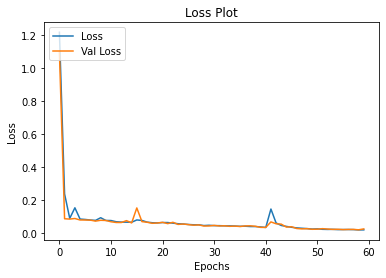

In [67]:
plt.plot(loss_plot)
plt.plot(val_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['Loss', 'Val Loss'], loc='upper left')
plt.show()

**Prediction Quality and Attention**

Actual DSL:  <START> Body { Header { Link Button Link Link } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } } <END>                        
Predicted DSL:  Body { Header { Link Button } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } Column { Subtitle Paragraph Button } } Row { Column { Subtitle Paragraph Button } } } <END>


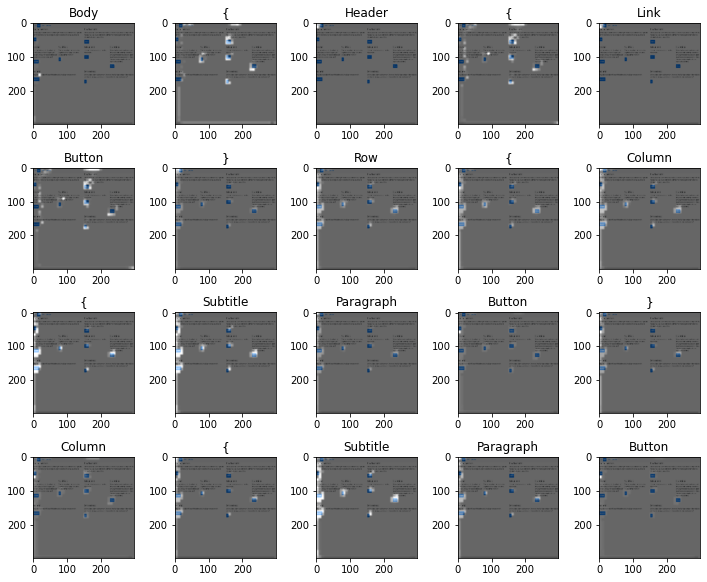

**Actual**

**Predicted**

In [184]:
test_entry = test_dataset.take(1)

for image, seq in test_entry:
    actual = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "")
    predicted, attention = evaluate(image)
    predicted = ' '.join(predicted)
    print("Actual DSL: ", actual)
    print("Predicted DSL: ", predicted)
    plot_attention(image.numpy(), predicted.split(), attention, 20)
    display(Markdown('**Actual**'))
    dsl_to_iframe(actual.split())
    display(Markdown('**Predicted**'))
    dsl_to_iframe(predicted.split())

**Calculate BLEU Metric**

In [72]:
def bleu_score(dataset, verbose=False):
    actual, predicted = list(), list()
    i = 0
    for image, seq in dataset:
        act = tokenizer.sequences_to_texts([seq.numpy()])[0].replace("<PAD>", "").split()
        pred, _ = evaluate(image)
        pred = ["<START>"] + pred
        if verbose:
            print("\n\nActual DSL---->\n", act)
            print("\nPredicted DSL---->\n", pred)
        else:
            print("Predicted count: " + str(i + 1), end='\r', flush=True)
        actual.append([act])
        predicted.append(pred)
        i += 1
    bleu = corpus_bleu(actual, predicted)
    return bleu, actual, predicted
        
bleu, actual, predicted = bleu_score(test_dataset)

In [106]:
print(bleu)

0.9580653304882601
